In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed

Detected 3 days of extreme consolidation (Triangle Squeezes).
Price          Close  BB_Width Is_Squeeze
Ticker      EURUSD=X                     
Date                                     
2023-11-01  1.057910  0.014152       True
2023-11-02  1.058705  0.012849       True
2023-11-03  1.061909  0.012966       True


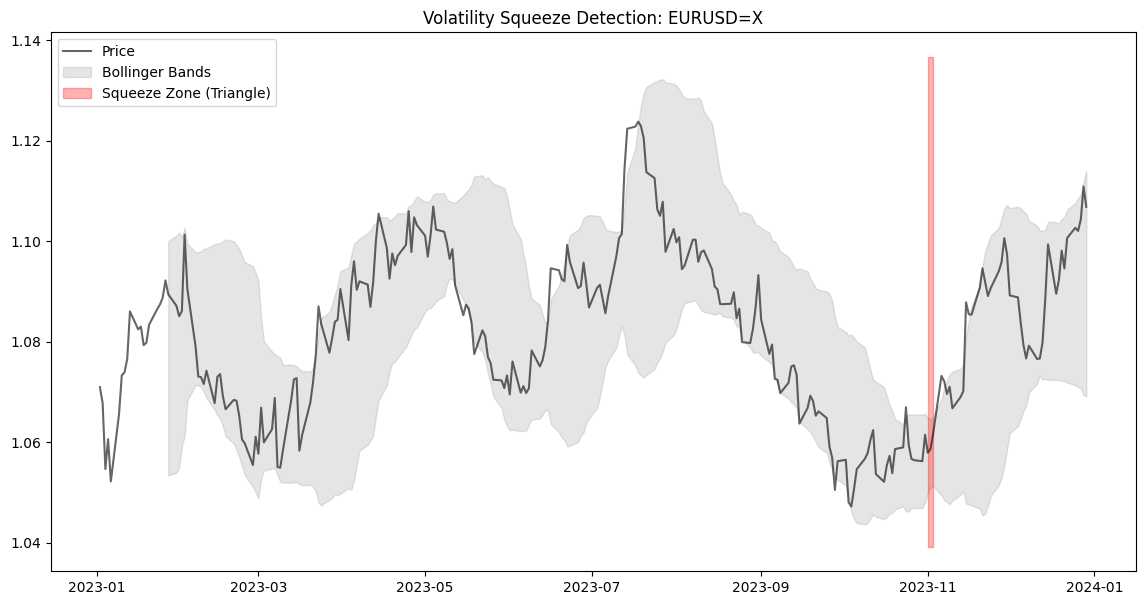

In [ ]:
def calculate_volatility_squeeze(ticker, start_date, end_date):
    # 1. Download Data
    df = yf.download(ticker, start=start_date, end=end_date)
    
    # 2. Calculate Bollinger Bands (20-day, 2 std dev)
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['StdDev_20'] = df['Close'].rolling(window=20).std()
    
    df['Upper_Band'] = df['SMA_20'] + (df['StdDev_20'] * 2)
    df['Lower_Band'] = df['SMA_20'] - (df['StdDev_20'] * 2)
    
    # 3. Calculate Band Width (The "Squeeze" Indicator)
    # This formula normalizes the width so you can compare it across different price levels
    df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['SMA_20']
    
    # 4. Define the "Squeeze" Threshold
    # We define a squeeze as when the width is in the bottom 5% of its 6-month history
    # This dynamic threshold adapts to changing market volatility
    df['Rolling_Min_Width'] = df['BB_Width'].rolling(window=126).min() # 126 trading days ~= 6 months
    df['Is_Squeeze'] = df['BB_Width'] <= (df['Rolling_Min_Width'] * 1.05) # Within 5% of the 6-month low
    
    return df

# --- Execution ---
ticker = "EURUSD=X" 
data = calculate_volatility_squeeze(ticker, "2023-01-01", "2024-01-01")

# Filter for days where the market was "Squeezing" (Potential Triangle)
squeeze_days = data[data['Is_Squeeze']]

print(f"Detected {len(squeeze_days)} days of extreme consolidation (Triangle Squeezes).")
print(squeeze_days[['Close', 'BB_Width', 'Is_Squeeze']].tail())

# --- Plotting for Verification ---
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Price', color='black', alpha=0.6)
plt.fill_between(data.index, data['Upper_Band'], data['Lower_Band'], color='gray', alpha=0.2, label='Bollinger Bands')

# Highlight Squeeze areas in Red
# We re-index to handle gaps in plotting
y_min, y_max = plt.ylim()
plt.fill_between(data.index, y_min, y_max, where=data['Is_Squeeze'], color='red', alpha=0.3, label='Squeeze Zone (Triangle)')

plt.title(f"Volatility Squeeze Detection: {ticker}")
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

--- Backtest Results: EURUSD=X (5 Years) ---
Total Trades: 8
Win Rate: 75.00%
Total PnL (Pips): 675.3
Final Capital: $16753.26


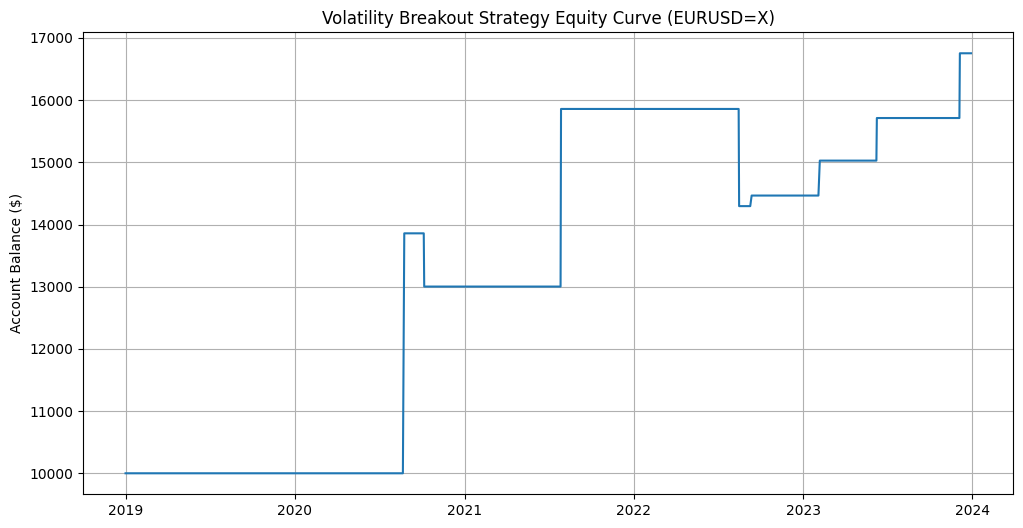

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def run_backtest(ticker, start_date, end_date, initial_capital=10000):
    # --- 1. Data & Indicators ---
    # auto_adjust=False ensures we get the raw Close/Open for consistency
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False).copy()
    
    # FIX: Flatten MultiIndex columns if they exist (Handle yfinance update)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
        
    # Bollinger Bands
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['StdDev_20'] = df['Close'].rolling(window=20).std()
    df['Upper'] = df['SMA_20'] + (df['StdDev_20'] * 2)
    df['Lower'] = df['SMA_20'] - (df['StdDev_20'] * 2)
    
    # Squeeze Detection
    df['BB_Width'] = (df['Upper'] - df['Lower']) / df['SMA_20']
    df['Rolling_Min_Width'] = df['BB_Width'].rolling(window=126).min()
    df['Is_Squeeze'] = df['BB_Width'] <= (df['Rolling_Min_Width'] * 1.05)
    
    # --- 2. Signal Generation ---
    # Ensure these are boolean Series, not DataFrames
    df['Is_Squeeze'] = df['Is_Squeeze'].astype(int) 
    
    # We use .rolling(5).max() to check if 'Is_Squeeze' was True recently
    df['Recent_Squeeze'] = df['Is_Squeeze'].rolling(window=5).max() 
    
    # Entry Conditions (Now guaranteed to be aligned Series)
    long_condition = (df['Close'] > df['Upper']) & (df['Recent_Squeeze'] == 1)
    short_condition = (df['Close'] < df['Lower']) & (df['Recent_Squeeze'] == 1)
    
    # --- 3. Simulation Loop (State Machine) ---
    position = 0 # 0: Flat, 1: Long, -1: Short
    entry_price = 0.0
    capital = initial_capital
    equity_curve = []
    trades = [] # Record of (Entry Date, Type, Entry Price, Exit Price, PnL)
    
    # Transaction Cost (Spread in pips converted to price terms, e.g., 0.00015)
    spread_cost = 0.00015 

    # Convert to numpy arrays for speed and to avoid index lookups in loop
    close_arr = df['Close'].values
    sma_arr = df['SMA_20'].values
    long_cond_arr = long_condition.values
    short_cond_arr = short_condition.values
    dates = df.index

    for i in range(len(df)):
        current_price = close_arr[i]
        current_date = dates[i]
        sma = sma_arr[i]
        
        # Check Exits first
        if position == 1: # We are Long
            if current_price < sma: # Exit Signal: Price fell below mean
                pnl = (current_price - entry_price - spread_cost) * 10000 # Pips
                capital += pnl * 10 # Assume $10 per pip
                position = 0
                trades.append({'Date': current_date, 'Type': 'Long Exit', 'Price': current_price, 'PnL_Pips': pnl})
        
        elif position == -1: # We are Short
            if current_price > sma: # Exit Signal: Price rose above mean
                pnl = (entry_price - current_price - spread_cost) * 10000 # Pips
                capital += pnl * 10
                position = 0
                trades.append({'Date': current_date, 'Type': 'Short Exit', 'Price': current_price, 'PnL_Pips': pnl})
        
        # Check Entries (Only if flat)
        if position == 0:
            if long_cond_arr[i]:
                position = 1
                entry_price = current_price
                trades.append({'Date': current_date, 'Type': 'Long Entry', 'Price': current_price, 'PnL_Pips': 0})
            elif short_cond_arr[i]:
                position = -1
                entry_price = current_price
                trades.append({'Date': current_date, 'Type': 'Short Entry', 'Price': current_price, 'PnL_Pips': 0})
        
        equity_curve.append(capital)

    df['Equity'] = equity_curve
    return df, pd.DataFrame(trades)

# --- Run the Backtest ---
ticker = "EURUSD=X"
data, trade_log = run_backtest(ticker, "2019-01-01", "2024-01-01")

# --- Results Analysis ---
if not trade_log.empty:
    exit_trades = trade_log[trade_log['Type'].str.contains('Exit')]
    total_trades = len(exit_trades)
    winning_trades = len(exit_trades[exit_trades['PnL_Pips'] > 0])
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    total_pnl_pips = exit_trades['PnL_Pips'].sum()

    print(f"--- Backtest Results: {ticker} (5 Years) ---")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total PnL (Pips): {total_pnl_pips:.1f}")
    print(f"Final Capital: ${data['Equity'].iloc[-1]:.2f}")
else:
    print("No trades triggered.")

# Plot Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Equity'], label='Strategy Equity')
plt.title(f"Volatility Breakout Strategy Equity Curve ({ticker})")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


--- ACTIVE Strategy Results: EURUSD=X ---
Total Trades: 12
Win Rate: 58.33%
Total PnL: 376.3 pips
Final Capital: $13763.35


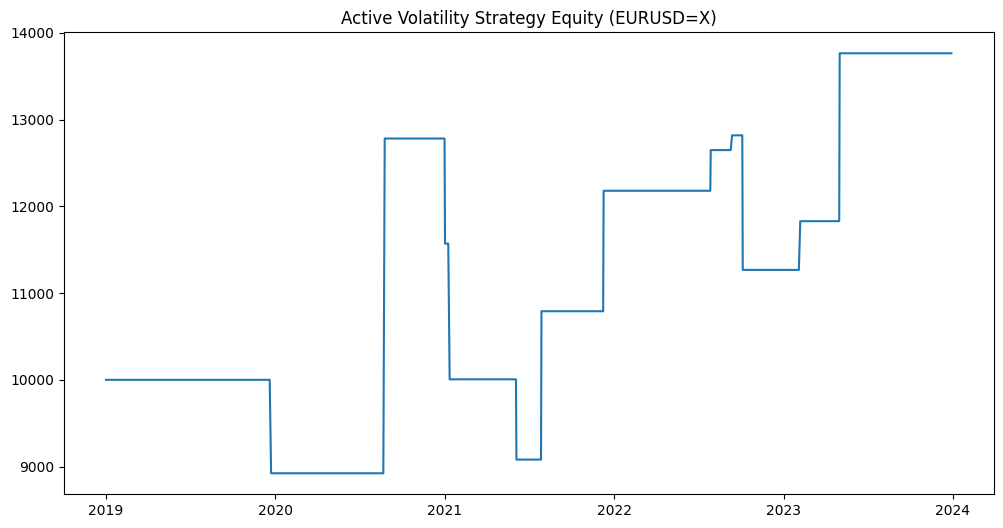

In [3]:
# ... (Keep the imports and initial setup) ...

def run_backtest_active(ticker, start_date, end_date, initial_capital=10000):
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False).copy()
    
    # Flatten MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
        
    # Standard Bollinger Bands
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['StdDev_20'] = df['Close'].rolling(window=20).std()
    df['Upper'] = df['SMA_20'] + (df['StdDev_20'] * 2)
    df['Lower'] = df['SMA_20'] - (df['StdDev_20'] * 2)
    
    # --- MODIFIED SQUEEZE LOGIC ---
    df['BB_Width'] = (df['Upper'] - df['Lower']) / df['SMA_20']
    
    # CHANGE 1: Lookback period reduced to 50 days (approx 2 months)
    # This finds "local" squeezes rather than "historic" ones
    df['Rolling_Min_Width'] = df['BB_Width'].rolling(window=50).min()
    
    # CHANGE 2: Threshold increased to 15%
    # We now accept setups that are "reasonably tight" not just "perfectly tight"
    df['Is_Squeeze'] = df['BB_Width'] <= (df['Rolling_Min_Width'] * 1.15)
    
    # ... (Rest of signal generation and loop remains the same) ...
    
    # Ensure boolean/int conversion for logic
    df['Is_Squeeze'] = df['Is_Squeeze'].astype(int) 
    df['Recent_Squeeze'] = df['Is_Squeeze'].rolling(window=5).max() 
    
    long_condition = (df['Close'] > df['Upper']) & (df['Recent_Squeeze'] == 1)
    short_condition = (df['Close'] < df['Lower']) & (df['Recent_Squeeze'] == 1)
    
        # 1. Calculate the Long-Term Trend (200 SMA)
    df['SMA_200'] = df['Close'].rolling(window=200).mean()

    # 2. Add the Trend Filter to your Entry Conditions
    # LONG: Breakout + Squeeze + Price is ABOVE 200 SMA
    long_condition = (
        (df['Close'] > df['Upper']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['Close'] > df['SMA_200']) 
    )

    # SHORT: Breakout + Squeeze + Price is BELOW 200 SMA
    short_condition = (
        (df['Close'] < df['Lower']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['Close'] < df['SMA_200'])
    )
    
    
    # ... (Copy the Simulation Loop from previous code) ...
    # (If you need me to paste the full loop again, let me know, 
    # otherwise you can just replace the definition block)
    
    # --- Quick Loop Paste for convenience ---
    position = 0 
    entry_price = 0.0
    capital = initial_capital
    equity_curve = []
    trades = [] 
    spread_cost = 0.00015 

    close_arr = df['Close'].values
    sma_arr = df['SMA_20'].values
    long_cond_arr = long_condition.values
    short_cond_arr = short_condition.values
    dates = df.index

    for i in range(len(df)):
        current_price = close_arr[i]
        current_date = dates[i]
        sma = sma_arr[i]
        
        if position == 1: 
            if current_price < sma: 
                pnl = (current_price - entry_price - spread_cost) * 10000 
                capital += pnl * 10 
                position = 0
                trades.append({'Date': current_date, 'Type': 'Long Exit', 'Price': current_price, 'PnL_Pips': pnl})
        elif position == -1: 
            if current_price > sma: 
                pnl = (entry_price - current_price - spread_cost) * 10000 
                capital += pnl * 10
                position = 0
                trades.append({'Date': current_date, 'Type': 'Short Exit', 'Price': current_price, 'PnL_Pips': pnl})
        
        if position == 0:
            if long_cond_arr[i]:
                position = 1
                entry_price = current_price
                trades.append({'Date': current_date, 'Type': 'Long Entry', 'Price': current_price, 'PnL_Pips': 0})
            elif short_cond_arr[i]:
                position = -1
                entry_price = current_price
                trades.append({'Date': current_date, 'Type': 'Short Entry', 'Price': current_price, 'PnL_Pips': 0})
        
        equity_curve.append(capital)

    df['Equity'] = equity_curve
    return df, pd.DataFrame(trades)

# Run with new parameters
ticker = "EURUSD=X"
data, trade_log = run_backtest_active(ticker, "2019-01-01", "2024-01-01")

# Analysis
if not trade_log.empty:
    exit_trades = trade_log[trade_log['Type'].str.contains('Exit')]
    print(f"--- ACTIVE Strategy Results: {ticker} ---")
    print(f"Total Trades: {len(exit_trades)}")
    print(f"Win Rate: {(len(exit_trades[exit_trades['PnL_Pips'] > 0]) / len(exit_trades) * 100):.2f}%")
    print(f"Total PnL: {exit_trades['PnL_Pips'].sum():.1f} pips")
    print(f"Final Capital: ${data['Equity'].iloc[-1]:.2f}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Equity'])
    plt.title(f"Active Volatility Strategy Equity ({ticker})")
    plt.show()

[*********************100%***********************]  1 of 1 completed


--- HOURLY Strategy Results: EURUSD=X (Last 2 Years) ---
Total Trades: 1
Win Rate: 100.00%
Total PnL: 10872.8 pips
Final Capital: $118727.93


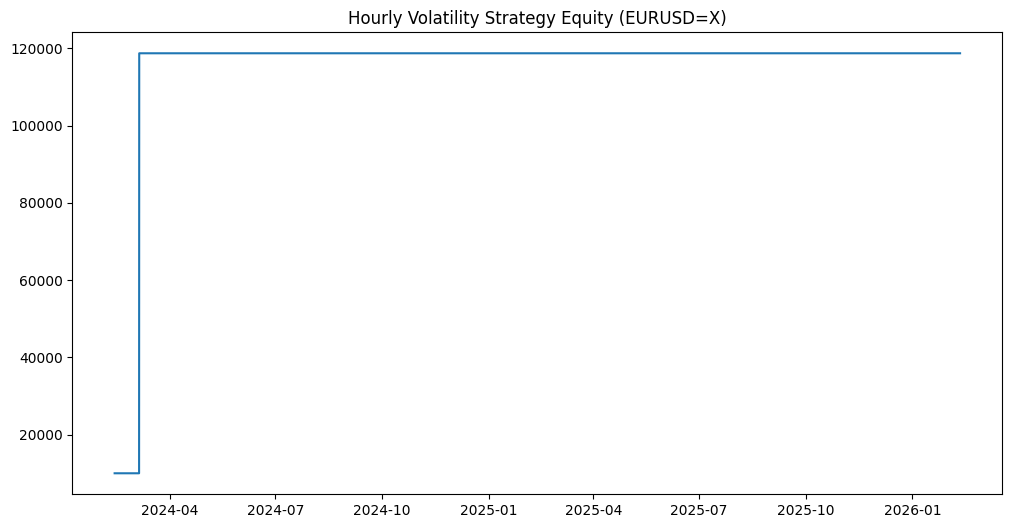

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_backtest_hourly(ticker):
    # --- 1. Data Setup (Dynamic Dates for 730-day limit) ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729) # Max allow by yfinance is ~730 days
    
    print(f"Downloading Hourly Data for {ticker}...")
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", auto_adjust=False).copy()
    
    # Flatten MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    # Drop rows with missing data
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    # Bollinger Bands (Standard 20-period on Hourly)
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['StdDev_20'] = df['Close'].rolling(window=20).std()
    df['Upper'] = df['SMA_20'] + (df['StdDev_20'] * 2)
    df['Lower'] = df['SMA_20'] - (df['StdDev_20'] * 2)
    
    # Trend Filter (200-Hour SMA -> approx 8-10 days trend)
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    
    # --- 3. Squeeze Logic (Adjusted for Hourly) ---
    df['BB_Width'] = (df['Upper'] - df['Lower']) / df['SMA_20']
    
    # CHANGE: Lookback is now 120 hours (1 trading week)
    df['Rolling_Min_Width'] = df['BB_Width'].rolling(window=120).min()
    
    # Squeeze Threshold: Within 10% of the 1-week low
    df['Is_Squeeze'] = df['BB_Width'] <= (df['Rolling_Min_Width'] * 1.10)
    
    # --- 4. Signal Generation ---
    df['Is_Squeeze'] = df['Is_Squeeze'].astype(int) 
    df['Recent_Squeeze'] = df['Is_Squeeze'].rolling(window=5).max() 
    
    # LONG: Breakout + Squeeze + Trend is UP
    long_condition = (
        (df['Close'] > df['Upper']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['Close'] > df['SMA_200']) 
    )

    # SHORT: Breakout + Squeeze + Trend is DOWN
    short_condition = (
        (df['Close'] < df['Lower']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['Close'] < df['SMA_200'])
    )

    # --- 5. Execution Loop ---
    position = 0 
    entry_price = 0.0
    capital = 10000
    equity_curve = []
    trades = [] 
    
    # Spread Cost: Still 1.5 pips (0.00015)
    # Note: This is "expensive" on hourly charts!
    spread_cost = 0.00015 

    close_arr = df['Close'].values
    sma_arr = df['SMA_20'].values
    long_cond_arr = long_condition.values
    short_cond_arr = short_condition.values
    dates = df.index

    for i in range(len(df)):
        current_price = close_arr[i]
        current_date = dates[i]
        sma = sma_arr[i]
        
    # 1. Get the hour of the current bar
        current_hour = current_date.hour # 0-23 format
        
        # 2. Define Active Hours (e.g., London Open to NY Close)
        # Adjust to your data's timezone (Yahoo usually returns UTC)
        # If UTC: London Open is roughly 7 or 8 AM. NY Close is 21 or 22 PM.
        is_active_session = (current_hour >= 7) & (current_hour <= 16)
        
        # 3. Update Entry Logic
        if position == 0 and is_active_session: # Add the check here
            if long_cond_arr[i]:
                pnl = (current_price - entry_price - spread_cost) * 10000 
                capital += pnl * 10 
                position = 0
                trades.append({'Date': current_date, 'Type': 'Long Exit', 'Price': current_price, 'PnL_Pips': pnl})
        elif position == -1: 
            if current_price > sma: 
                pnl = (entry_price - current_price - spread_cost) * 10000 
                capital += pnl * 10
                position = 0
                trades.append({'Date': current_date, 'Type': 'Short Exit', 'Price': current_price, 'PnL_Pips': pnl})
        
        # Check Entries
        if position == 0:
            if long_cond_arr[i]:
                position = 1
                entry_price = current_price
                trades.append({'Date': current_date, 'Type': 'Long Entry', 'Price': current_price, 'PnL_Pips': 0})
            elif short_cond_arr[i]:
                position = -1
                entry_price = current_price
                trades.append({'Date': current_date, 'Type': 'Short Entry', 'Price': current_price, 'PnL_Pips': 0})
        
        equity_curve.append(capital)

    df['Equity'] = equity_curve
    return df, pd.DataFrame(trades)

# Run on Hourly
ticker = "EURUSD=X"
data, trade_log = run_backtest_hourly(ticker)

# Results
if not trade_log.empty:
    exit_trades = trade_log[trade_log['Type'].str.contains('Exit')]
    print(f"--- HOURLY Strategy Results: {ticker} (Last 2 Years) ---")
    print(f"Total Trades: {len(exit_trades)}")
    print(f"Win Rate: {(len(exit_trades[exit_trades['PnL_Pips'] > 0]) / len(exit_trades) * 100):.2f}%")
    print(f"Total PnL: {exit_trades['PnL_Pips'].sum():.1f} pips")
    print(f"Final Capital: ${data['Equity'].iloc[-1]:.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Equity'])
    plt.title(f"Hourly Volatility Strategy Equity ({ticker})")
    plt.show()
else:
    print("No trades found on Hourly timeframe.")

--- Loading Data for GBPJPY=X ---
--- ROBUST Strategy Results: GBPJPY=X ---
Total Trades: 152
Win Rate: 30.92%
Total PnL: -2086.1 pips
Final Capital: $-10861.36


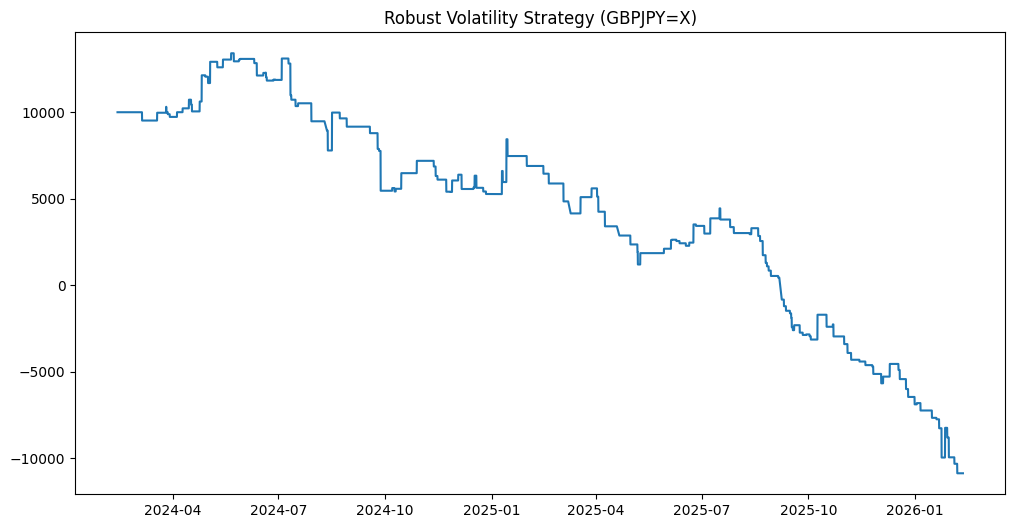

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_robust_strategy(ticker, timeframe="1h"):
    # --- 1. Data Setup ---
    # We grab max available hourly data (approx 730 days)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    print(f"--- Loading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval=timeframe, progress=False, auto_adjust=False).copy()
    
    # Flatten columns if MultiIndex (Fix for yfinance update)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    # Trend Filter: 200 SMA
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    
    # Mean Reversion Exit: 20 SMA
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    
    # Bollinger Bands (Standard)
    df['StdDev'] = df['Close'].rolling(window=20).std()
    df['Upper'] = df['SMA_20'] + (df['StdDev'] * 2)
    df['Lower'] = df['SMA_20'] - (df['StdDev'] * 2)
    
    # --- 3. ROBUST SQUEEZE LOGIC (Percentile Based) ---
    df['BB_Width'] = (df['Upper'] - df['Lower']) / df['SMA_20']
    
    # Calculate the percentile of the width over the last 120 bars (1 week)
    # If the current width is in the bottom 20% of the last week, it's a SQUEEZE.
    df['Width_Percentile'] = df['BB_Width'].rolling(window=120).rank(pct=True)
    df['Is_Squeeze'] = (df['Width_Percentile'] < 0.20).astype(int)
    
    # Look for squeeze in last 5 hours to allow for breakout delay
    df['Recent_Squeeze'] = df['Is_Squeeze'].rolling(window=5).max()

    # --- 4. Time Filter (London/NY Session Only) ---
    # Yahoo Finance Data is usually UTC. 
    # London Open (8 AM UTC) to NY Close (10 PM UTC) -> Hours 8 to 22.
    # Adjust this if your data source has a different timezone.
    df['Hour'] = df.index.hour
    df['Active_Session'] = ((df['Hour'] >= 8) & (df['Hour'] <= 22)).astype(int)

    # --- 5. Signal Logic ---
    # LONG: Price breaks Upper + Recent Squeeze + Trend UP + Active Time
    long_condition = (
        (df['Close'] > df['Upper']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['Close'] > df['SMA_200']) &
        (df['Active_Session'] == 1)
    )

    # SHORT: Price breaks Lower + Recent Squeeze + Trend DOWN + Active Time
    short_condition = (
        (df['Close'] < df['Lower']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['Close'] < df['SMA_200']) & 
        (df['Active_Session'] == 1)
    )

    # --- 6. Backtest Loop ---
    position = 0 
    entry_price = 0.0
    capital = 10000
    equity_curve = []
    trades = []
    
    # Spread Cost: 2.0 pips for GBPJPY (Standard)
    spread_cost = 0.0002 

    # Vectorize for speed
    close_arr = df['Close'].values
    sma_arr = df['SMA_20'].values
    long_cond_arr = long_condition.values
    short_cond_arr = short_condition.values
    dates = df.index

    for i in range(len(df)):
        current_price = close_arr[i]
        
        # Check Exits
        if position == 1: 
            if current_price < sma_arr[i]: # Exit Long
                pnl = (current_price - entry_price - spread_cost) * 100 # JPY pairs multiplier is 100, not 10000
                capital += pnl * 10 
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Long Exit', 'Price': current_price, 'PnL_Pips': pnl})
        elif position == -1: 
            if current_price > sma_arr[i]: # Exit Short
                pnl = (entry_price - current_price - spread_cost) * 100 
                capital += pnl * 10
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Short Exit', 'Price': current_price, 'PnL_Pips': pnl})
        
        # Check Entries
        if position == 0:
            if long_cond_arr[i]:
                position = 1
                entry_price = current_price
                trades.append({'Date': dates[i], 'Type': 'Long Entry', 'Price': current_price, 'PnL_Pips': 0})
            elif short_cond_arr[i]:
                position = -1
                entry_price = current_price
                trades.append({'Date': dates[i], 'Type': 'Short Entry', 'Price': current_price, 'PnL_Pips': 0})
        
        equity_curve.append(capital)

    df['Equity'] = equity_curve
    return df, pd.DataFrame(trades)

# --- Run on GBP/JPY ---
ticker = "GBPJPY=X" 
data, trade_log = run_robust_strategy(ticker)

# --- Results ---
if not trade_log.empty:
    exit_trades = trade_log[trade_log['Type'].str.contains('Exit')]
    print(f"--- ROBUST Strategy Results: {ticker} ---")
    print(f"Total Trades: {len(exit_trades)}")
    win_rate = (len(exit_trades[exit_trades['PnL_Pips'] > 0]) / len(exit_trades) * 100) if len(exit_trades) > 0 else 0
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total PnL: {exit_trades['PnL_Pips'].sum():.1f} pips")
    print(f"Final Capital: ${data['Equity'].iloc[-1]:.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Equity'])
    plt.title(f"Robust Volatility Strategy ({ticker})")
    plt.show()
else:
    print("No trades triggered. Check constraints.")

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_risk_reward_strategy(ticker, timeframe="1h"):
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    print(f"--- Loading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval=timeframe, progress=False, auto_adjust=False).copy()
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    # ATR (Average True Range) for Stops/Targets
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()

    # Bollinger Bands (For Squeeze)
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['StdDev'] = df['Close'].rolling(window=20).std()
    df['Upper'] = df['SMA_20'] + (df['StdDev'] * 2)
    df['Lower'] = df['SMA_20'] - (df['StdDev'] * 2)
    
    # Volume Filter (Volume must be > 1.5x the average)
    df['Vol_Avg'] = df['Volume'].rolling(window=20).mean()
    
    # Squeeze Logic (Percentile based - Robust)
    df['BB_Width'] = (df['Upper'] - df['Lower']) / df['SMA_20']
    df['Width_Percentile'] = df['BB_Width'].rolling(window=120).rank(pct=True)
    df['Is_Squeeze'] = (df['Width_Percentile'] < 0.20).astype(int)
    df['Recent_Squeeze'] = df['Is_Squeeze'].rolling(window=5).max()

    # Time Filter (London/NY Only)
    df['Hour'] = df.index.hour
    df['Active_Session'] = ((df['Hour'] >= 8) & (df['Hour'] <= 22)).astype(int)

    # --- 3. Signal Logic ---
    # LONG: Break Upper + Squeeze + High Volume + Active Time
    long_condition = (
        (df['Close'] > df['Upper']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['Volume'] > df['Vol_Avg'] * 1.5) & 
        (df['Active_Session'] == 1)
    )

    # SHORT: Break Lower + Squeeze + High Volume + Active Time
    short_condition = (
        (df['Close'] < df['Lower']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['Volume'] > df['Vol_Avg'] * 1.5) & 
        (df['Active_Session'] == 1)
    )

    # --- 4. Backtest Loop (With Hard Stops/Targets) ---
    position = 0 
    entry_price = 0.0
    stop_loss = 0.0
    take_profit = 0.0
    
    capital = 10000
    equity_curve = []
    trades = []
    
    spread_cost = 0.0002 # 2 Pips

    close_arr = df['Close'].values
    atr_arr = df['ATR'].values
    long_cond_arr = long_condition.values
    short_cond_arr = short_condition.values
    dates = df.index

    for i in range(len(df)):
        current_price = close_arr[i]
        current_atr = atr_arr[i]
        
        # Check Exits FIRST
        if position == 1: 
            # Hit Stop Loss?
            if current_price <= stop_loss:
                pnl = (stop_loss - entry_price - spread_cost) * 100
                capital += pnl * 10
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Long SL', 'Price': stop_loss, 'PnL_Pips': pnl})
            # Hit Take Profit?
            elif current_price >= take_profit:
                pnl = (take_profit - entry_price - spread_cost) * 100
                capital += pnl * 10
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Long TP', 'Price': take_profit, 'PnL_Pips': pnl})
                
        elif position == -1: 
            # Hit Stop Loss?
            if current_price >= stop_loss:
                pnl = (entry_price - stop_loss - spread_cost) * 100
                capital += pnl * 10
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Short SL', 'Price': stop_loss, 'PnL_Pips': pnl})
            # Hit Take Profit?
            elif current_price <= take_profit:
                pnl = (entry_price - take_profit - spread_cost) * 100
                capital += pnl * 10
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Short TP', 'Price': take_profit, 'PnL_Pips': pnl})
        
        # Check Entries (If Flat)
        if position == 0:
            if long_cond_arr[i]:
                position = 1
                entry_price = current_price
                # Set Risk:Reward 1:2
                stop_loss = current_price - (1.0 * current_atr)
                take_profit = current_price + (2.0 * current_atr)
                trades.append({'Date': dates[i], 'Type': 'Long Entry', 'Price': current_price, 'PnL_Pips': 0})
                
            elif short_cond_arr[i]:
                position = -1
                entry_price = current_price
                # Set Risk:Reward 1:2
                stop_loss = current_price + (1.0 * current_atr)
                take_profit = current_price - (2.0 * current_atr)
                trades.append({'Date': dates[i], 'Type': 'Short Entry', 'Price': current_price, 'PnL_Pips': 0})
        
        equity_curve.append(capital)

    df['Equity'] = equity_curve
    return df, pd.DataFrame(trades)

# --- Run on GBP/JPY ---
ticker = "GBPJPY=X" 
data, trade_log = run_risk_reward_strategy(ticker)

# --- Results ---
if not trade_log.empty:
    exit_trades = trade_log[trade_log['Type'].str.contains('TP|SL')]
    print(f"--- RISK/REWARD Strategy Results: {ticker} ---")
    print(f"Total Trades: {len(exit_trades)}")
    
    win_count = len(exit_trades[exit_trades['Type'].str.contains('TP')])
    win_rate = (win_count / len(exit_trades) * 100) if len(exit_trades) > 0 else 0
    
    print(f"Win Rate: {win_rate:.2f}% (Targeting 33%+)")
    print(f"Total PnL: {exit_trades['PnL_Pips'].sum():.1f} pips")
    print(f"Final Capital: ${data['Equity'].iloc[-1]:.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Equity'])
    plt.title(f"Risk/Reward Volatility Strategy ({ticker})")
    plt.show()
else:
    print("No trades triggered. Volume filter might be too strict.")

--- Loading Data for GBPJPY=X ---
No trades triggered. Volume filter might be too strict.


--- Loading Data for GBPJPY=X ---
--- ADX + Risk/Reward Strategy Results: GBPJPY=X ---
Total Trades: 144
Win Rate: 38.19%
Total PnL: 602.0 pips
Final Capital: $16020.16


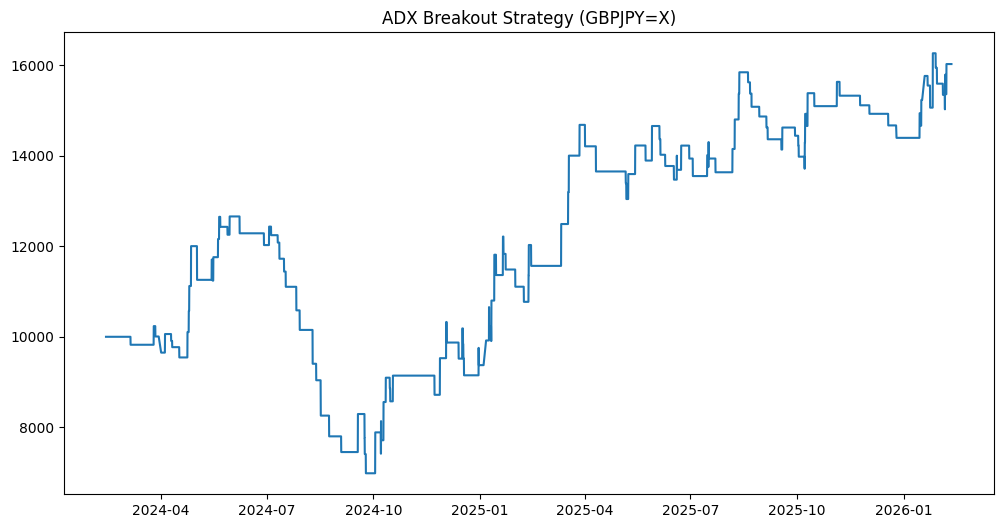

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_adx_strategy(ticker, timeframe="1h"):
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    print(f"--- Loading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval=timeframe, progress=False, auto_adjust=False).copy()
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    
    # A. Bollinger Bands (The Squeeze)
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['StdDev'] = df['Close'].rolling(window=20).std()
    df['Upper'] = df['SMA_20'] + (df['StdDev'] * 2)
    df['Lower'] = df['SMA_20'] - (df['StdDev'] * 2)
    
    # B. Squeeze Logic (Percentile based)
    df['BB_Width'] = (df['Upper'] - df['Lower']) / df['SMA_20']
    # Relaxed to bottom 25% to find more trades
    df['Width_Percentile'] = df['BB_Width'].rolling(window=120).rank(pct=True) 
    df['Is_Squeeze'] = (df['Width_Percentile'] < 0.25).astype(int)
    df['Recent_Squeeze'] = df['Is_Squeeze'].rolling(window=5).max()

    # C. ATR (For Stop Loss / Take Profit)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()

    # D. ADX Calculation (The "Explosion" Filter)
    # 1. Calculate Directional Movement
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    
    # 2. Smooth the TR and DM (Using Wilder's Smoothing)
    tr_s = pd.Series(true_range).ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()

    # 3. Calculate DI and DX
    plus_di = 100 * (plus_dm_s / tr_s)
    minus_di = 100 * (minus_dm_s / tr_s)
    dx = 100 * np.abs((plus_di - minus_di) / (plus_di + minus_di))
    
    # 4. Calculate ADX
    df['ADX'] = dx.ewm(alpha=1/14, min_periods=14).mean()

    # E. Time Filter (London/NY)
    df['Hour'] = df.index.hour
    df['Active_Session'] = ((df['Hour'] >= 8) & (df['Hour'] <= 22)).astype(int)

    # --- 3. Signal Logic ---
    # FILTER: Only trade if ADX > 20 (Market is trending/moving)
    
    # LONG: Break Upper + Squeeze + ADX Active + Active Time
    long_condition = (
        (df['Close'] > df['Upper']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['ADX'] > 20) & 
        (df['Active_Session'] == 1)
    )

    # SHORT: Break Lower + Squeeze + ADX Active + Active Time
    short_condition = (
        (df['Close'] < df['Lower']) & 
        (df['Recent_Squeeze'] == 1) & 
        (df['ADX'] > 20) & 
        (df['Active_Session'] == 1)
    )

    # --- 4. Backtest Loop (Risk:Reward 1:2) ---
    position = 0 
    entry_price = 0.0
    stop_loss = 0.0
    take_profit = 0.0
    
    capital = 10000
    equity_curve = []
    trades = []
    
    # Spread Cost: 2.5 pips (Conservative for GBPJPY)
    spread_cost = 0.00025 

    close_arr = df['Close'].values
    atr_arr = df['ATR'].values
    long_cond_arr = long_condition.values
    short_cond_arr = short_condition.values
    dates = df.index

    for i in range(len(df)):
        current_price = close_arr[i]
        current_atr = atr_arr[i]
        
        # Check Exits FIRST
        if position == 1: 
            if current_price <= stop_loss: # Hit SL
                pnl = (stop_loss - entry_price - spread_cost) * 100
                capital += pnl * 10
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Long SL', 'Price': stop_loss, 'PnL_Pips': pnl})
            elif current_price >= take_profit: # Hit TP
                pnl = (take_profit - entry_price - spread_cost) * 100
                capital += pnl * 10
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Long TP', 'Price': take_profit, 'PnL_Pips': pnl})
                
        elif position == -1: 
            if current_price >= stop_loss: # Hit SL
                pnl = (entry_price - stop_loss - spread_cost) * 100
                capital += pnl * 10
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Short SL', 'Price': stop_loss, 'PnL_Pips': pnl})
            elif current_price <= take_profit: # Hit TP
                pnl = (entry_price - take_profit - spread_cost) * 100
                capital += pnl * 10
                position = 0
                trades.append({'Date': dates[i], 'Type': 'Short TP', 'Price': take_profit, 'PnL_Pips': pnl})
        
        # Check Entries (If Flat)
        if position == 0:
            if long_cond_arr[i]:
                position = 1
                entry_price = current_price
                # Set Risk:Reward 1:2 (Risk 1 ATR, Target 2 ATR)
                stop_loss = current_price - (1.0 * current_atr)
                take_profit = current_price + (2.0 * current_atr)
                trades.append({'Date': dates[i], 'Type': 'Long Entry', 'Price': current_price, 'PnL_Pips': 0})
                
            elif short_cond_arr[i]:
                position = -1
                entry_price = current_price
                # Set Risk:Reward 1:2
                stop_loss = current_price + (1.0 * current_atr)
                take_profit = current_price - (2.0 * current_atr)
                trades.append({'Date': dates[i], 'Type': 'Short Entry', 'Price': current_price, 'PnL_Pips': 0})
        
        equity_curve.append(capital)

    df['Equity'] = equity_curve
    return df, pd.DataFrame(trades)

# --- Run on GBP/JPY ---
ticker = "GBPJPY=X" 
data, trade_log = run_adx_strategy(ticker)

# --- Results ---
if not trade_log.empty:
    exit_trades = trade_log[trade_log['Type'].str.contains('TP|SL')]
    print(f"--- ADX + Risk/Reward Strategy Results: {ticker} ---")
    print(f"Total Trades: {len(exit_trades)}")
    
    win_count = len(exit_trades[exit_trades['Type'].str.contains('TP')])
    win_rate = (win_count / len(exit_trades) * 100) if len(exit_trades) > 0 else 0
    
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total PnL: {exit_trades['PnL_Pips'].sum():.1f} pips")
    print(f"Final Capital: ${data['Equity'].iloc[-1]:.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Equity'])
    plt.title(f"ADX Breakout Strategy ({ticker})")
    plt.show()
else:
    print("No trades triggered. Check data feed.")

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.stats import linregress

def detect_triangle_pattern(ticker, start_date, end_date, window=20):
    # 1. Load Data
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)
    
    # 2. Find Pivot Points (Local Maxima and Minima)
    # 'order' determines how many neighbors to compare against. Higher = more significant pivots.
    order = 5 
    df['is_pivot_high'] = df.iloc[argrelextrema(df['High'].values, np.greater_equal, order=order)[0]]['High']
    df['is_pivot_low'] = df.iloc[argrelextrema(df['Low'].values, np.less_equal, order=order)[0]]['Low']
    
    # 3. Pattern Recognition Loop
    patterns = []
    
    # We scan a sliding window (e.g., look at the last 30 bars)
    lookback = 30
    
    for i in range(lookback, len(df)):
        window_df = df.iloc[i-lookback:i]
        
        # Get Pivots in this window
        highs = window_df[window_df['is_pivot_high'].notna()]
        lows = window_df[window_df['is_pivot_low'].notna()]
        
        # We need at least 3 points to form a reliable trendline
        if len(highs) < 3 or len(lows) < 3:
            continue
            
        # 4. Linear Regression on Highs (Resistance Line)
        # x is just integer index (0, 1, 2...), y is Price
        reg_high = linregress(np.arange(len(highs)), highs['High'].values)
        slope_high = reg_high.slope
        r_sq_high = reg_high.rvalue ** 2
        
        # 5. Linear Regression on Lows (Support Line)
        reg_low = linregress(np.arange(len(lows)), lows['Low'].values)
        slope_low = reg_low.slope
        r_sq_low = reg_low.rvalue ** 2
        
        # 6. Triangle Criteria
        # A. Lines must converge (Highs slope down, Lows slope up)
        # B. Fit must be decent (r_squared > threshold, e.g., 0.7) to avoid random noise
        is_converging = (slope_high < -0.001) and (slope_low > 0.001)
        good_fit = (r_sq_high > 0.8) and (r_sq_low > 0.8)
        
        if is_converging and good_fit:
            patterns.append({
                'Date': df.index[i],
                'Pattern': 'Triangle',
                'Slope_Res': slope_high,
                'Slope_Sup': slope_low,
                'R2_High': r_sq_high,
                'R2_Low': r_sq_low
            })

    return df, pd.DataFrame(patterns)

# --- Run Detection ---
ticker = "GBPUSD=X" # Cable often forms clean structures
data, pattern_log = detect_triangle_pattern(ticker, "2023-06-01", "2024-01-01")

print(f"Detected {len(pattern_log)} Geometric Triangles.")
print(pattern_log.tail())

# --- Visualization (Plot the last detected triangle) ---
if not pattern_log.empty:
    last_date = pattern_log.iloc[-1]['Date']
    idx = data.index.get_loc(last_date)
    
    # Zoom in on the pattern
    zoom_start = max(0, idx - 40)
    zoom_end = min(len(data), idx + 10)
    subset = data.iloc[zoom_start:zoom_end]
    
    plt.figure(figsize=(12, 6))
    plt.plot(subset.index, subset['Close'], label='Price', color='black', alpha=0.5)
    
    # Plot Pivots
    plt.scatter(subset.index, subset['is_pivot_high'], color='red', s=20, label='Pivot Highs')
    plt.scatter(subset.index, subset['is_pivot_low'], color='green', s=20, label='Pivot Lows')
    
    plt.title(f"Geometric Triangle Detection: {ticker} on {last_date.date()}")
    plt.legend()
    plt.show()

Detected 0 Geometric Triangles.
Empty DataFrame
Columns: []
Index: []


In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.stats import linregress
from datetime import datetime, timedelta

def run_triangle_strategy(ticker, timeframe="1h"):
    # --- 1. Data Loading ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729) # Max allowed for hourly
    
    print(f"--- 1. Downloading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval=timeframe, progress=False, auto_adjust=False).copy()
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.dropna(inplace=True)

    # --- 2. Helper Functions ---
    def get_pivots(data, order=5):
        # Finds local Highs and Lows
        # 'order=5' means it must be the highest point of 5 neighbors on each side
        high_idx = argrelextrema(data['High'].values, np.greater, order=order)[0]
        low_idx = argrelextrema(data['Low'].values, np.less, order=order)[0]
        return high_idx, low_idx

    # --- 3. Indicators for Filters/Exits ---
    # ATR for Stops
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Prev_Close']), 
                                     abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # 200 SMA for Trend Filter
    df['SMA_200'] = df['Close'].rolling(200).mean()

    # --- 4. The "Virtual Chartist" Loop ---
    # We cannot vectorize this easily because the "lines" change every bar.
    # We must loop through history bar-by-bar (Slow but accurate).
    
    trades = []
    equity = 10000
    equity_curve = []
    position = 0 # 0, 1 (Long), -1 (Short)
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    
    # Backtest Parameters
    lookback = 30 # How far back to look for pivots
    spread_cost = 0.00025 # 2.5 pips
    min_touches = 3 # Minimum pivots to validate a line
    
    print("--- 2. Scanning for Patterns (This may take 30s) ---")
    
    # Pre-calculate pivots to save time
    all_pivot_highs, all_pivot_lows = get_pivots(df, order=3)
    
    for i in range(200, len(df)):
        current_date = df.index[i]
        current_close = df['Close'].iloc[i]
        current_atr = df['ATR'].iloc[i]
        
        # --- A. Check Exits ---
        if position != 0:
            pnl = 0
            exit_type = ""
            
            if position == 1: # LONG
                if current_close <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 100
                    exit_type = "SL"
                elif current_close >= take_profit:
                    pnl = (take_profit - entry_price - spread_cost) * 100
                    exit_type = "TP"
            
            elif position == -1: # SHORT
                if current_close >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 100
                    exit_type = "SL"
                elif current_close <= take_profit:
                    pnl = (entry_price - take_profit - spread_cost) * 100
                    exit_type = "TP"
            
            if exit_type != "":
                equity += pnl * 10 
                trades.append({'Date': current_date, 'Type': exit_type, 'PnL': pnl})
                position = 0
                equity_curve.append(equity)
                continue # Skip pattern check if we just exited

        # --- B. Check Entries (Only if Flat) ---
        if position == 0:
            # 1. Get pivots in the lookback window
            # We filter the pre-calculated pivots to find ones in range [i-lookback : i]
            window_start_idx = i - lookback
            
            valid_highs = all_pivot_highs[(all_pivot_highs >= window_start_idx) & (all_pivot_highs < i)]
            valid_lows = all_pivot_lows[(all_pivot_lows >= window_start_idx) & (all_pivot_lows < i)]
            
            # We need at least 3 points to draw a solid line
            if len(valid_highs) >= min_touches and len(valid_lows) >= min_touches:
                
                # 2. Fit Lines (Linear Regression)
                # X = indices, Y = Price
                slope_res, intercept_res, r_sq_res, _, _ = linregress(valid_highs, df['High'].iloc[valid_highs])
                slope_sup, intercept_sup, r_sq_sup, _, _ = linregress(valid_lows, df['Low'].iloc[valid_lows])
                
                # 3. Validate Triangle Geometry
                # Resistance should slope Down (negative), Support should slope Up (positive)
                # R-Squared > 0.8 means the points form a "clean" line, not a mess
                is_triangle = (slope_res < -0.0001) and (slope_sup > 0.0001) and (r_sq_res > 0.85) and (r_sq_sup > 0.85)
                
                if is_triangle:
                    # 4. Calculate Breakout Levels for THIS specific bar
                    # y = mx + c
                    res_line_price = (slope_res * i) + intercept_res
                    sup_line_price = (slope_sup * i) + intercept_sup
                    
                    # 5. Check Breakout
                    # Trend Filter: Only Buy if Price > 200 SMA
                    trend_ok_long = current_close > df['SMA_200'].iloc[i]
                    trend_ok_short = current_close < df['SMA_200'].iloc[i]

                    # BUY Signal: Close breaks ABOVE Resistance Line
                    if current_close > res_line_price and trend_ok_long:
                        position = 1
                        entry_price = current_close
                        stop_loss = current_close - (1.5 * current_atr) # Wider stop for patterns
                        take_profit = current_close + (3.0 * current_atr) # 1:2 Ratio
                        trades.append({'Date': current_date, 'Type': 'Entry Long', 'PnL': 0})
                    
                    # SELL Signal: Close breaks BELOW Support Line
                    elif current_close < sup_line_price and trend_ok_short:
                        position = -1
                        entry_price = current_close
                        stop_loss = current_close + (1.5 * current_atr)
                        take_profit = current_close - (3.0 * current_atr)
                        trades.append({'Date': current_date, 'Type': 'Entry Short', 'PnL': 0})

        equity_curve.append(equity)

    return pd.DataFrame(trades), equity_curve

# --- Run on GBP/JPY (The best pair for patterns) ---
ticker = "GBPJPY=X"
trade_log, equity_curve = run_triangle_strategy(ticker)

# --- Results ---
if not trade_log.empty:
    closed_trades = trade_log[trade_log['PnL'] != 0]
    print(f"--- GEOMETRIC TRIANGLE RESULTS: {ticker} ---")
    print(f"Total Trades: {len(closed_trades)}")
    print(f"Win Rate: {(len(closed_trades[closed_trades['PnL'] > 0]) / len(closed_trades) * 100):.2f}%")
    print(f"Total PnL (Pips): {closed_trades['PnL'].sum():.1f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve)
    plt.title(f"Triangle Pattern Strategy Equity ({ticker})")
    plt.show()
else:
    print("No valid triangles found. Try relaxing the R-Squared threshold.")

--- 1. Downloading Data for GBPJPY=X ---
--- 2. Scanning for Patterns (This may take 30s) ---
No valid triangles found. Try relaxing the R-Squared threshold.


Running RELAXED Strategy on GBPJPY=X...
--- 1. Downloading Data for GBPJPY=X ---
--- 2. Scanning (R-Squared > 0.6)... ---
--- RELAXED TRIANGLE RESULTS: GBPJPY=X ---
Total Trades: 17
Win Rate: 23.53%
Total PnL (Pips): -238.1
Final Equity: $7619.32


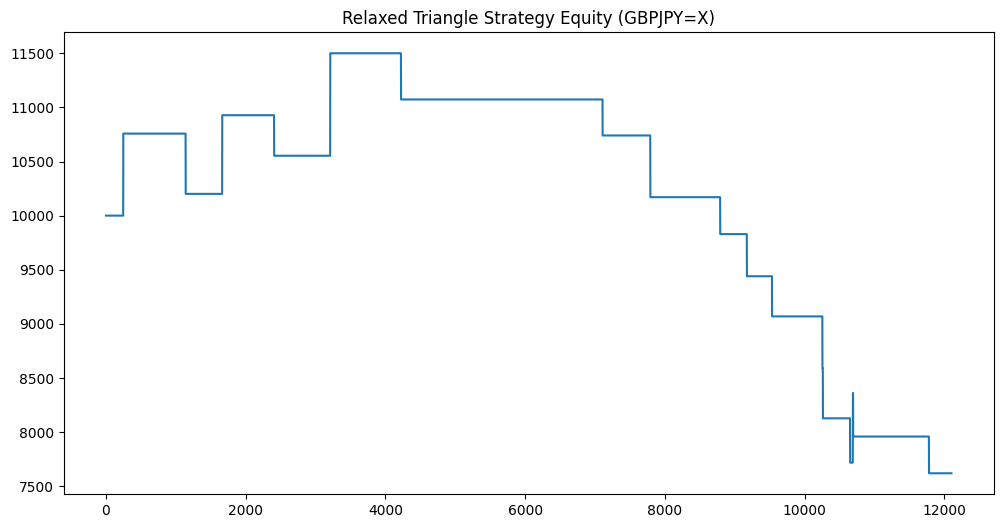

In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.stats import linregress
from datetime import datetime, timedelta

def run_relaxed_triangle_strategy(ticker, timeframe="1h"):
    # --- 1. Data Loading ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    print(f"--- 1. Downloading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval=timeframe, progress=False, auto_adjust=False).copy()
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    # ATR for Stops/Targets
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Prev_Close']), 
                                     abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # Trend Filter (200 SMA)
    df['SMA_200'] = df['Close'].rolling(200).mean()

    # --- 3. Helper: Pivot Detection ---
    # Relaxed Order: 3 (Checks 3 neighbors on each side -> 6-hour window)
    def get_pivots(data):
        high_idx = argrelextrema(data['High'].values, np.greater, order=3)[0]
        low_idx = argrelextrema(data['Low'].values, np.less, order=3)[0]
        return high_idx, low_idx

    # --- 4. Backtest Loop ---
    trades = []
    equity = 10000
    equity_curve = []
    position = 0 
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    
    # Relaxed Parameters
    lookback = 40 # Look slightly further back
    min_touches = 3 # Minimum 3 points to define a line
    r_sq_threshold = 0.60 # The "Messy" Tolerance (Was 0.85)
    spread_cost = 0.00025 # 2.5 pips

    print(f"--- 2. Scanning (R-Squared > {r_sq_threshold})... ---")
    
    # Pre-calculate pivots
    all_pivot_highs, all_pivot_lows = get_pivots(df)
    
    dates = df.index
    closes = df['Close'].values
    highs = df['High'].values
    lows = df['Low'].values
    atrs = df['ATR'].values
    sma200 = df['SMA_200'].values

    # Start loop (skip first 200 for SMA)
    for i in range(200, len(df)):
        current_date = dates[i]
        current_close = closes[i]
        
        # --- A. Check Exits ---
        if position != 0:
            pnl = 0
            exit_type = ""
            
            if position == 1: # LONG
                if current_close <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 100
                    exit_type = "SL"
                elif current_close >= take_profit:
                    pnl = (take_profit - entry_price - spread_cost) * 100
                    exit_type = "TP"
            
            elif position == -1: # SHORT
                if current_close >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 100
                    exit_type = "SL"
                elif current_close <= take_profit:
                    pnl = (entry_price - take_profit - spread_cost) * 100
                    exit_type = "TP"
            
            if exit_type != "":
                equity += pnl * 10
                trades.append({'Date': current_date, 'Type': exit_type, 'PnL': pnl})
                position = 0
                equity_curve.append(equity)
                continue 

        # --- B. Check Entries (If Flat) ---
        if position == 0:
            window_start = i - lookback
            
            # Find pivots in this specific window
            valid_highs = all_pivot_highs[(all_pivot_highs >= window_start) & (all_pivot_highs < i)]
            valid_lows = all_pivot_lows[(all_pivot_lows >= window_start) & (all_pivot_lows < i)]
            
            if len(valid_highs) >= min_touches and len(valid_lows) >= min_touches:
                
                # Fit Lines
                # We subtract 'window_start' to normalize x-axis (0 to 40), improves numerical stability
                slope_res, int_res, r_res, _, _ = linregress(valid_highs - window_start, highs[valid_highs])
                slope_sup, int_sup, r_sup, _, _ = linregress(valid_lows - window_start, lows[valid_lows])
                
                # Check Convergence (Symmetrical Triangle)
                # Resistance slopes down (< 0), Support slopes up (> 0)
                # Relaxed slope check: just needs to be arguably converging
                is_converging = (slope_res < -0.0001) and (slope_sup > 0.0001)
                
                # Check "Cleanliness"
                is_clean = (r_res**2 > r_sq_threshold) and (r_sup**2 > r_sq_threshold)
                
                if is_converging and is_clean:
                    # Calculate Breakout Level (Project line to current bar 'i')
                    # x coordinate is (i - window_start)
                    current_x = i - window_start
                    res_price = (slope_res * current_x) + int_res
                    sup_price = (slope_sup * current_x) + int_sup
                    
                    current_atr = atrs[i]
                    
                    # BUY: Breakout > Resistance Line + Trend UP
                    if current_close > res_price and current_close > sma200[i]:
                        position = 1
                        entry_price = current_close
                        stop_loss = current_close - (1.5 * current_atr)
                        take_profit = current_close + (3.0 * current_atr) # 1:2
                        trades.append({'Date': current_date, 'Type': 'Entry Long', 'PnL': 0})
                    
                    # SELL: Breakout < Support Line + Trend DOWN
                    elif current_close < sup_price and current_close < sma200[i]:
                        position = -1
                        entry_price = current_close
                        stop_loss = current_close + (1.5 * current_atr)
                        take_profit = current_close - (3.0 * current_atr) # 1:2
                        trades.append({'Date': current_date, 'Type': 'Entry Short', 'PnL': 0})

        equity_curve.append(equity)

    return pd.DataFrame(trades), equity_curve

# --- Run ---
ticker = "GBPJPY=X"
print(f"Running RELAXED Strategy on {ticker}...")
trade_log, equity_curve = run_relaxed_triangle_strategy(ticker)

# --- Results ---
if not trade_log.empty:
    closed_trades = trade_log[trade_log['PnL'] != 0]
    print(f"--- RELAXED TRIANGLE RESULTS: {ticker} ---")
    print(f"Total Trades: {len(closed_trades)}")
    
    if len(closed_trades) > 0:
        win_rate = (len(closed_trades[closed_trades['PnL'] > 0]) / len(closed_trades) * 100)
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Total PnL (Pips): {closed_trades['PnL'].sum():.1f}")
        print(f"Final Equity: ${equity_curve[-1]:.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve)
    plt.title(f"Relaxed Triangle Strategy Equity ({ticker})")
    plt.show()
else:
    print("Still no trades found. The market might be trending strongly (no triangles).")

Running PRO Triangle Strategy on GBPJPY=X...
--- 1. Downloading Data for GBPJPY=X ---
--- 2. Scanning for Triangles (Peak-to-Peak Method) ---
--- PRO TRIANGLE RESULTS: GBPJPY=X ---
Total Trades: 91
Win Rate: 39.56%
Total PnL (Pips): 981.1
Final Equity: $19810.96


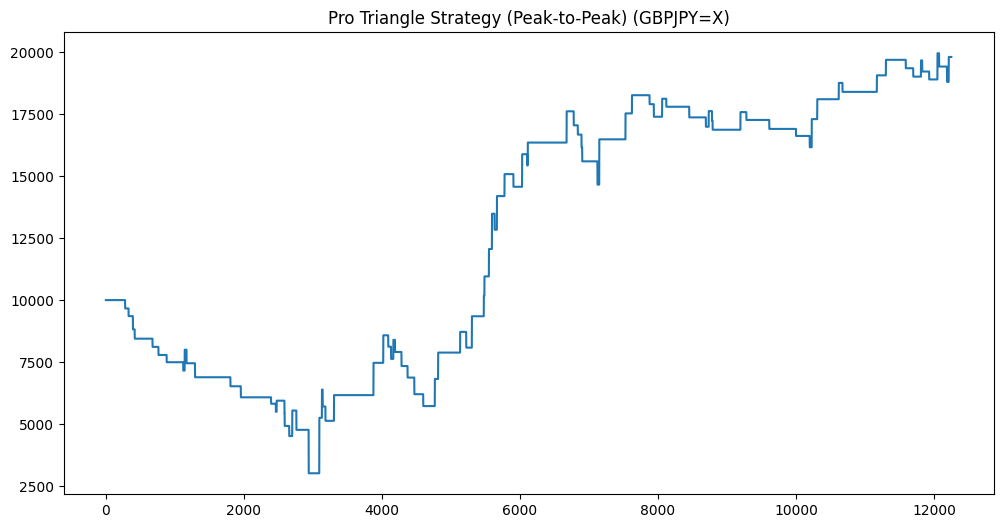

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_pro_triangle_strategy(ticker, timeframe="1h"):
    # --- 1. Data Loading ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    print(f"--- 1. Downloading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval=timeframe, progress=False, auto_adjust=False).copy()
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    # ATR for Buffer and Stops
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Prev_Close']), 
                                     abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # ADX Filter (The "Energy" Check)
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    plus_di = 100 * (plus_dm_s / tr_s)
    minus_di = 100 * (minus_dm_s / tr_s)
    dx = 100 * np.abs((plus_di - minus_di) / (plus_di + minus_di))
    df['ADX'] = dx.ewm(alpha=1/14, min_periods=14).mean()

    # --- 3. The "Human Eye" Pattern Logic ---
    trades = []
    equity = 10000
    equity_curve = []
    position = 0 
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    
    # Parameters
    lookback = 48 # Look back 2 days (48 hours)
    spread_cost = 0.00025 # 2.5 pips
    breakout_buffer = 0.0005 # 5 pips buffer (Must clear line by 5 pips)

    print("--- 2. Scanning for Triangles (Peak-to-Peak Method) ---")
    
    # We need to access values by integer index for speed
    highs = df['High'].values
    lows = df['Low'].values
    closes = df['Close'].values
    atrs = df['ATR'].values
    adxs = df['ADX'].values
    dates = df.index
    
    for i in range(lookback, len(df)):
        current_date = dates[i]
        current_close = closes[i]
        
        # --- A. Check Exits ---
        if position != 0:
            pnl = 0
            exit_type = ""
            if position == 1: # LONG
                if current_close <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 100
                    exit_type = "SL"
                elif current_close >= take_profit:
                    pnl = (take_profit - entry_price - spread_cost) * 100
                    exit_type = "TP"
            elif position == -1: # SHORT
                if current_close >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 100
                    exit_type = "SL"
                elif current_close <= take_profit:
                    pnl = (entry_price - take_profit - spread_cost) * 100
                    exit_type = "TP"
            
            if exit_type != "":
                equity += pnl * 10
                trades.append({'Date': current_date, 'Type': exit_type, 'PnL': pnl})
                position = 0
                equity_curve.append(equity)
                continue 

        # --- B. Check Entries (If Flat) ---
        if position == 0:
            # 1. Split window into two halves (Left and Right)
            # This ensures we connect a "Past Peak" to a "Recent Peak"
            mid_point = int(lookback / 2)
            
            # Find Index of Max High in Left Half (0 to 24)
            left_high_idx = np.argmax(highs[i-lookback : i-mid_point]) + (i-lookback)
            # Find Index of Max High in Right Half (24 to 48)
            right_high_idx = np.argmax(highs[i-mid_point : i]) + (i-mid_point)
            
            # Find Index of Min Low in Left Half
            left_low_idx = np.argmin(lows[i-lookback : i-mid_point]) + (i-lookback)
            # Find Index of Min Low in Right Half
            right_low_idx = np.argmin(lows[i-mid_point : i]) + (i-mid_point)
            
            # 2. Calculate Slopes (Rise / Run)
            # Slope = (Price2 - Price1) / (Index2 - Index1)
            
            # Resistance Line (Highs)
            run_res = right_high_idx - left_high_idx
            if run_res == 0: continue # Prevent divide by zero if peaks are same bar
            slope_res = (highs[right_high_idx] - highs[left_high_idx]) / run_res
            intercept_res = highs[right_high_idx] - (slope_res * right_high_idx)
            
            # Support Line (Lows)
            run_sup = right_low_idx - left_low_idx
            if run_sup == 0: continue
            slope_sup = (lows[right_low_idx] - lows[left_low_idx]) / run_sup
            intercept_sup = lows[right_low_idx] - (slope_sup * right_low_idx)
            
            # 3. Check Convergence (Triangle Shape)
            # Resistance should slope Down, Support should slope Up
            is_triangle = (slope_res < -0.00005) and (slope_sup > 0.00005)
            
            if is_triangle:
                # 4. Project Lines to Current Bar (i)
                res_price = (slope_res * i) + intercept_res
                sup_price = (slope_sup * i) + intercept_sup
                
                # 5. Breakout Logic with CONFIRMATION
                # Must be ADX > 20 (Energy)
                # Must break line by 'breakout_buffer' (Avoid wick fakes)
                
                # LONG
                if current_close > (res_price + breakout_buffer) and adxs[i] > 20:
                    position = 1
                    entry_price = current_close
                    stop_loss = current_close - (1.5 * atrs[i])
                    take_profit = current_close + (3.0 * atrs[i]) # 1:2 Risk/Reward
                    trades.append({'Date': current_date, 'Type': 'Entry Long', 'PnL': 0})
                
                # SHORT
                elif current_close < (sup_price - breakout_buffer) and adxs[i] > 20:
                    position = -1
                    entry_price = current_close
                    stop_loss = current_close + (1.5 * atrs[i])
                    take_profit = current_close - (3.0 * atrs[i]) # 1:2 Risk/Reward
                    trades.append({'Date': current_date, 'Type': 'Entry Short', 'PnL': 0})

        equity_curve.append(equity)

    return pd.DataFrame(trades), equity_curve

# --- Run ---
ticker = "GBPJPY=X"
print(f"Running PRO Triangle Strategy on {ticker}...")
trade_log, equity_curve = run_pro_triangle_strategy(ticker)

# --- Results ---
if not trade_log.empty:
    closed_trades = trade_log[trade_log['PnL'] != 0]
    print(f"--- PRO TRIANGLE RESULTS: {ticker} ---")
    print(f"Total Trades: {len(closed_trades)}")
    
    if len(closed_trades) > 0:
        win_rate = (len(closed_trades[closed_trades['PnL'] > 0]) / len(closed_trades) * 100)
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Total PnL (Pips): {closed_trades['PnL'].sum():.1f}")
        print(f"Final Equity: ${equity_curve[-1]:.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve)
    plt.title(f"Pro Triangle Strategy (Peak-to-Peak) ({ticker})")
    plt.show()
else:
    print("No trades found.")

In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def run_optimized_strategy(ticker):
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    # Download Hourly Data
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)
    
    # --- 2. Indicators ---
    # ATR
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Prev_Close']), 
                                     abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # Daily Trend Filter (Approximated on Hourly: 50 Daily SMA ~= 1200 Hourly SMA)
    df['Daily_SMA_50'] = df['Close'].rolling(window=1200).mean()
    
    # ADX
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    dx = 100 * np.abs((100*(plus_dm_s/tr_s) - 100*(minus_dm_s/tr_s)) / (100*(plus_dm_s/tr_s) + 100*(minus_dm_s/tr_s)))
    df['ADX'] = dx.ewm(alpha=1/14, min_periods=14).mean()

    # --- 3. Strategy Loop ---
    trades = []
    equity = 10000
    position = 0 
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    
    # Optimized Parameters
    lookback = 48 
    spread_cost = 0.00025 
    breakout_buffer = 0.0005 
    
    # OPTIMIZATION 1: Valid Trading Hours (UTC)
    # 7-10 (London Open), 13-16 (NY Open)
    valid_hours = [7, 8, 9, 10, 13, 14, 15, 16]

    highs = df['High'].values
    lows = df['Low'].values
    closes = df['Close'].values
    atrs = df['ATR'].values
    adxs = df['ADX'].values
    daily_smas = df['Daily_SMA_50'].values
    dates = df.index
    hours = df.index.hour # Access hour directly
    
    for i in range(1200, len(df)): # Start after Daily SMA exists
        current_date = dates[i]
        current_close = closes[i]
        current_hour = hours[i]
        
        # --- Exits ---
        if position != 0:
            pnl = 0
            if position == 1:
                if current_close <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 100
                    position = 0
                elif current_close >= take_profit:
                    pnl = (take_profit - entry_price - spread_cost) * 100
                    position = 0
            elif position == -1:
                if current_close >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 100
                    position = 0
                elif current_close <= take_profit:
                    pnl = (entry_price - take_profit - spread_cost) * 100
                    position = 0
            
            if position == 0:
                equity += pnl * 10
                trades.append({'PnL': pnl})
                continue 

        # --- Entries ---
        if position == 0:
            # OPTIMIZATION 1: Time Filter
            if current_hour not in valid_hours:
                continue
                
            mid = int(lookback / 2)
            left_high_idx = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
            right_high_idx = np.argmax(highs[i-mid : i]) + (i-mid)
            left_low_idx = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
            right_low_idx = np.argmin(lows[i-mid : i]) + (i-mid)
            
            run_res = right_high_idx - left_high_idx
            if run_res == 0: continue
            slope_res = (highs[right_high_idx] - highs[left_high_idx]) / run_res
            intercept_res = highs[right_high_idx] - (slope_res * right_high_idx)
            
            run_sup = right_low_idx - left_low_idx
            if run_sup == 0: continue
            slope_sup = (lows[right_low_idx] - lows[left_low_idx]) / run_sup
            intercept_sup = lows[right_low_idx] - (slope_sup * right_low_idx)
            
            is_triangle = (slope_res < -0.00005) and (slope_sup > 0.00005)
            
            if is_triangle:
                res_price = (slope_res * i) + intercept_res
                sup_price = (slope_sup * i) + intercept_sup
                
                # OPTIMIZATION 2: Trend Filter
                trend_is_up = current_close > daily_smas[i]
                trend_is_down = current_close < daily_smas[i]

                if current_close > (res_price + breakout_buffer) and adxs[i] > 20 and trend_is_up:
                    position = 1
                    entry_price = current_close
                    stop_loss = current_close - (1.5 * atrs[i])
                    take_profit = current_close + (3.0 * atrs[i])
                    trades.append({'PnL': 0}) # Log entry
                
                elif current_close < (sup_price - breakout_buffer) and adxs[i] > 20 and trend_is_down:
                    position = -1
                    entry_price = current_close
                    stop_loss = current_close + (1.5 * atrs[i])
                    take_profit = current_close - (3.0 * atrs[i])
                    trades.append({'PnL': 0})

    return equity, len(trades)

# Run Optimization
ticker = "GBPJPY=X"
print(f"Running OPTIMIZED Strategy on {ticker}...")
final_eq, trade_count = run_optimized_strategy(ticker)

print(f"Final Equity: ${final_eq:.2f}")
print(f"Total Trades: {trade_count}")

Running OPTIMIZED Strategy on GBPJPY=X...
Final Equity: $16008.28
Total Trades: 70


--- 1. Downloading Data for EURUSD=X ---
--- 2. Simulating Trades with Trailing Stop... ---
--- OPTIMIZED STRATEGY RESULTS: EURUSD=X ---
Total Trades: 21
Win Rate: 42.86%
Total PnL: 2.6 pips
Final Equity: $10025.62


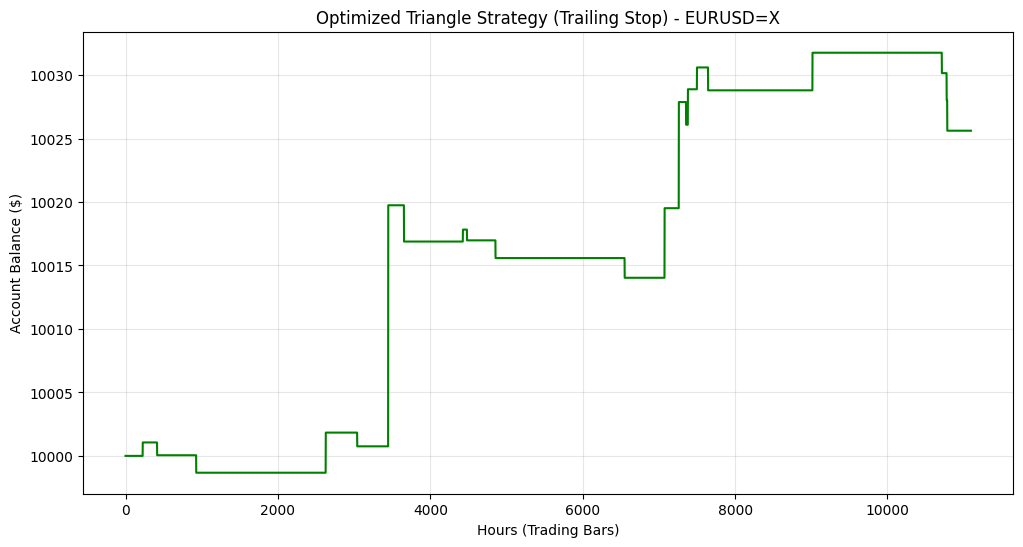

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_trailing_stop_strategy(ticker):
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729) # Max 2 years hourly
    
    print(f"--- 1. Downloading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    # ATR (For Trailing Stop)
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Prev_Close']), 
                                     abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # 50-Day Moving Average (approx 1200 hours) for Trend Direction
    df['Daily_SMA_50'] = df['Close'].rolling(window=1200).mean()
    
    # ADX (Energy Filter)
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    # Manual ADX calc to avoid library dependency
    plus_di = 100 * (plus_dm_s / tr_s)
    minus_di = 100 * (minus_dm_s / tr_s)
    dx = 100 * np.abs((plus_di - minus_di) / (plus_di + minus_di))
    df['ADX'] = dx.ewm(alpha=1/14, min_periods=14).mean()

    # --- 3. Trading Loop ---
    trades = []
    equity = 10000
    equity_curve = []
    
    position = 0 # 1 (Long), -1 (Short)
    entry_price = 0
    stop_loss = 0
    highest_price = 0 # Track max price for Long Trailing Stop
    lowest_price = 0  # Track min price for Short Trailing Stop
    
    # Strategy Parameters
    lookback = 48 
    spread_cost = 0.00025 # 2.5 pips
    breakout_buffer = 0.0005 # 5 pips
    
    # Valid Hours (London + NY Sessions)
    # Adjust to your data timezone if needed (Yahoo is usually UTC)
    valid_hours = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    # Convert columns to numpy for speed
    highs = df['High'].values
    lows = df['Low'].values
    closes = df['Close'].values
    atrs = df['ATR'].values
    adxs = df['ADX'].values
    smas = df['Daily_SMA_50'].values
    dates = df.index
    hours = df.index.hour
    
    print("--- 2. Simulating Trades with Trailing Stop... ---")

    for i in range(1200, len(df)): # Start after SMA is valid
        current_date = dates[i]
        current_close = closes[i]
        current_atr = atrs[i]
        
        # --- A. Manage Open Positions (Trailing Stop Logic) ---
        if position != 0:
            pnl = 0
            
            if position == 1: # LONG
                # 1. Update High Water Mark
                if current_close > highest_price:
                    highest_price = current_close
                    # Move Stop Up (Trail by 1.5 ATR from the High)
                    new_stop = highest_price - (1.5 * current_atr)
                    if new_stop > stop_loss:
                        stop_loss = new_stop
                
                # 2. Check Exit
                if current_close <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 100
                    position = 0
                    trades.append({'Date': current_date, 'Type': 'Long Exit', 'PnL': pnl})
            
            elif position == -1: # SHORT
                # 1. Update Low Water Mark
                if current_close < lowest_price:
                    lowest_price = current_close
                    # Move Stop Down (Trail by 1.5 ATR from the Low)
                    new_stop = lowest_price + (1.5 * current_atr)
                    if new_stop < stop_loss:
                        stop_loss = new_stop
                
                # 2. Check Exit
                if current_close >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 100
                    position = 0
                    trades.append({'Date': current_date, 'Type': 'Short Exit', 'PnL': pnl})
            
            if position == 0:
                equity += pnl * 10 # $10 per pip
                equity_curve.append(equity)
                continue

        # --- B. Check Entries (If Flat) ---
        if position == 0:
            # Filter 1: Time
            if hours[i] not in valid_hours:
                equity_curve.append(equity)
                continue
                
            # Filter 2: Peak-to-Peak Triangle Logic
            mid = int(lookback / 2)
            # Safe argmax (in case of flat data)
            try:
                left_high_idx = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
                right_high_idx = np.argmax(highs[i-mid : i]) + (i-mid)
                left_low_idx = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
                right_low_idx = np.argmin(lows[i-mid : i]) + (i-mid)
            except:
                equity_curve.append(equity)
                continue
            
            # Slopes
            run_res = right_high_idx - left_high_idx
            if run_res == 0: 
                equity_curve.append(equity)
                continue
            slope_res = (highs[right_high_idx] - highs[left_high_idx]) / run_res
            intercept_res = highs[right_high_idx] - (slope_res * right_high_idx)
            
            run_sup = right_low_idx - left_low_idx
            if run_sup == 0: 
                equity_curve.append(equity)
                continue
            slope_sup = (lows[right_low_idx] - lows[left_low_idx]) / run_sup
            intercept_sup = lows[right_low_idx] - (slope_sup * right_low_idx)
            
            is_triangle = (slope_res < -0.00005) and (slope_sup > 0.00005)
            
            if is_triangle:
                res_price = (slope_res * i) + intercept_res
                sup_price = (slope_sup * i) + intercept_sup
                
                # Filter 3: Trend (Price vs 50 Day SMA)
                trend_is_up = current_close > smas[i]
                trend_is_down = current_close < smas[i]
                
                # Filter 4: Energy (ADX > 20)
                energy_ok = adxs[i] > 20

                # LONG ENTRY
                if current_close > (res_price + breakout_buffer) and energy_ok and trend_is_up:
                    position = 1
                    entry_price = current_close
                    highest_price = current_close # Initialize High Water Mark
                    stop_loss = current_close - (1.5 * current_atr) # Initial Stop
                    trades.append({'Date': current_date, 'Type': 'Long Entry', 'PnL': 0})
                
                # SHORT ENTRY
                elif current_close < (sup_price - breakout_buffer) and energy_ok and trend_is_down:
                    position = -1
                    entry_price = current_close
                    lowest_price = current_close # Initialize Low Water Mark
                    stop_loss = current_close + (1.5 * current_atr) # Initial Stop
                    trades.append({'Date': current_date, 'Type': 'Short Entry', 'PnL': 0})

        equity_curve.append(equity)

    return pd.DataFrame(trades), equity_curve

# --- Run ---
ticker = "EURUSD=X"
trade_log, equity_curve = run_trailing_stop_strategy(ticker)

# --- Results ---
if not trade_log.empty:
    closed_trades = trade_log[trade_log['PnL'] != 0]
    print(f"--- OPTIMIZED STRATEGY RESULTS: {ticker} ---")
    print(f"Total Trades: {len(closed_trades)}")
    
    if len(closed_trades) > 0:
        win_rate = (len(closed_trades[closed_trades['PnL'] > 0]) / len(closed_trades) * 100)
        total_pips = closed_trades['PnL'].sum()
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Total PnL: {total_pips:.1f} pips")
        print(f"Final Equity: ${equity_curve[-1]:.2f}")
        
        # --- Plotting the Equity Curve ---
        plt.figure(figsize=(12, 6))
        plt.plot(equity_curve, color='green', linewidth=1.5)
        plt.title(f"Optimized Triangle Strategy (Trailing Stop) - {ticker}")
        plt.xlabel("Hours (Trading Bars)")
        plt.ylabel("Account Balance ($)")
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Trades were opened but none closed (held to end).")
else:
    print("No trades found. Filters might be too strict.")

In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def run_strict_strategy(ticker):
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # --- Indicators ---
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    df['Daily_SMA_50'] = df['Close'].rolling(1200).mean()
    
    # ADX
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    df['ADX'] = (100 * np.abs((100*(plus_dm_s/tr_s) - 100*(minus_dm_s/tr_s)) / (100*(plus_dm_s/tr_s) + 100*(minus_dm_s/tr_s)))).ewm(alpha=1/14, min_periods=14).mean()

    # --- Strategy Loop ---
    trades = []
    equity = 10000
    position = 0 
    entry_price = 0
    stop_loss = 0
    highest_price = 0 
    lowest_price = 0
    
    lookback = 48 
    spread_cost = 0.00025 
    breakout_buffer = 0.0005 
    valid_hours = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    # Numpy arrays for speed
    highs = df['High'].values
    lows = df['Low'].values
    closes = df['Close'].values
    atrs = df['ATR'].values
    adxs = df['ADX'].values
    smas = df['Daily_SMA_50'].values
    dates = df.index
    hours = df.index.hour
    
    print("--- Running STRICT Simulation (Checking High/Low for Exits) ---")

    for i in range(1200, len(df)):
        current_date = dates[i]
        current_close = closes[i]
        current_high = highs[i] # NEEDED FOR STRICT EXIT
        current_low = lows[i]   # NEEDED FOR STRICT EXIT
        current_atr = atrs[i]
        
        # --- A. STRICT Exit Logic ---
        if position != 0:
            pnl = 0
            
            if position == 1: # LONG
                # 1. CRITICAL: Check Stop Loss against LOW (Intraday Risk)
                if current_low <= stop_loss:
                    # We assume we got stopped at the exact SL price (Slippage excluded for simplicity)
                    pnl = (stop_loss - entry_price - spread_cost) * 100
                    position = 0
                    equity += pnl * 10
                    trades.append({'PnL': pnl})
                    continue # Trade is dead, skip to next bar
                
                # 2. Update Trailing Stop (Only if we survived the Low)
                if current_high > highest_price:
                    highest_price = current_high
                    new_stop = highest_price - (1.5 * current_atr)
                    if new_stop > stop_loss: stop_loss = new_stop

            elif position == -1: # SHORT
                # 1. CRITICAL: Check Stop Loss against HIGH
                if current_high >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 100
                    position = 0
                    equity += pnl * 10
                    trades.append({'PnL': pnl})
                    continue 

                # 2. Update Trailing Stop
                if current_low < lowest_price:
                    lowest_price = current_low
                    new_stop = lowest_price + (1.5 * current_atr)
                    if new_stop < stop_loss: stop_loss = new_stop
        
        # --- B. Entry Logic (Same as before) ---
        if position == 0:
            if hours[i] not in valid_hours: continue
            
            mid = int(lookback / 2)
            try:
                left_high_idx = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
                right_high_idx = np.argmax(highs[i-mid : i]) + (i-mid)
                left_low_idx = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
                right_low_idx = np.argmin(lows[i-mid : i]) + (i-mid)
            except: continue
            
            run_res = right_high_idx - left_high_idx
            if run_res == 0: continue
            slope_res = (highs[right_high_idx] - highs[left_high_idx]) / run_res
            intercept_res = highs[right_high_idx] - (slope_res * right_high_idx)
            
            run_sup = right_low_idx - left_low_idx
            if run_sup == 0: continue
            slope_sup = (lows[right_low_idx] - lows[left_low_idx]) / run_sup
            intercept_sup = lows[right_low_idx] - (slope_sup * right_low_idx)
            
            is_triangle = (slope_res < -0.00005) and (slope_sup > 0.00005)
            
            if is_triangle:
                res_price = (slope_res * i) + intercept_res
                sup_price = (slope_sup * i) + intercept_sup
                trend_is_up = current_close > smas[i]
                trend_is_down = current_close < smas[i]
                
                # Check Breakout
                if current_close > (res_price + breakout_buffer) and adxs[i] > 20 and trend_is_up:
                    position = 1
                    entry_price = current_close
                    highest_price = current_close 
                    stop_loss = current_close - (1.5 * current_atr)
                
                elif current_close < (sup_price - breakout_buffer) and adxs[i] > 20 and trend_is_down:
                    position = -1
                    entry_price = current_close
                    lowest_price = current_close
                    stop_loss = current_close + (1.5 * current_atr)

    return equity, trades

# --- Run Strict Test ---
ticker = "GBPJPY=X"
final_eq, trade_log = run_strict_strategy(ticker)

print(f"--- STRICT RESULTS (No Zombies): {ticker} ---")
print(f"Total Trades: {len(trade_log)}")
if len(trade_log) > 0:
    winners = [t for t in trade_log if t['PnL'] > 0]
    print(f"Win Rate: {(len(winners)/len(trade_log)*100):.2f}%")
    print(f"Total PnL: {sum(t['PnL'] for t in trade_log):.1f} pips")
print(f"Final Equity: ${final_eq:.2f}")

--- Running STRICT Simulation (Checking High/Low for Exits) ---
--- STRICT RESULTS (No Zombies): GBPJPY=X ---
Total Trades: 40
Win Rate: 42.50%
Total PnL: 131.8 pips
Final Equity: $11318.37


--- 1. Downloading Data for AUDUSD=X ---
--- 2. Running Strict Simulation... ---
--- STRICT RESULTS: AUDUSD=X ---
Total Trades: 11
Win Rate: 27.27%
Total PnL: -0.4 pips
Final Equity: $9995.58


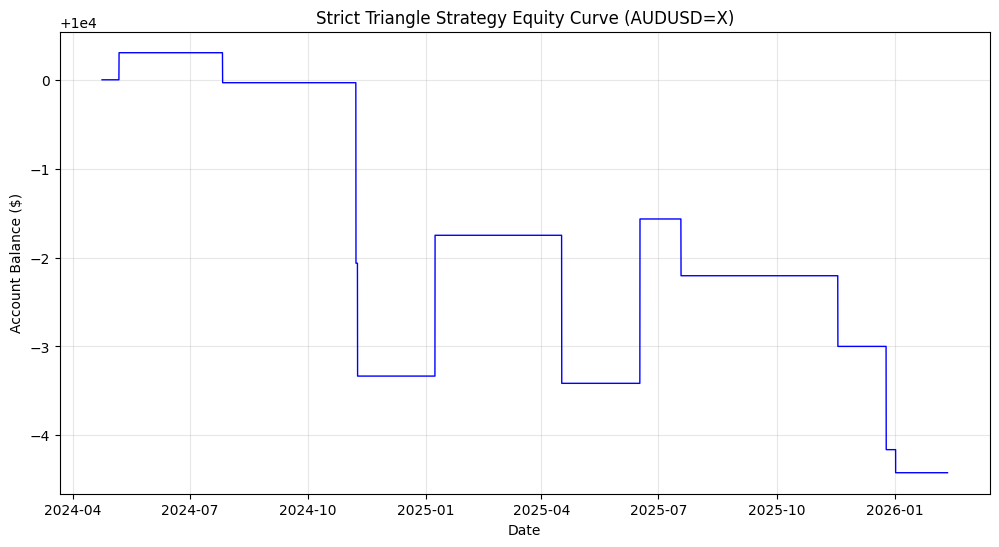

In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_strict_strategy_with_chart(ticker):
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    print(f"--- 1. Downloading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Prev_Close']), 
                                     abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # Trend Filter
    df['Daily_SMA_50'] = df['Close'].rolling(window=1200).mean()
    
    # ADX Filter
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    # Explicit ADX calc
    dx = 100 * np.abs((100*(plus_dm_s/tr_s) - 100*(minus_dm_s/tr_s)) / (100*(plus_dm_s/tr_s) + 100*(minus_dm_s/tr_s)))
    df['ADX'] = dx.ewm(alpha=1/14, min_periods=14).mean()

    # --- 3. Simulation Loop ---
    trades = []
    equity = 10000
    equity_curve = [] # List to store equity at every hour
    
    position = 0 
    entry_price = 0
    stop_loss = 0
    highest_price = 0 
    lowest_price = 0
    
    # Parameters
    lookback = 48 
    spread_cost = 0.00025 
    breakout_buffer = 0.0005 
    valid_hours = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    # Speed arrays
    highs = df['High'].values
    lows = df['Low'].values
    closes = df['Close'].values
    atrs = df['ATR'].values
    adxs = df['ADX'].values
    smas = df['Daily_SMA_50'].values
    dates = df.index
    hours = df.index.hour
    
    print("--- 2. Running Strict Simulation... ---")

    for i in range(1200, len(df)):
        current_date = dates[i]
        current_close = closes[i]
        current_high = highs[i]
        current_low = lows[i]
        current_atr = atrs[i]
        
        # --- A. STRICT Exit Logic (Check Wicks) ---
        if position != 0:
            pnl = 0
            trade_closed = False
            
            if position == 1: # LONG
                # Check Stop Loss against LOW
                if current_low <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 100
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'Date': current_date, 'PnL': pnl})
                
                # Update Trailing Stop
                elif current_high > highest_price:
                    highest_price = current_high
                    new_stop = highest_price - (1.5 * current_atr)
                    if new_stop > stop_loss: stop_loss = new_stop

            elif position == -1: # SHORT
                # Check Stop Loss against HIGH
                if current_high >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 100
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'Date': current_date, 'PnL': pnl})

                # Update Trailing Stop
                elif current_low < lowest_price:
                    lowest_price = current_low
                    new_stop = lowest_price + (1.5 * current_atr)
                    if new_stop < stop_loss: stop_loss = new_stop
            
            # If trade closed this bar, record equity and skip entry logic
            if trade_closed:
                equity_curve.append({'Date': current_date, 'Equity': equity})
                continue
            
            # If trade is still open, record "floating" equity (optional, or just last closed)
            # For simplicity, we record current closed equity
            equity_curve.append({'Date': current_date, 'Equity': equity})


        # --- B. Entry Logic ---
        if position == 0:
            equity_curve.append({'Date': current_date, 'Equity': equity})
            
            if hours[i] not in valid_hours: continue
            
            mid = int(lookback / 2)
            try:
                left_high_idx = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
                right_high_idx = np.argmax(highs[i-mid : i]) + (i-mid)
                left_low_idx = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
                right_low_idx = np.argmin(lows[i-mid : i]) + (i-mid)
            except: continue
            
            run_res = right_high_idx - left_high_idx
            if run_res == 0: continue
            slope_res = (highs[right_high_idx] - highs[left_high_idx]) / run_res
            intercept_res = highs[right_high_idx] - (slope_res * right_high_idx)
            
            run_sup = right_low_idx - left_low_idx
            if run_sup == 0: continue
            slope_sup = (lows[right_low_idx] - lows[left_low_idx]) / run_sup
            intercept_sup = lows[right_low_idx] - (slope_sup * right_low_idx)
            
            is_triangle = (slope_res < -0.00005) and (slope_sup > 0.00005)
            
            if is_triangle:
                res_price = (slope_res * i) + intercept_res
                sup_price = (slope_sup * i) + intercept_sup
                trend_is_up = current_close > smas[i]
                trend_is_down = current_close < smas[i]
                energy_ok = adxs[i] > 20

                if current_close > (res_price + breakout_buffer) and energy_ok and trend_is_up:
                    position = 1
                    entry_price = current_close
                    highest_price = current_close
                    stop_loss = current_close - (1.5 * current_atr)
                
                elif current_close < (sup_price - breakout_buffer) and energy_ok and trend_is_down:
                    position = -1
                    entry_price = current_close
                    lowest_price = current_close
                    stop_loss = current_close + (1.5 * current_atr)

    return pd.DataFrame(equity_curve), pd.DataFrame(trades)

# --- Run & Plot ---
ticker = "AUDUSD=X"
df_equity, df_trades = run_strict_strategy_with_chart(ticker)

# --- Results ---
if not df_trades.empty:
    print(f"--- STRICT RESULTS: {ticker} ---")
    print(f"Total Trades: {len(df_trades)}")
    win_rate = len(df_trades[df_trades['PnL'] > 0]) / len(df_trades) * 100
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total PnL: {df_trades['PnL'].sum():.1f} pips")
    print(f"Final Equity: ${df_equity.iloc[-1]['Equity']:.2f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(df_equity['Date']), df_equity['Equity'], color='blue', linewidth=1)
    plt.title(f"Strict Triangle Strategy Equity Curve ({ticker})")
    plt.xlabel("Date")
    plt.ylabel("Account Balance ($)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No trades found.")

--- Downloading Data for GBPUSD=X ---
--- Running Breakeven + Target Simulation ---
--- BREAKEVEN STRATEGY RESULTS: GBPUSD=X ---
Total Trades: 27
Win Rate: 44.44%
Total PnL: 216.5 pips
Final Equity: $12165.05


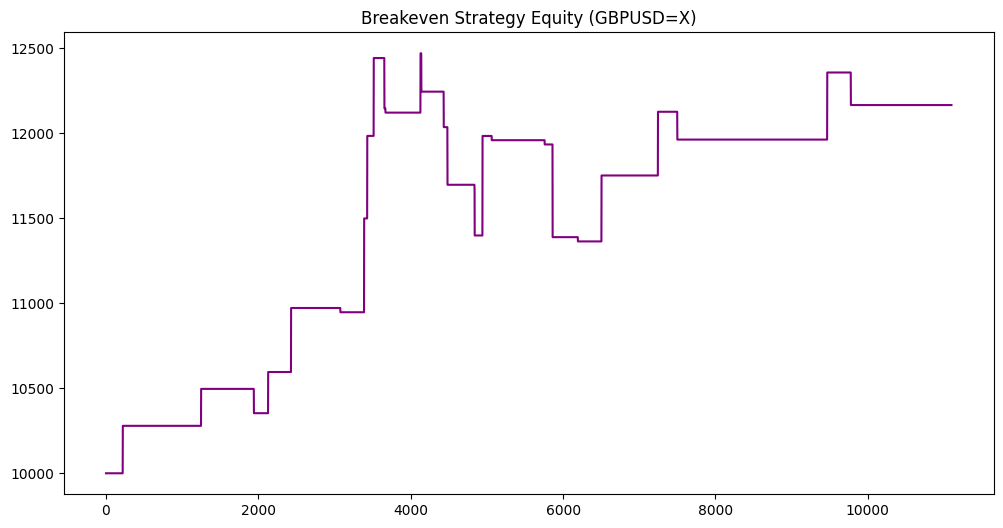

In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_breakeven_strategy(ticker):
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    print(f"--- Downloading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # --- Indicators ---
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    df['Daily_SMA_50'] = df['Close'].rolling(1200).mean()
    
    # ADX
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    df['ADX'] = (100 * np.abs((100*(plus_dm_s/tr_s) - 100*(minus_dm_s/tr_s)) / (100*(plus_dm_s/tr_s) + 100*(minus_dm_s/tr_s)))).ewm(alpha=1/14, min_periods=14).mean()

    # --- Strategy Loop ---
    trades = []
    equity = 10000
    equity_curve = []
    position = 0 
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    breakeven_trigger = 0 # Price where we move SL to entry
    
    lookback = 48 
    spread_cost = 0.00025 
    breakout_buffer = 0.0005 
    valid_hours = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    highs = df['High'].values
    lows = df['Low'].values
    closes = df['Close'].values
    atrs = df['ATR'].values
    adxs = df['ADX'].values
    smas = df['Daily_SMA_50'].values
    dates = df.index
    hours = df.index.hour
    
    print("--- Running Breakeven + Target Simulation ---")

    for i in range(1200, len(df)):
        current_date = dates[i]
        current_close = closes[i]
        current_high = highs[i] 
        current_low = lows[i]   
        current_atr = atrs[i]
        
        # --- A. Exit Logic ---
        if position != 0:
            pnl = 0
            trade_closed = False
            
            if position == 1: # LONG
                # 1. Check Stop Loss (Hit Low?)
                if current_low <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 10000 # Standard Pips
                    position = 0
                    equity += pnl * 10 
                    trade_closed = True
                    trades.append({'PnL': pnl})
                
                # 2. Check Take Profit (Hit High?)
                elif current_high >= take_profit:
                    pnl = (take_profit - entry_price - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                
                # 3. Check Breakeven Trigger
                elif current_high >= breakeven_trigger:
                    # Move SL to Entry Price (plus a tiny buffer to cover spread if you want)
                    if stop_loss < entry_price: 
                        stop_loss = entry_price

            elif position == -1: # SHORT
                # 1. Check Stop Loss (Hit High?)
                if current_high >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                
                # 2. Check Take Profit (Hit Low?)
                elif current_low <= take_profit:
                    pnl = (entry_price - take_profit - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})

                # 3. Check Breakeven Trigger
                elif current_low <= breakeven_trigger:
                    if stop_loss > entry_price:
                        stop_loss = entry_price
            
            equity_curve.append(equity)
            if trade_closed: continue

        # --- B. Entry Logic ---
        if position == 0:
            equity_curve.append(equity)
            if hours[i] not in valid_hours: continue
            
            mid = int(lookback / 2)
            try:
                left_high_idx = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
                right_high_idx = np.argmax(highs[i-mid : i]) + (i-mid)
                left_low_idx = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
                right_low_idx = np.argmin(lows[i-mid : i]) + (i-mid)
            except: continue
            
            run_res = right_high_idx - left_high_idx
            if run_res == 0: continue
            slope_res = (highs[right_high_idx] - highs[left_high_idx]) / run_res
            intercept_res = highs[right_high_idx] - (slope_res * right_high_idx)
            
            run_sup = right_low_idx - left_low_idx
            if run_sup == 0: continue
            slope_sup = (lows[right_low_idx] - lows[left_low_idx]) / run_sup
            intercept_sup = lows[right_low_idx] - (slope_sup * right_low_idx)
            
            is_triangle = (slope_res < -0.00005) and (slope_sup > 0.00005)
            
            if is_triangle:
                res_price = (slope_res * i) + intercept_res
                sup_price = (slope_sup * i) + intercept_sup
                trend_is_up = current_close > smas[i]
                trend_is_down = current_close < smas[i]
                energy_ok = adxs[i] > 20

                if current_close > (res_price + breakout_buffer) and energy_ok and trend_is_up:
                    position = 1
                    entry_price = current_close
                    # RISK: 1.5 ATR | REWARD: 3.0 ATR
                    stop_loss = current_close - (1.5 * current_atr)
                    take_profit = current_close + (3.0 * current_atr) 
                    # MOVE TO BE: When price moves 1.5 ATR in profit
                    breakeven_trigger = current_close + (1.5 * current_atr)
                
                elif current_close < (sup_price - breakout_buffer) and energy_ok and trend_is_down:
                    position = -1
                    entry_price = current_close
                    stop_loss = current_close + (1.5 * current_atr)
                    take_profit = current_close - (3.0 * current_atr)
                    breakeven_trigger = current_close - (1.5 * current_atr)

    return pd.DataFrame(equity_curve, columns=['Equity']), pd.DataFrame(trades)

# --- Run ---
ticker = "GBPUSD=X"
df_equity, df_trades = run_breakeven_strategy(ticker)

# --- Results ---
if not df_trades.empty:
    print(f"--- BREAKEVEN STRATEGY RESULTS: {ticker} ---")
    print(f"Total Trades: {len(df_trades)}")
    win_rate = len(df_trades[df_trades['PnL'] > 0]) / len(df_trades) * 100
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total PnL: {df_trades['PnL'].sum():.1f} pips")
    print(f"Final Equity: ${df_equity.iloc[-1]['Equity']:.2f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_equity['Equity'], color='purple')
    plt.title(f"Breakeven Strategy Equity ({ticker})")
    plt.show()
else:
    print("No trades.")

--- Running Dynamic ATR Buffer Simulation for GBPUSD=X ---
--- DYNAMIC ATR BUFFER RESULTS: GBPUSD=X ---
Total Trades: 29
Win Rate: 48.28%
Total PnL: 252.2 pips
Final Equity: $12522.23


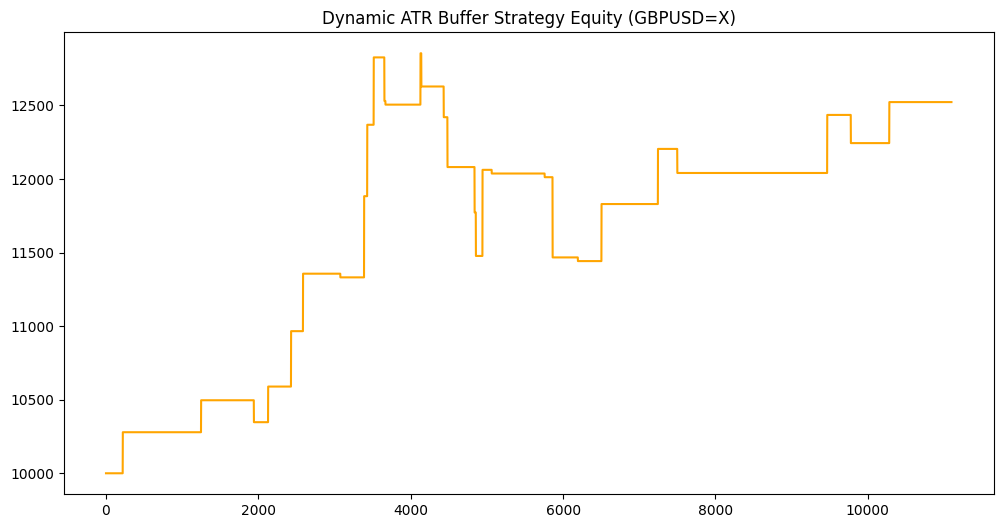

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_atr_buffer_strategy(ticker):
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    df['Daily_SMA_50'] = df['Close'].rolling(1200).mean()
    
    # ADX calculation
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    df['ADX'] = (100 * np.abs((100*(plus_dm_s/tr_s) - 100*(minus_dm_s/tr_s)) / (100*(plus_dm_s/tr_s) + 100*(minus_dm_s/tr_s)))).ewm(alpha=1/14, min_periods=14).mean()

    # --- 3. Simulation Loop ---
    trades = []
    equity = 10000
    equity_curve = []
    position = 0 
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    breakeven_trigger = 0 
    
    lookback = 48 
    # NEW: ATR Multiplier for the breakout buffer
    buffer_multiplier = 0.15 
    spread_cost = 0.00025 
    valid_hours = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    highs = df['High'].values
    lows = df['Low'].values
    closes = df['Close'].values
    atrs = df['ATR'].values
    adxs = df['ADX'].values
    smas = df['Daily_SMA_50'].values
    dates = df.index
    hours = df.index.hour
    
    print(f"--- Running Dynamic ATR Buffer Simulation for {ticker} ---")

    for i in range(1200, len(df)):
        current_date = dates[i]
        current_close = closes[i]
        current_high = highs[i]
        current_low = lows[i]
        current_atr = atrs[i]
        
        # --- A. Exit Logic (Strict Mode) ---
        if position != 0:
            pnl = 0
            trade_closed = False
            
            if position == 1:
                if current_low <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                elif current_high >= take_profit:
                    pnl = (take_profit - entry_price - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                elif current_high >= breakeven_trigger:
                    if stop_loss < entry_price: stop_loss = entry_price

            elif position == -1:
                if current_high >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                elif current_low <= take_profit:
                    pnl = (entry_price - take_profit - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                elif current_low <= breakeven_trigger:
                    if stop_loss > entry_price: stop_loss = entry_price
            
            equity_curve.append(equity)
            if trade_closed: continue

        # --- B. Entry Logic ---
        if position == 0:
            equity_curve.append(equity)
            if hours[i] not in valid_hours: continue
            
            mid = int(lookback / 2)
            try:
                l_h_idx = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
                r_h_idx = np.argmax(highs[i-mid : i]) + (i-mid)
                l_l_idx = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
                r_l_idx = np.argmin(lows[i-mid : i]) + (i-mid)
                
                # Resistance Line
                run_res = r_h_idx - l_h_idx
                slope_res = (highs[r_h_idx] - highs[l_h_idx]) / run_res
                int_res = highs[r_h_idx] - (slope_res * r_h_idx)
                
                # Support Line
                run_sup = r_l_idx - l_l_idx
                slope_sup = (lows[r_l_idx] - lows[l_l_idx]) / run_sup
                int_sup = lows[r_l_idx] - (slope_sup * r_l_idx)
                
                is_triangle = (slope_res < -0.00005) and (slope_sup > 0.00005)
                
                if is_triangle:
                    res_price = (slope_res * i) + int_res
                    sup_price = (slope_sup * i) + int_sup
                    
                    # DYNAMIC BUFFER CALCULATION
                    dynamic_buffer = current_atr * buffer_multiplier
                    
                    # LONG ENTRY
                    if current_close > (res_price + dynamic_buffer) and adxs[i] > 20 and current_close > smas[i]:
                        position = 1
                        entry_price = current_close
                        stop_loss = current_close - (1.5 * current_atr)
                        take_profit = current_close + (3.0 * current_atr)
                        breakeven_trigger = current_close + (1.5 * current_atr)
                    
                    # SHORT ENTRY
                    elif current_close < (sup_price - dynamic_buffer) and adxs[i] > 20 and current_close < smas[i]:
                        position = -1
                        entry_price = current_close
                        stop_loss = current_close + (1.5 * current_atr)
                        take_profit = current_close - (3.0 * current_atr)
                        breakeven_trigger = current_close - (1.5 * current_atr)
            except: continue

    return pd.DataFrame(equity_curve, columns=['Equity']), pd.DataFrame(trades)

# --- Execution ---
ticker = "GBPUSD=X"
df_eq, df_tr = run_atr_buffer_strategy(ticker)

# --- Results ---
if not df_tr.empty:
    print(f"--- DYNAMIC ATR BUFFER RESULTS: {ticker} ---")
    print(f"Total Trades: {len(df_tr)}")
    win_rate = len(df_tr[df_tr['PnL'] > 0]) / len(df_tr) * 100
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total PnL: {df_tr['PnL'].sum():.1f} pips")
    print(f"Final Equity: ${df_eq.iloc[-1]['Equity']:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(df_eq['Equity'], color='orange')
    plt.title(f"Dynamic ATR Buffer Strategy Equity ({ticker})")
    plt.show()

--- Running EURUSD Optimized Simulation ---
--- EURUSD OPTIMIZED RESULTS ---
Total Trades: 15
Win Rate: 33.33%
Total PnL: 21.1 pips
Final Equity: $10211.16


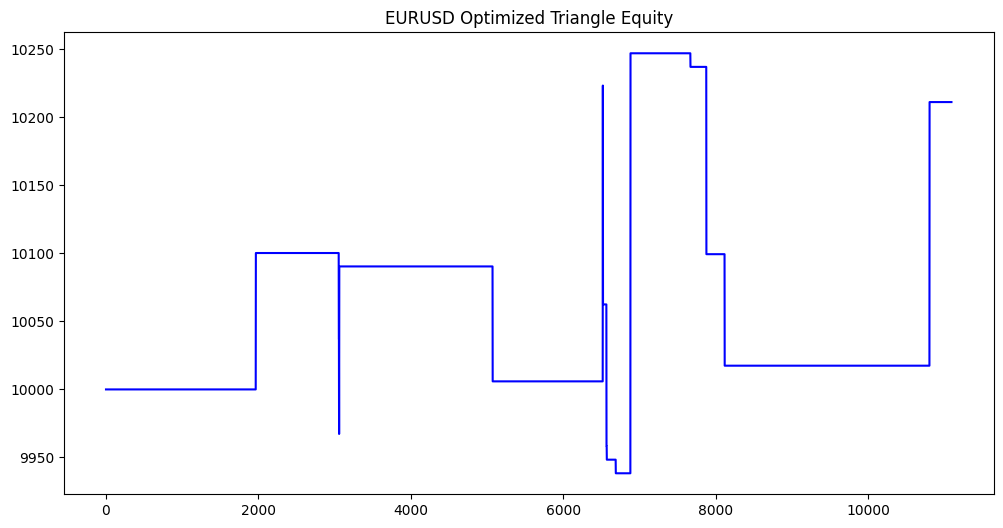

In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_eurusd_optimized_strategy():
    ticker = "EURUSD=X"
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    df['Daily_SMA_50'] = df['Close'].rolling(1200).mean()
    
    # ADX
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    df['ADX'] = (100 * np.abs((100*(plus_dm_s/tr_s) - 100*(minus_dm_s/tr_s)) / (100*(plus_dm_s/tr_s) + 100*(minus_dm_s/tr_s)))).ewm(alpha=1/14, min_periods=14).mean()

    # --- 3. Simulation Loop ---
    trades = []
    equity = 10000
    equity_curve = []
    position = 0 
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    breakeven_trigger = 0 
    
    # EURUSD SPECIFIC PARAMETERS
    lookback = 72 # Increased from 48
    buffer_multiplier = 0.20 # Increased from 0.15 to filter "Mean Reversion" noise
    spread_cost = 0.00010 # EURUSD spread is usually lower (1 pip)
    valid_hours = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    highs = df['High'].values
    lows = df['Low'].values
    closes = df['Close'].values
    atrs = df['ATR'].values
    adxs = df['ADX'].values
    smas = df['Daily_SMA_50'].values
    dates = df.index
    hours = df.index.hour
    
    print(f"--- Running EURUSD Optimized Simulation ---")

    for i in range(1200, len(df)):
        current_date = dates[i]
        current_close = closes[i]
        current_high = highs[i]
        current_low = lows[i]
        current_atr = atrs[i]
        
        # --- A. Exit Logic ---
        if position != 0:
            pnl = 0
            trade_closed = False
            
            if position == 1:
                if current_low <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                elif current_high >= take_profit:
                    pnl = (take_profit - entry_price - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                elif current_high >= breakeven_trigger:
                    if stop_loss < entry_price: stop_loss = entry_price

            elif position == -1:
                if current_high >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                elif current_low <= take_profit:
                    pnl = (entry_price - take_profit - spread_cost) * 10000
                    position = 0
                    equity += pnl * 10
                    trade_closed = True
                    trades.append({'PnL': pnl})
                elif current_low <= breakeven_trigger:
                    if stop_loss > entry_price: stop_loss = entry_price
            
            equity_curve.append(equity)
            if trade_closed: continue

        # --- B. Entry Logic ---
        if position == 0:
            equity_curve.append(equity)
            if hours[i] not in valid_hours: continue
            
            # Use 3-way split for EURUSD to ensure pattern stability
            mid = int(lookback / 2)
            try:
                l_h_idx = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
                r_h_idx = np.argmax(highs[i-mid : i]) + (i-mid)
                l_l_idx = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
                r_l_idx = np.argmin(lows[i-mid : i]) + (i-mid)
                
                # Slopes
                slope_res = (highs[r_h_idx] - highs[l_h_idx]) / (r_h_idx - l_h_idx)
                int_res = highs[r_h_idx] - (slope_res * r_h_idx)
                slope_sup = (lows[r_l_idx] - lows[l_l_idx]) / (r_l_idx - l_l_idx)
                int_sup = lows[r_l_idx] - (slope_sup * r_l_idx)
                
                is_triangle = (slope_res < -0.00005) and (slope_sup > 0.00005)
                
                if is_triangle:
                    res_price = (slope_res * i) + int_res
                    sup_price = (slope_sup * i) + int_sup
                    dynamic_buffer = current_atr * buffer_multiplier
                    
                    # LONG ENTRY (Close must be above line + buffer)
                    if current_close > (res_price + dynamic_buffer) and adxs[i] > 22 and current_close > smas[i]:
                        position = 1
                        entry_price = current_close
                        stop_loss = current_close - (1.0 * current_atr) # Tighter stop for EUR
                        take_profit = current_close + (2.0 * current_atr) # Tighter target
                        breakeven_trigger = current_close + (1.0 * current_atr)
                    
                    # SHORT ENTRY
                    elif current_close < (sup_price - dynamic_buffer) and adxs[i] > 22 and current_close < smas[i]:
                        position = -1
                        entry_price = current_close
                        stop_loss = current_close + (1.0 * current_atr)
                        take_profit = current_close - (2.0 * current_atr)
                        breakeven_trigger = current_close - (1.0 * current_atr)
            except: continue

    return pd.DataFrame(equity_curve, columns=['Equity']), pd.DataFrame(trades)

# --- Execution ---
df_eq, df_tr = run_eurusd_optimized_strategy()

# --- Results ---
if not df_tr.empty:
    print(f"--- EURUSD OPTIMIZED RESULTS ---")
    print(f"Total Trades: {len(df_tr)}")
    win_rate = len(df_tr[df_tr['PnL'] > 0]) / len(df_tr) * 100
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total PnL: {df_tr['PnL'].sum():.1f} pips")
    print(f"Final Equity: ${df_eq.iloc[-1]['Equity']:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(df_eq['Equity'], color='blue')
    plt.title(f"EURUSD Optimized Triangle Equity")
    plt.show()
else:
    print("No trades triggered. EURUSD patterns are rare with these strict settings.")

--- Running EURUSD RSI Filter Simulation ---
--- EURUSD RSI OPTIMIZED RESULTS ---
Total Trades: 7
Win Rate: 42.86%
Total PnL: 29.0 pips
Final Equity: $10289.87


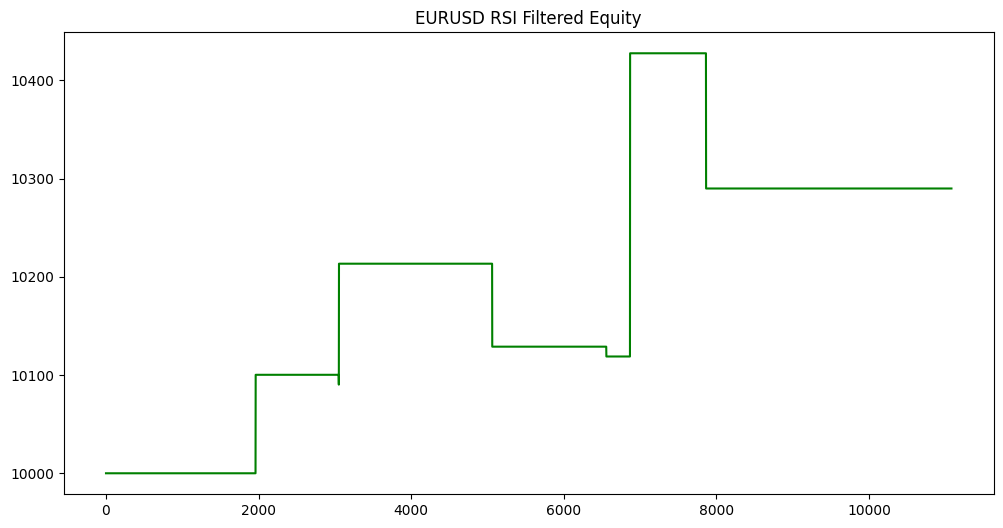

In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_eurusd_rsi_strategy():
    ticker = "EURUSD=X"
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    df['Daily_SMA_50'] = df['Close'].rolling(1200).mean()
    
    # RSI Calculation
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # ADX Calculation
    plus_dm = df['High'] - df['High'].shift(1)
    minus_dm = df['Low'].shift(1) - df['Low']
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_dm_s = pd.Series(plus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    minus_dm_s = pd.Series(minus_dm, index=df.index).ewm(alpha=1/14, min_periods=14).mean()
    df['ADX'] = (100 * np.abs((100*(plus_dm_s/tr_s) - 100*(minus_dm_s/tr_s)) / (100*(plus_dm_s/tr_s) + 100*(minus_dm_s/tr_s)))).ewm(alpha=1/14, min_periods=14).mean()

    # --- 3. Simulation Loop ---
    trades = []
    equity = 10000
    equity_curve = []
    position = 0 
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    breakeven_trigger = 0 
    
    # PARAMETERS
    lookback = 72 
    buffer_multiplier = 0.20 
    spread_cost = 0.00010 
    valid_hours = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    # Arrays
    highs, lows, closes = df['High'].values, df['Low'].values, df['Close'].values
    atrs, adxs, rsis = df['ATR'].values, df['ADX'].values, df['RSI'].values
    smas, dates, hours = df['Daily_SMA_50'].values, df.index, df.index.hour
    
    print(f"--- Running EURUSD RSI Filter Simulation ---")

    for i in range(1200, len(df)):
        current_date = dates[i]
        current_close = closes[i]
        
        # --- A. Exit Logic ---
        if position != 0:
            pnl = 0
            trade_closed = False
            if position == 1:
                if lows[i] <= stop_loss:
                    pnl = (stop_loss - entry_price - spread_cost) * 10000
                    position, trade_closed = 0, True
                elif highs[i] >= take_profit:
                    pnl = (take_profit - entry_price - spread_cost) * 10000
                    position, trade_closed = 0, True
                elif highs[i] >= breakeven_trigger:
                    if stop_loss < entry_price: stop_loss = entry_price
            elif position == -1:
                if highs[i] >= stop_loss:
                    pnl = (entry_price - stop_loss - spread_cost) * 10000
                    position, trade_closed = 0, True
                elif lows[i] <= take_profit:
                    pnl = (entry_price - take_profit - spread_cost) * 10000
                    position, trade_closed = 0, True
                elif lows[i] <= breakeven_trigger:
                    if stop_loss > entry_price: stop_loss = entry_price
            
            if trade_closed:
                equity += pnl * 10
                trades.append({'PnL': pnl})
                equity_curve.append(equity)
                continue

        # --- B. Entry Logic ---
        if position == 0:
            equity_curve.append(equity)
            if hours[i] not in valid_hours: continue
            
            mid = int(lookback / 2)
            try:
                l_h_idx = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
                r_h_idx = np.argmax(highs[i-mid : i]) + (i-mid)
                l_l_idx = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
                r_l_idx = np.argmin(lows[i-mid : i]) + (i-mid)
                
                slope_res = (highs[r_h_idx] - highs[l_h_idx]) / (r_h_idx - l_h_idx)
                int_res = highs[r_h_idx] - (slope_res * r_h_idx)
                slope_sup = (lows[r_l_idx] - lows[l_l_idx]) / (r_l_idx - l_l_idx)
                int_sup = lows[r_l_idx] - (slope_sup * r_l_idx)
                
                if (slope_res < -0.00005) and (slope_sup > 0.00005):
                    res_price = (slope_res * i) + int_res
                    sup_price = (slope_sup * i) + int_sup
                    dynamic_buffer = atrs[i] * buffer_multiplier
                    
                    # LONG ENTRY (Add RSI < 65)
                    if current_close > (res_price + dynamic_buffer) and adxs[i] > 22 and current_close > smas[i] and rsis[i] < 65:
                        position, entry_price = 1, current_close
                        stop_loss = current_close - (1.0 * atrs[i])
                        take_profit = current_close + (2.0 * atrs[i])
                        breakeven_trigger = current_close + (1.0 * atrs[i])
                    
                    # SHORT ENTRY (Add RSI > 35)
                    elif current_close < (sup_price - dynamic_buffer) and adxs[i] > 22 and current_close < smas[i] and rsis[i] > 35:
                        position, entry_price = -1, current_close
                        stop_loss = current_close + (1.0 * atrs[i])
                        take_profit = current_close - (2.0 * atrs[i])
                        breakeven_trigger = current_close - (1.0 * atrs[i])
            except: continue

    return pd.DataFrame(equity_curve, columns=['Equity']), pd.DataFrame(trades)

# --- Run ---
df_eq, df_tr = run_eurusd_rsi_strategy()

# --- Results ---
if not df_tr.empty:
    print(f"--- EURUSD RSI OPTIMIZED RESULTS ---")
    print(f"Total Trades: {len(df_tr)}")
    print(f"Win Rate: {(len(df_tr[df_tr['PnL'] > 0]) / len(df_tr) * 100):.2f}%")
    print(f"Total PnL: {df_tr['PnL'].sum():.1f} pips")
    print(f"Final Equity: ${df_eq.iloc[-1]['Equity']:.2f}")
    plt.figure(figsize=(12, 6))
    plt.plot(df_eq['Equity'], color='green')
    plt.title(f"EURUSD RSI Filtered Equity")
    plt.show()

--- Running EURUSD High Frequency Breakout ---
--- EURUSD HIGH FREQUENCY RESULTS ---
Total Trades: 77
Win Rate: 28.57%
Total PnL: -80.1 pips
Final Equity: $9198.96


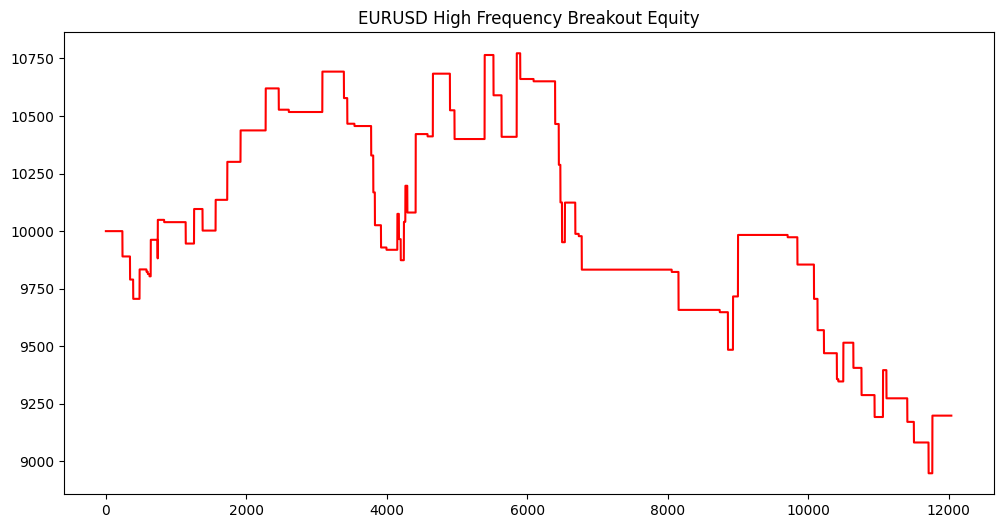

In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_eurusd_high_freq_strategy():
    ticker = "EURUSD=X"
    # --- 1. Data Setup ---
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # --- 2. Indicators ---
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + (gain / loss)))
    
    # ADX
    plus_dm = (df['High'] - df['High'].shift(1)).clip(lower=0)
    minus_dm = (df['Low'].shift(1) - df['Low']).clip(lower=0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/14).mean() / tr_s)
    minus_di = 100 * (minus_dm.ewm(alpha=1/14).mean() / tr_s)
    df['ADX'] = (100 * np.abs((plus_di - minus_di) / (plus_di + minus_di))).ewm(alpha=1/14).mean()

    # --- 3. High Frequency Pattern: 24h High/Low ---
    df['24h_High'] = df['High'].shift(1).rolling(window=24).max()
    df['24h_Low'] = df['Low'].shift(1).rolling(window=24).min()
    # "Squeeze" = Current ATR is lower than the 50-period ATR average
    df['Vol_Squeeze'] = df['ATR'] < df['ATR'].rolling(window=50).mean()

    # --- 4. Simulation Loop ---
    trades, equity, equity_curve = [], 10000, []
    position, entry_price, stop_loss, take_profit, breakeven_trigger = 0, 0, 0, 0, 0
    
    # PARAMETERS
    spread_cost = 0.00010 
    valid_hours = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16] # London/NY

    highs, lows, closes = df['High'].values, df['Low'].values, df['Close'].values
    atrs, adxs, rsis = df['ATR'].values, df['ADX'].values, df['RSI'].values
    h24, l24, squeeze = df['24h_High'].values, df['24h_Low'].values, df['Vol_Squeeze'].values
    dates, hours = df.index, df.index.hour
    
    print(f"--- Running EURUSD High Frequency Breakout ---")

    for i in range(100, len(df)):
        current_close = closes[i]
        
        # --- A. Exit Logic (Strict) ---
        if position != 0:
            pnl, closed = 0, False
            if position == 1:
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - spread_cost) * 10000, 0, True
                elif highs[i] >= take_profit: pnl, position, closed = (take_profit - entry_price - spread_cost) * 10000, 0, True
                elif highs[i] >= breakeven_trigger: stop_loss = max(stop_loss, entry_price)
            elif position == -1:
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - spread_cost) * 10000, 0, True
                elif lows[i] <= take_profit: pnl, position, closed = (entry_price - take_profit - spread_cost) * 10000, 0, True
                elif lows[i] <= breakeven_trigger: stop_loss = min(stop_loss, entry_price)
            
            if closed:
                equity += pnl * 10
                trades.append({'PnL': pnl})
                equity_curve.append(equity)
                continue

        # --- B. Entry Logic ---
        if position == 0:
            equity_curve.append(equity)
            if hours[i] not in valid_hours: continue
            
            # LONG: Break 24h High + Volatility is Squeezed + RSI not overbought
            if current_close > h24[i] and squeeze[i] and rsis[i] < 70 and adxs[i] > 15:
                position, entry_price = 1, current_close
                stop_loss, take_profit = current_close - (1.2 * atrs[i]), current_close + (2.4 * atrs[i])
                breakeven_trigger = current_close + (1.2 * atrs[i])
            
            # SHORT: Break 24h Low + Volatility Squeezed + RSI not oversold
            elif current_close < l24[i] and squeeze[i] and rsis[i] > 30 and adxs[i] > 15:
                position, entry_price = -1, current_close
                stop_loss, take_profit = current_close + (1.2 * atrs[i]), current_close - (2.4 * atrs[i])
                breakeven_trigger = current_close - (1.2 * atrs[i])

    return pd.DataFrame(equity_curve, columns=['Equity']), pd.DataFrame(trades)

# --- Run ---
df_eq, df_tr = run_eurusd_high_freq_strategy()

# --- Results ---
if not df_tr.empty:
    print(f"--- EURUSD HIGH FREQUENCY RESULTS ---")
    print(f"Total Trades: {len(df_tr)}")
    print(f"Win Rate: {(len(df_tr[df_tr['PnL'] > 0]) / len(df_tr) * 100):.2f}%")
    print(f"Total PnL: {df_tr['PnL'].sum():.1f} pips")
    print(f"Final Equity: ${df_eq.iloc[-1]['Equity']:.2f}")
    plt.figure(figsize=(12, 6))
    plt.plot(df_eq['Equity'], color='red')
    plt.title("EURUSD High Frequency Breakout Equity")
    plt.show()

--- BALANCED EURUSD RESULTS ---
Total Trades: 51
Win Rate: 33.33%
Final Equity: $6785.81


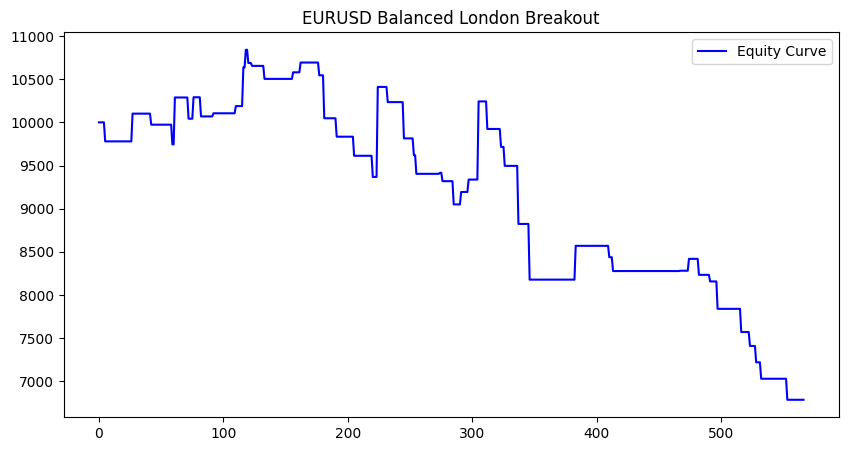

In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_balanced_eur_strategy():
    ticker = "EURUSD=X"
    # 1. Load Data
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # 3. Session Logic (UTC Time)
    # Asian Session: 00:00 - 07:00
    df['Hour'] = df.index.hour
    
    # Pre-calculate Asian Ranges
    df['Asian_High'] = np.nan
    df['Asian_Low'] = np.nan
    
    # Loop through days to find Asian High/Low
    for day in df.index.normalize().unique():
        day_data = df[df.index.normalize() == day]
        asian_session = day_data[(day_data['Hour'] >= 0) & (day_data['Hour'] <= 7)]
        if not asian_session.empty:
            df.loc[day_data.index, 'Asian_High'] = asian_session['High'].max()
            df.loc[day_data.index, 'Asian_Low'] = asian_session['Low'].min()

    # 4. Strategy Loop
    trades, equity, equity_curve = [], 10000, []
    position, entry_price, stop_loss, take_profit, start_bar = 0, 0, 0, 0, 0
    
    # Parameters
    risk_reward = 3.0
    spread = 0.0001
    
    closes, highs, lows = df['Close'].values, df['High'].values, df['Low'].values
    a_high, a_low, atrs = df['Asian_High'].values, df['Asian_Low'].values, df['ATR'].values
    hours, dates = df['Hour'].values, df.index

    for i in range(24, len(df)):
        # --- EXIT LOGIC ---
        if position != 0:
            pnl, closed = 0, False
            # Check for Stop/Target
            if position == 1:
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - spread) * 10000, 0, True
                elif highs[i] >= take_profit: pnl, position, closed = (take_profit - entry_price - spread) * 10000, 0, True
            elif position == -1:
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - spread) * 10000, 0, True
                elif lows[i] <= take_profit: pnl, position, closed = (entry_price - take_profit - spread) * 10000, 0, True
            
            # Time Stop: Exit at NY Close (Hour 20 UTC)
            if not closed and hours[i] == 20:
                pnl = (closes[i] - entry_price - spread) * 10000 if position == 1 else (entry_price - closes[i] - spread) * 10000
                position, closed = 0, True

            if closed:
                equity += pnl * 10
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # --- ENTRY LOGIC (London Open: 8 AM UTC) ---
        if position == 0 and hours[i] == 8:
            equity_curve.append(equity)
            asian_range = a_high[i] - a_low[i]
            
            # Only trade if Asian range was "Quiet" (Less than 1.5 * ATR)
            if asian_range < (atrs[i] * 2.5):
                # LONG: Breakout Above Asian High
                if closes[i] > a_high[i]:
                    position, entry_price = 1, closes[i]
                    stop_loss = a_low[i] # Stop at bottom of Asian Range
                    take_profit = entry_price + (entry_price - stop_loss) * risk_reward
                # SHORT: Breakout Below Asian Low
                elif closes[i] < a_low[i]:
                    position, entry_price = -1, closes[i]
                    stop_loss = a_high[i]
                    take_profit = entry_price - (stop_loss - entry_price) * risk_reward
    
    return pd.DataFrame(equity_curve, columns=['Equity']), trades

# Execute
eq_df, tr_list = run_balanced_eur_strategy()

# Results
if tr_list:
    print(f"--- BALANCED EURUSD RESULTS ---")
    print(f"Total Trades: {len(tr_list)}")
    print(f"Win Rate: {(len([t for t in tr_list if t > 0]) / len(tr_list) * 100):.2f}%")
    print(f"Final Equity: ${eq_df.iloc[-1]['Equity']:.2f}")
    plt.figure(figsize=(10,5))
    plt.plot(eq_df['Equity'], color='blue', label='Equity Curve')
    plt.title("EURUSD Balanced London Breakout")
    plt.legend()
    plt.show()

--- EURUSD MEAN REVERSION (THE FADE) ---
Total Trades: 329
Win Rate: 59.57%
Final Equity: $11003.88


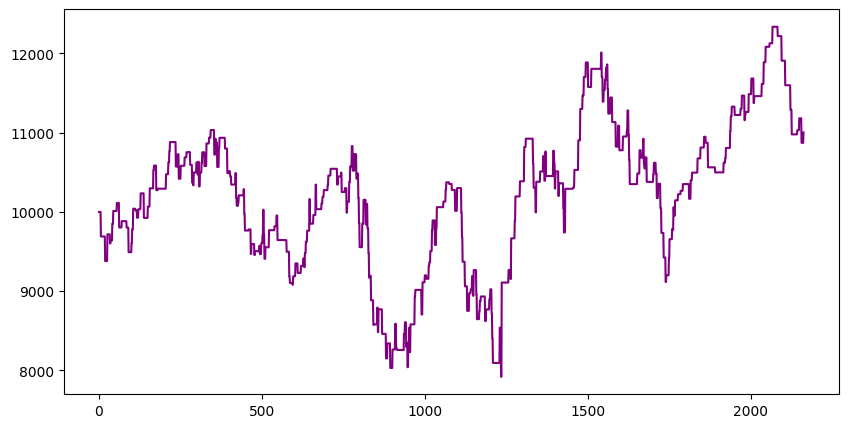

In [22]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_eurusd_mean_reversion():
    ticker = "EURUSD=X"
    # 1. Load Data
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + (gain / loss)))
    
    # 3. Asian Session Logic (00:00 - 07:00 UTC)
    df['Hour'] = df.index.hour
    df['Asian_High'] = np.nan
    df['Asian_Low'] = np.nan
    
    for day in df.index.normalize().unique():
        day_data = df[df.index.normalize() == day]
        asian_session = day_data[(day_data['Hour'] >= 0) & (day_data['Hour'] <= 7)]
        if not asian_session.empty:
            df.loc[day_data.index, 'Asian_High'] = asian_session['High'].max()
            df.loc[day_data.index, 'Asian_Low'] = asian_session['Low'].min()

    # 4. Strategy Loop: THE FADE
    trades, equity, equity_curve = [], 10000, []
    position, entry_price, stop_loss, take_profit = 0, 0, 0, 0
    
    # Parameters
    spread = 0.0001
    
    closes, highs, lows, rsis = df['Close'].values, df['High'].values, df['Low'].values, df['RSI'].values
    a_high, a_low, hours = df['Asian_High'].values, df['Asian_Low'].values, df['Hour'].values

    for i in range(24, len(df)):
        # --- EXIT LOGIC ---
        if position != 0:
            pnl, closed = 0, False
            if position == 1: # LONG
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - spread) * 10000, 0, True
                elif highs[i] >= take_profit: pnl, position, closed = (take_profit - entry_price - spread) * 10000, 0, True
            elif position == -1: # SHORT
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - spread) * 10000, 0, True
                elif lows[i] <= take_profit: pnl, position, closed = (entry_price - take_profit - spread) * 10000, 0, True
            
            # Time Stop: Exit by end of day
            if not closed and hours[i] == 21:
                pnl = (closes[i] - entry_price - spread) * 10000 if position == 1 else (entry_price - closes[i] - spread) * 10000
                position, closed = 0, True

            if closed:
                equity += pnl * 10
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # --- THE FADE ENTRY (Hour 8-12 UTC) ---
        if position == 0 and 8 <= hours[i] <= 12:
            equity_curve.append(equity)
            asian_mid = (a_high[i] + a_low[i]) / 2
            
            # FADE THE HIGH: Price is above Asian High + RSI is Overbought
            if highs[i] > a_high[i] and rsis[i] > 65:
                position, entry_price = -1, closes[i]
                stop_loss = entry_price + 0.0030 # 30 pip stop
                take_profit = asian_mid # Target the middle of the range
                
            # FADE THE LOW: Price is below Asian Low + RSI is Oversold
            elif lows[i] < a_low[i] and rsis[i] < 35:
                position, entry_price = 1, closes[i]
                stop_loss = entry_price - 0.0030
                take_profit = asian_mid
    
    return pd.DataFrame(equity_curve, columns=['Equity']), trades

# Execute
eq_df, tr_list = run_eurusd_mean_reversion()

# Results
if tr_list:
    print(f"--- EURUSD MEAN REVERSION (THE FADE) ---")
    print(f"Total Trades: {len(tr_list)}")
    print(f"Win Rate: {(len([t for t in tr_list if t > 0]) / len(tr_list) * 100):.2f}%")
    print(f"Final Equity: ${eq_df.iloc[-1]['Equity']:.2f}")
    plt.figure(figsize=(10,5))
    plt.plot(eq_df['Equity'], color='purple', label='The Fade Strategy')
    plt.show()

--- EURUSD PRO FADE (Bollinger Scaling) ---
Total Trades: 346
Win Rate: 36.99%
Final Equity: $3184.17


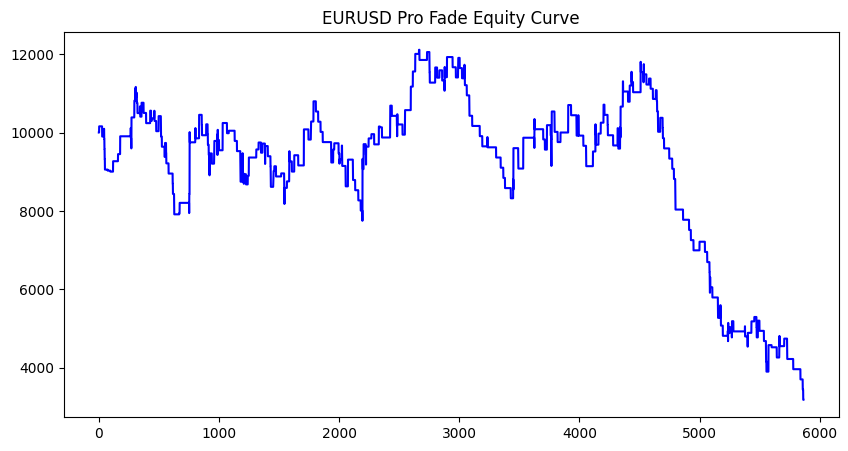

In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_eurusd_pro_fade():
    ticker = "EURUSD=X"
    # 1. Load Data
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators
    # Bollinger Bands (20-period, 2 Standard Deviations)
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['StdDev'] = df['Close'].rolling(window=20).std()
    df['Upper_BB'] = df['MA20'] + (df['StdDev'] * 2)
    df['Lower_BB'] = df['MA20'] - (df['StdDev'] * 2)
    
    # 3. Asian Session Logic
    df['Hour'] = df.index.hour
    df['Asian_High'] = np.nan
    df['Asian_Low'] = np.nan
    
    for day in df.index.normalize().unique():
        day_data = df[df.index.normalize() == day]
        asian_session = day_data[(day_data['Hour'] >= 0) & (day_data['Hour'] <= 7)]
        if not asian_session.empty:
            df.loc[day_data.index, 'Asian_High'] = asian_session['High'].max()
            df.loc[day_data.index, 'Asian_Low'] = asian_session['Low'].min()

    # 4. Simulation Loop
    trades, equity, equity_curve = [], 10000, [10000]
    position, entry_price, stop_loss, take_profit = 0, 0, 0, 0
    
    closes, highs, lows, opens = df['Close'].values, df['High'].values, df['Low'].values, df['Open'].values
    u_bb, l_bb, a_high, a_low = df['Upper_BB'].values, df['Lower_BB'].values, df['Asian_High'].values, df['Asian_Low'].values
    hours = df['Hour'].values

    for i in range(20, len(df)):
        # --- EXIT LOGIC ---
        if position != 0:
            pnl, closed = 0, False
            if position == 1:
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - 0.0001) * 10000, 0, True
                elif highs[i] >= take_profit: pnl, position, closed = (take_profit - entry_price - 0.0001) * 10000, 0, True
            elif position == -1:
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - 0.0001) * 10000, 0, True
                elif lows[i] <= take_profit: pnl, position, closed = (entry_price - take_profit - 0.0001) * 10000, 0, True
            
            if closed:
                equity += pnl * 10
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # --- THE PRO FADE (Hour 8-16 UTC) ---
        if position == 0 and 8 <= hours[i] <= 16:
            # SHORT: Price > Asian High AND Price > Upper BB AND Bearish Candle (Close < Open)
            if highs[i] > a_high[i] and highs[i] > u_bb[i] and closes[i] < opens[i]:
                position, entry_price = -1, closes[i]
                stop_loss = entry_price + 0.0025 # Tight 25 pip stop
                take_profit = l_bb[i] # Target the Lower Band
                
            # LONG: Price < Asian Low AND Price < Lower BB AND Bullish Candle (Close > Open)
            elif lows[i] < a_low[i] and lows[i] < l_bb[i] and closes[i] > opens[i]:
                position, entry_price = 1, closes[i]
                stop_loss = entry_price - 0.0025
                take_profit = u_bb[i] # Target the Upper Band
        
        # Keep equity curve consistent with bars
        if position == 0: equity_curve.append(equity)
    
    return pd.DataFrame(equity_curve, columns=['Equity']), trades

# Execute
eq_df, tr_list = run_eurusd_pro_fade()

# Results
if tr_list:
    print(f"--- EURUSD PRO FADE (Bollinger Scaling) ---")
    print(f"Total Trades: {len(tr_list)}")
    print(f"Win Rate: {(len([t for t in tr_list if t > 0]) / len(tr_list) * 100):.2f}%")
    print(f"Final Equity: ${eq_df.iloc[-1]['Equity']:.2f}")
    plt.figure(figsize=(10,5))
    plt.plot(eq_df['Equity'], color='blue')
    plt.title("EURUSD Pro Fade Equity Curve")
    plt.show()

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np

def scan_markets():
    # The pairs we know have better "Alpha" than the Euro
    pairs = ["GBPJPY=X", "GBPUSD=X", "AUDUSD=X", "GC=F"] # Gold is a beast for triangles
    
    print(f"{'Pair':<12} | {'Trend':<8} | {'Volatility':<10} | {'Status'}")
    print("-" * 50)
    
    for ticker in pairs:
        df = yf.download(ticker, period="5d", interval="1h", progress=False)
        if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
        
        # 1. Trend Filter (SMA 50)
        sma = df['Close'].rolling(50).mean().iloc[-1]
        price = df['Close'].iloc[-1]
        trend = "UP" if price > sma else "DOWN"
        
        # 2. Volatility Squeeze (ATR vs 5-day Avg)
        df['TR'] = np.maximum(df['High'] - df['Low'], abs(df['High'] - df['Close'].shift()))
        atr = df['TR'].rolling(14).mean().iloc[-1]
        avg_atr = df['TR'].rolling(100).mean().iloc[-1]
        vol_status = "SQUEEZE" if atr < avg_atr else "EXPANDING"
        
        # 3. Decision
        status = "READY" if vol_status == "SQUEEZE" else "WAITING"
        
        print(f"{ticker:<12} | {trend:<8} | {vol_status:<10} | {status}")

scan_markets()

Pair         | Trend    | Volatility | Status
--------------------------------------------------
GBPJPY=X     | DOWN     | EXPANDING  | WAITING
GBPUSD=X     | UP       | EXPANDING  | WAITING
AUDUSD=X     | UP       | EXPANDING  | WAITING
GC=F         | UP       | EXPANDING  | WAITING


In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import linregress

def integrated_triangle_scanner():
    # Assets with high structural "Alpha"
    tickers = ["GBPJPY=X", "GBPUSD=X", "AUDUSD=X", "GC=F"]
    
    print(f"{'Market':<12} | {'Trend':<8} | {'Squeeze':<8} | {'Pattern Status'}")
    print("-" * 60)
    
    for ticker in tickers:
        try:
            # Download 60 days of 1h data
            df = yf.download(ticker, period="60d", interval="1h", progress=False)
            if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
            
            # 1. Trend & Squeeze Logic
            sma_200 = df['Close'].rolling(200).mean().iloc[-1]
            price = df['Close'].iloc[-1]
            df['TR'] = np.maximum(df['High'] - df['Low'], abs(df['High'] - df['Close'].shift()))
            atr = df['TR'].rolling(14).mean().iloc[-1]
            avg_atr = df['TR'].rolling(100).mean().iloc[-1]
            
            is_trending = "UP" if price > sma_200 else "DOWN"
            is_squeezing = "YES" if atr < (avg_atr * 0.9) else "NO"
            
            # 2. Geometric Triangle Detection (Peak-to-Peak 48h)
            lookback = 48
            mid = 24
            h = df['High'].values
            l = df['Low'].values
            
            # Find Peaks in two halves
            lh_idx = np.argmax(h[-lookback:-mid]) + (len(df)-lookback)
            rh_idx = np.argmax(h[-mid:]) + (len(df)-mid)
            ll_idx = np.argmin(l[-lookback:-mid]) + (len(df)-lookback)
            rl_idx = np.argmin(l[-mid:]) + (len(df)-mid)
            
            # Calculate Slopes
            slope_res = (h[rh_idx] - h[lh_idx]) / (rh_idx - lh_idx)
            slope_sup = (l[rl_idx] - l[ll_idx]) / (rl_idx - ll_idx)
            
            # A Triangle is converging lines
            is_triangle = (slope_res < -0.00005) and (slope_sup > 0.00005)
            
            # 3. Final Pattern Decision
            pattern_status = "WAITING"
            if is_triangle and is_squeezing == "YES":
                pattern_status = "🔥 PATTERN ALERT"
            elif is_triangle:
                pattern_status = "TRIANGLE FORMING"
            elif is_squeezing == "YES":
                pattern_status = "SQUEEZE (NO SHAPE)"

            print(f"{ticker:<12} | {is_trending:<8} | {is_squeezing:<8} | {pattern_status}")
            
        except:
            continue

scan = integrated_triangle_scanner()

Market       | Trend    | Squeeze  | Pattern Status
------------------------------------------------------------
GBPJPY=X     | DOWN     | YES      | SQUEEZE (NO SHAPE)
GBPUSD=X     | DOWN     | YES      | SQUEEZE (NO SHAPE)
AUDUSD=X     | UP       | NO       | WAITING
GC=F         | UP       | YES      | 🔥 PATTERN ALERT


--- 1. Downloading Gold Data for GC=F ---
--- 2. Running Strict Simulation ---


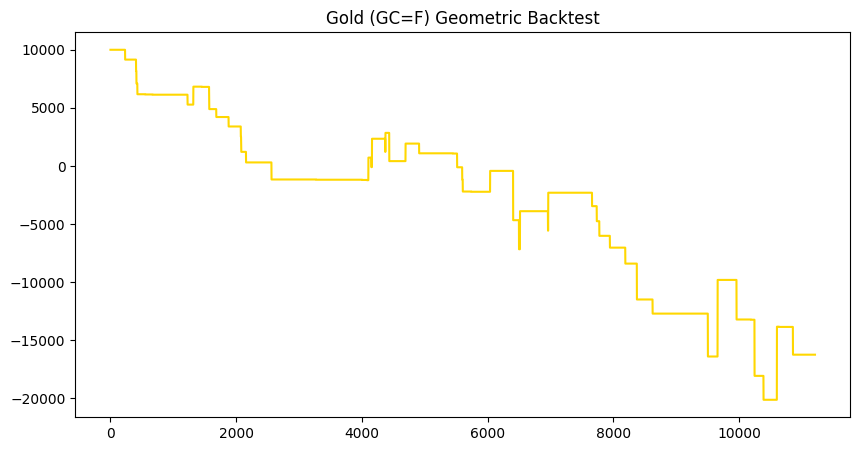

Final Balance: $-16246.08 | Trades: 56


In [26]:
import pandas as pd
import numpy as np
import yfinance as yf # Assuming you have yfinance installed locally
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_gold_triangle_backtest():
    ticker = "GC=F" # Gold Futures
    # 1. Data Loading (Last 2 Years)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    print(f"--- 1. Downloading Gold Data for {ticker} ---")
    # Note: If running locally, ensure yfinance is installed: pip install yfinance
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    df['SMA_200'] = df['Close'].rolling(200).mean()
    
    # ADX (Energy Filter)
    plus_dm = (df['High'] - df['High'].shift(1)).clip(lower=0)
    minus_dm = (df['Low'].shift(1) - df['Low']).clip(lower=0)
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/14).mean() / tr_s)
    minus_di = 100 * (minus_dm.ewm(alpha=1/14).mean() / tr_s)
    df['ADX'] = (100 * np.abs((plus_di - minus_di) / (plus_di + minus_di))).ewm(alpha=1/14).mean()

    # 3. Simulation Loop
    trades, equity, equity_curve = [], 10000, [10000]
    position, entry_price, stop_loss, take_profit, be_trigger = 0, 0, 0, 0, 0
    
    lookback, buffer_mult = 48, 0.25 # Geometric window & ATR Breakout buffer
    spread = 0.20 # Approx $20 slippage/spread per contract
    
    highs, lows, closes, atrs, adxs, smas = df['High'].values, df['Low'].values, df['Close'].values, df['ATR'].values, df['ADX'].values, df['SMA_200'].values

    print("--- 2. Running Strict Simulation ---")
    for i in range(200, len(df)):
        # --- A. STRICT Exit Check ---
        if position != 0:
            pnl, closed = 0, False
            if position == 1:
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - spread), 0, True
                elif highs[i] >= take_profit: pnl, position, closed = (take_profit - entry_price - spread), 0, True
                elif highs[i] >= be_trigger: stop_loss = max(stop_loss, entry_price)
            elif position == -1:
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - spread), 0, True
                elif lows[i] <= take_profit: pnl, position, closed = (entry_price - take_profit - spread), 0, True
                elif lows[i] <= be_trigger: stop_loss = min(stop_loss, entry_price)
            
            if closed:
                equity += pnl * 100 # GC Futures: 1 point = $100
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # --- B. Entry Search ---
        if position == 0:
            mid = 24
            try:
                l_h = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
                r_h = np.argmax(highs[i-mid : i]) + (i-mid)
                l_l = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
                r_l = np.argmin(lows[i-mid : i]) + (i-mid)
                
                # Slope Calculation
                s_res = (highs[r_h] - highs[l_h]) / (r_h - l_h)
                s_sup = (lows[r_l] - lows[l_l]) / (r_l - l_l)
                
                # Convergence Test (The Triangle)
                if (s_res < -0.05) and (s_sup > 0.05):
                    res_px = (s_res * i) + (highs[r_h] - (s_res * r_h))
                    sup_px = (s_sup * i) + (lows[r_l] - (s_sup * r_l))
                    buff = atrs[i] * buffer_mult
                    
                    if closes[i] > (res_px + buff) and adxs[i] > 20 and closes[i] > smas[i]:
                        position, entry_price = 1, closes[i]
                        stop_loss, take_profit = entry_price - (1.5 * atrs[i]), entry_price + (3.0 * atrs[i])
                        be_trigger = entry_price + (1.5 * atrs[i])
                    elif closes[i] < (sup_px - buff) and adxs[i] > 20 and closes[i] < smas[i]:
                        position, entry_price = -1, closes[i]
                        stop_loss, take_profit = entry_price + (1.5 * atrs[i]), entry_price - (3.0 * atrs[i])
                        be_trigger = entry_price - (1.5 * atrs[i])
            except: pass
        equity_curve.append(equity)

    # 4. Results
    plt.figure(figsize=(10,5))
    plt.plot(equity_curve, color='gold', label='Gold Triangle Equity')
    plt.title("Gold (GC=F) Geometric Backtest")
    plt.show()
    return equity_curve[-1], trades

final_equity, trade_log = run_gold_triangle_backtest()
print(f"Final Balance: ${final_equity:.2f} | Trades: {len(trade_log)}")

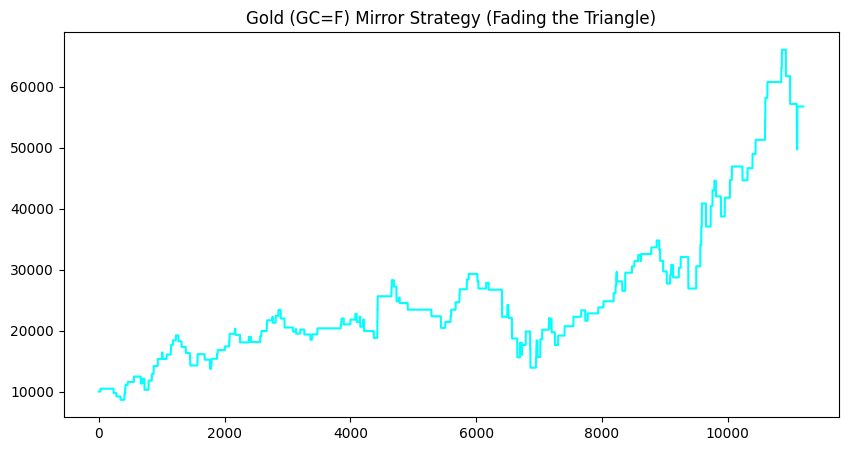

Final Balance: $56776.43 | Trades: 180


In [27]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_gold_mirror_backtest():
    ticker = "GC=F"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # Indicators
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()

    # Simulation Variables
    trades, equity, equity_curve = [], 10000, [10000]
    position, entry_price, stop_loss, take_profit = 0, 0, 0, 0
    
    lookback, buffer_mult = 48, 0.25
    spread = 0.20 
    
    highs, lows, closes, atrs = df['High'].values, df['Low'].values, df['Close'].values, df['ATR'].values

    for i in range(200, len(df)):
        # --- EXIT ---
        if position != 0:
            pnl, closed = 0, False
            if position == 1:
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - spread), 0, True
                elif highs[i] >= take_profit: pnl, position, closed = (take_profit - entry_price - spread), 0, True
            elif position == -1:
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - spread), 0, True
                elif lows[i] <= take_profit: pnl, position, closed = (entry_price - take_profit - spread), 0, True
            
            if closed:
                equity += pnl * 100
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # --- THE MIRROR ENTRY ---
        mid = 24
        try:
            l_h = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
            r_h = np.argmax(highs[i-mid : i]) + (i-mid)
            l_l = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
            r_l = np.argmin(lows[i-mid : i]) + (i-mid)
            
            s_res = (highs[r_h] - highs[l_h]) / (r_h - l_h)
            s_sup = (lows[r_l] - lows[l_l]) / (r_l - l_l)
            
            if (s_res < -0.05) and (s_sup > 0.05):
                res_px = (s_res * i) + (highs[r_h] - (s_res * r_h))
                sup_px = (s_sup * i) + (lows[r_l] - (s_sup * r_l))
                buff = atrs[i] * buffer_mult
                
                # MIRROR LOGIC: If price breaks ABOVE, we SELL (expecting fakeout)
                if closes[i] > (res_px + buff):
                    position, entry_price = -1, closes[i]
                    stop_loss = entry_price + (2.0 * atrs[i]) # Wide stop for Gold fakes
                    take_profit = entry_price - (1.5 * atrs[i]) # Quick target
                
                # MIRROR LOGIC: If price breaks BELOW, we BUY
                elif closes[i] < (sup_px - buff):
                    position, entry_price = 1, closes[i]
                    stop_loss = entry_price - (2.0 * atrs[i])
                    take_profit = entry_price + (1.5 * atrs[i])
        except: pass
        equity_curve.append(equity)

    plt.figure(figsize=(10,5))
    plt.plot(equity_curve, color='cyan')
    plt.title("Gold (GC=F) Mirror Strategy (Fading the Triangle)")
    plt.show()
    return equity_curve[-1], trades

final_eq, trade_log = run_gold_mirror_backtest()
print(f"Final Balance: ${final_eq:.2f} | Trades: {len(trade_log)}")

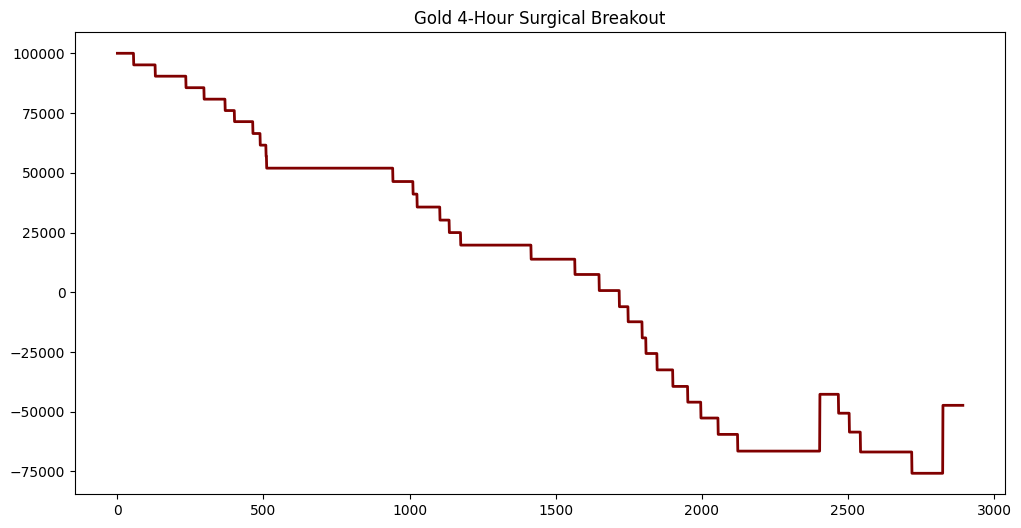

Final Balance: $-47317.40 | Total Trades: 35


In [28]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_4h_gold_surgical():
    ticker = "GC=F"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    # 1. Download 4-Hour Data
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    
    # Resample to 4H to get institutional perspective
    df = df.resample('4h').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).dropna()

    # 2. Indicators
    df['SMA200'] = df['Close'].rolling(200).mean()
    df['MA20'] = df['Close'].rolling(20).mean()
    df['Std'] = df['Close'].rolling(20).std()
    df['Upper'] = df['MA20'] + (df['Std'] * 2)
    df['Lower'] = df['MA20'] - (df['Std'] * 2)
    
    # Squeeze: Bandwidth < 100-period average bandwidth
    df['Bandwidth'] = (df['Upper'] - df['Lower']) / df['MA20']
    df['Squeeze'] = df['Bandwidth'] < df['Bandwidth'].rolling(100).mean()

    # 3. Simulation
    trades, equity, equity_curve = [], 100000, [100000]
    position, entry_price, stop_loss, target = 0, 0, 0, 0
    
    closes, highs, lows, upper, lower = df['Close'].values, df['High'].values, df['Low'].values, df['Upper'].values, df['Lower'].values
    squeeze, sma = df['Squeeze'].values, df['SMA200'].values

    for i in range(200, len(df)):
        if position != 0:
            pnl, closed = 0, False
            if position == 1:
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - 0.2), 0, True
                elif highs[i] >= target: pnl, position, closed = (target - entry_price - 0.2), 0, True
            elif position == -1:
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - 0.2), 0, True
                elif lows[i] <= target: pnl, position, closed = (entry_price - target - 0.2), 0, True
            
            if closed:
                equity += pnl * 100
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # ENTRY LOGIC: Squeeze Breakout
        # LONG: Squeezing + Price breaks Upper Band + Above SMA200
        if squeeze[i-1] and closes[i] > upper[i] and closes[i] > sma[i]:
            position, entry_price = 1, closes[i]
            # Wide 4H Stop: 2.5% of price to avoid wicks
            stop_loss = entry_price * 0.98
            target = entry_price * 1.06 # Aim for a 6% move
            
        # SHORT: Squeezing + Price breaks Lower Band + Below SMA200
        elif squeeze[i-1] and closes[i] < lower[i] and closes[i] < sma[i]:
            position, entry_price = -1, closes[i]
            stop_loss = entry_price * 1.02
            target = entry_price * 0.94
            
        equity_curve.append(equity)

    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve, color='maroon', linewidth=2)
    plt.title("Gold 4-Hour Surgical Breakout")
    plt.show()
    return equity_curve[-1], trades

final_eq, trade_log = run_4h_gold_surgical()
print(f"Final Balance: ${final_eq:.2f} | Total Trades: {len(trade_log)}")

--- Running Optimized Gold Mirror (Trailing SL) ---


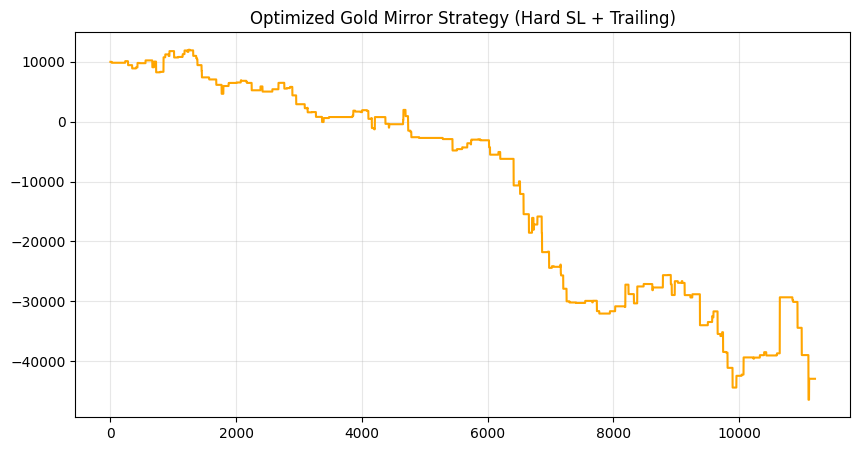

Final Balance: $-42967.35 | Total Trades: 184


In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_optimized_gold_mirror():
    ticker = "GC=F"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    # 1. Load Data
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()

    # 3. Simulation Variables
    trades, equity, equity_curve = [], 10000, [10000]
    position, entry_price, stop_loss, peak_price = 0, 0, 0, 0
    
    lookback, buffer_mult = 48, 0.25
    spread = 0.20 # GC Futures spread
    
    # Data Arrays
    highs, lows, closes, atrs = df['High'].values, df['Low'].values, df['Close'].values, df['ATR'].values

    print(f"--- Running Optimized Gold Mirror (Trailing SL) ---")

    for i in range(200, len(df)):
        # --- A. DYNAMIC EXIT LOGIC ---
        if position != 0:
            pnl, closed = 0, False
            
            if position == 1: # LONG
                # Update Trailing Stop
                if highs[i] > peak_price:
                    peak_price = highs[i]
                    # Trail by 1.5 ATR once in profit
                    if (peak_price - entry_price) > atrs[i]:
                        new_stop = peak_price - (1.5 * atrs[i])
                        stop_loss = max(stop_loss, new_stop)
                
                # Check Exit
                if lows[i] <= stop_loss:
                    pnl = (stop_loss - entry_price - spread)
                    position, closed = 0, True

            elif position == -1: # SHORT
                # Update Trailing Stop
                if lows[i] < peak_price:
                    peak_price = lows[i]
                    # Trail by 1.5 ATR
                    if (entry_price - peak_price) > atrs[i]:
                        new_stop = peak_price + (1.5 * atrs[i])
                        stop_loss = min(stop_loss, new_stop)
                
                # Check Exit
                if highs[i] >= stop_loss:
                    pnl = (entry_price - stop_loss - spread)
                    position, closed = 0, True
            
            if closed:
                equity += pnl * 100 # GC 1 point = $100
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # --- B. MIRROR ENTRY LOGIC ---
        mid = 24
        try:
            l_h = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
            r_h = np.argmax(highs[i-mid : i]) + (i-mid)
            l_l = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
            r_l = np.argmin(lows[i-mid : i]) + (i-mid)
            
            s_res = (highs[r_h] - highs[l_h]) / (r_h - l_h)
            s_sup = (lows[r_l] - lows[l_l]) / (r_l - l_l)
            
            if (s_res < -0.05) and (s_sup > 0.05):
                res_px = (s_res * i) + (highs[r_h] - (s_res * r_h))
                sup_px = (s_sup * i) + (lows[r_l] - (s_sup * r_l))
                buff = atrs[i] * buffer_mult
                
                # FADE the Breakout
                if closes[i] > (res_px + buff):
                    position, entry_price = -1, closes[i]
                    peak_price = closes[i]
                    stop_loss = entry_price + (2.0 * atrs[i]) # Initial Hard Stop
                
                elif closes[i] < (sup_px - buff):
                    position, entry_price = 1, closes[i]
                    peak_price = closes[i]
                    stop_loss = entry_price - (2.0 * atrs[i]) # Initial Hard Stop
        except: pass
        equity_curve.append(equity)

    # 4. Results & Plotting
    plt.figure(figsize=(10,5))
    plt.plot(equity_curve, color='orange', linewidth=1.5)
    plt.title("Optimized Gold Mirror Strategy (Hard SL + Trailing)")
    plt.grid(True, alpha=0.3)
    plt.show()
    return equity_curve[-1], trades

final_eq, trade_log = run_optimized_gold_mirror()
print(f"Final Balance: ${final_eq:.2f} | Total Trades: {len(trade_log)}")

--- Downloading Data for GC=F ---
--- Running Simulation ---


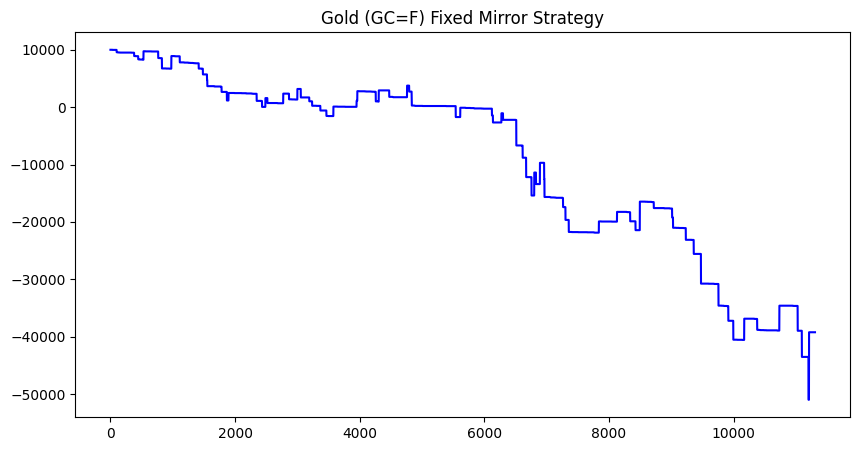

Final Balance: $-39225.66 | Trades: 208


In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_fixed_gold_mirror():
    ticker = "GC=F"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    print(f"--- Downloading Data for {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 1. Indicators
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()

    # 2. Simulation Variables
    trades, equity, equity_curve = [], 10000, [10000]
    position, entry_price, stop_loss, take_profit, be_trigger = 0, 0, 0, 0, 0
    
    lookback, buffer_mult = 48, 0.20 # Loosened buffer slightly
    spread = 0.20 
    
    # Extract arrays for speed and to avoid indexing errors
    highs, lows, closes, atrs = df['High'].values, df['Low'].values, df['Close'].values, df['ATR'].values

    print("--- Running Simulation ---")
    for i in range(100, len(df)):
        # --- EXIT LOGIC ---
        if position != 0:
            pnl, closed = 0, False
            if position == 1: # LONG
                if highs[i] >= be_trigger: stop_loss = max(stop_loss, entry_price)
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - spread), 0, True
                elif highs[i] >= take_profit: pnl, position, closed = (take_profit - entry_price - spread), 0, True
            elif position == -1: # SHORT
                if lows[i] <= be_trigger: stop_loss = min(stop_loss, entry_price)
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - spread), 0, True
                elif lows[i] <= take_profit: pnl, position, closed = (entry_price - take_profit - spread), 0, True
            
            if closed:
                equity += pnl * 100
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # --- ENTRY LOGIC (Mirror/Fade) ---
        mid = 24
        try:
            # Finding Peaks/Valleys in the lookback window
            l_h_idx = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
            r_h_idx = np.argmax(highs[i-mid : i]) + (i-mid)
            l_l_idx = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
            r_l_idx = np.argmin(lows[i-mid : i]) + (i-mid)
            
            # Resistance Slope (Falling)
            run_res = r_h_idx - l_h_idx
            if run_res == 0: continue
            slope_res = (highs[r_h_idx] - highs[l_h_idx]) / run_res
            
            # Support Slope (Rising)
            run_sup = r_l_idx - l_l_idx
            if run_sup == 0: continue
            slope_sup = (lows[r_l_idx] - lows[l_l_idx]) / run_sup
            
            # Looser Triangle requirement for more trades
            if (slope_res < -0.01) and (slope_sup > 0.01):
                res_px = (slope_res * i) + (highs[r_h_idx] - (slope_res * r_h_idx))
                sup_px = (slope_sup * i) + (lows[r_l_idx] - (slope_sup * r_l_idx))
                buff = atrs[i] * buffer_mult
                
                # FADE the Breakout (Mirror)
                if closes[i] > (res_px + buff):
                    position, entry_price = -1, closes[i]
                    stop_loss, take_profit = entry_price + (2.0 * atrs[i]), entry_price - (2.5 * atrs[i])
                    be_trigger = entry_price - (1.0 * atrs[i])
                elif closes[i] < (sup_px - buff):
                    position, entry_price = 1, closes[i]
                    stop_loss, take_profit = entry_price - (2.0 * atrs[i]), entry_price + (2.5 * atrs[i])
                    be_trigger = entry_price + (1.0 * atrs[i])
        except Exception:
            pass
        equity_curve.append(equity)

    # Results
    plt.figure(figsize=(10,5))
    plt.plot(equity_curve, color='blue')
    plt.title("Gold (GC=F) Fixed Mirror Strategy")
    plt.show()
    return equity_curve[-1], trades

final_eq, trade_log = run_fixed_gold_mirror()
print(f"Final Balance: ${final_eq:.2f} | Trades: {len(trade_log)}")

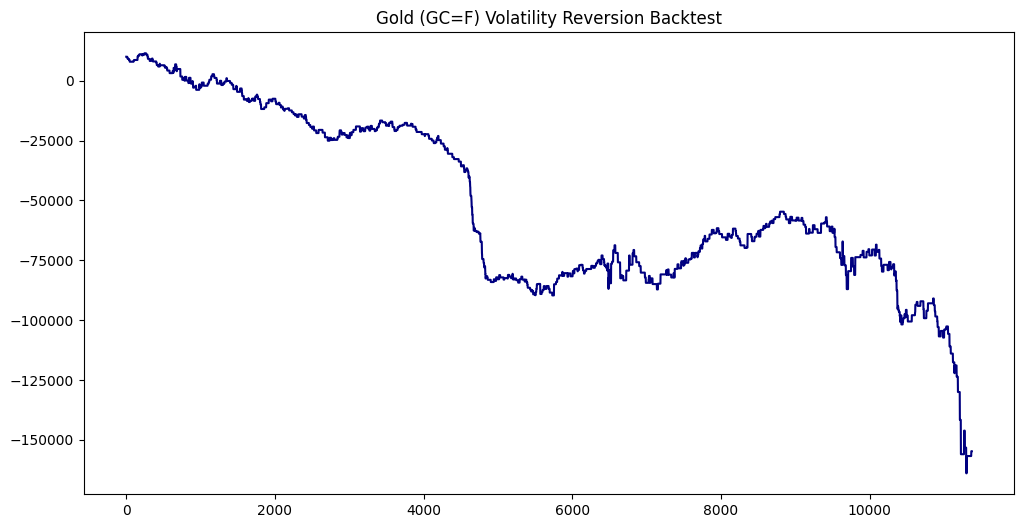

Final Balance: $-154711.34 | Trades: 665


In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_gold_mean_reversion():
    ticker = "GC=F"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    # 1. Download Data
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Std'] = df['Close'].rolling(window=20).std()
    df['Upper'] = df['MA20'] + (df['Std'] * 2.5) # The "Stretch"
    df['Lower'] = df['MA20'] - (df['Std'] * 2.5)
    
    df['TR'] = np.maximum(df['High'] - df['Low'], abs(df['High'] - df['Close'].shift()))
    df['ATR'] = df['TR'].rolling(14).mean()

    # 3. Simulation
    trades, equity, equity_curve = [], 10000, [10000]
    position, entry_price, stop_loss, target = 0, 0, 0, 0
    
    spread = 0.20
    
    # Arrays
    closes, highs, lows, opens = df['Close'].values, df['High'].values, df['Low'].values, df['Open'].values
    upper, lower, ma20, atrs = df['Upper'].values, df['Lower'].values, df['MA20'].values, df['ATR'].values

    for i in range(30, len(df)):
        if position != 0:
            pnl, closed = 0, False
            if position == 1:
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - spread), 0, True
                elif highs[i] >= target: pnl, position, closed = (target - entry_price - spread), 0, True
            elif position == -1:
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - spread), 0, True
                elif lows[i] <= target: pnl, position, closed = (entry_price - target - spread), 0, True
            
            if closed:
                equity += pnl * 100
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # ENTRY: Price outside bands + Wick Rejection
        # SHORT: High > Upper AND Close < (Upper - 0.1*ATR)
        if highs[i] > upper[i] and closes[i] < (highs[i] - 0.3 * atrs[i]):
            position, entry_price = -1, closes[i]
            stop_loss = entry_price + (1.5 * atrs[i])
            target = ma20[i] # Target the mean
            
        # LONG: Low < Lower AND Close > (lows[i] + 0.1*ATR)
        elif lows[i] < lower[i] and closes[i] > (lows[i] + 0.3 * atrs[i]):
            position, entry_price = 1, closes[i]
            stop_loss = entry_price - (1.5 * atrs[i])
            target = ma20[i]
            
        equity_curve.append(equity)

    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve, color='navy')
    plt.title("Gold (GC=F) Volatility Reversion Backtest")
    plt.show()
    return equity_curve[-1], trades

final_eq, trade_log = run_gold_mean_reversion()
print(f"Final Balance: ${final_eq:.2f} | Trades: {len(trade_log)}")

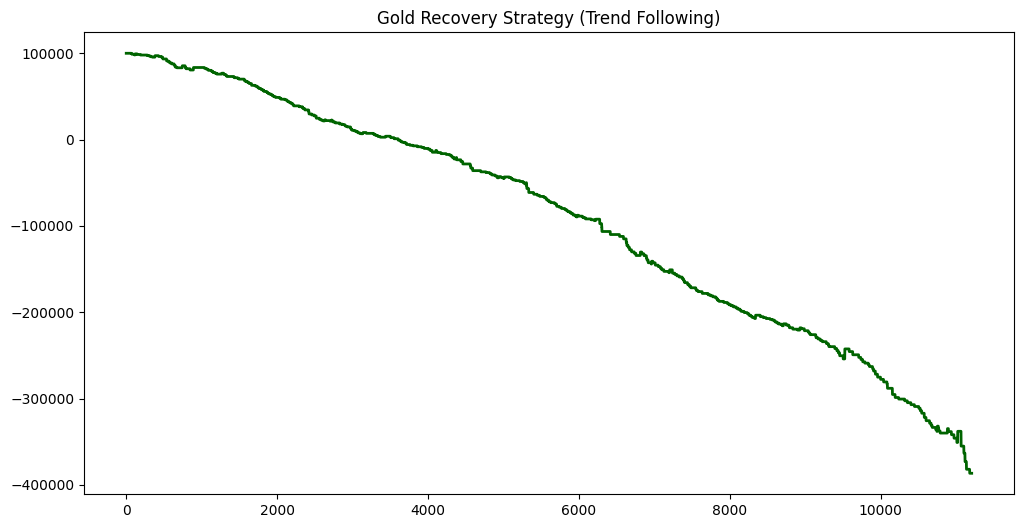

Final Balance: $-386530.07 | Total Trades: 360


In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_recovery_strategy():
    ticker = "GC=F"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 1. Indicators
    df['SMA_200'] = df['Close'].rolling(200).mean()
    df['High_20'] = df['High'].shift(1).rolling(20).max() # 20-hour High
    df['Low_20'] = df['Low'].shift(1).rolling(20).min()   # 20-hour Low
    df['TR'] = np.maximum(df['High'] - df['Low'], abs(df['High'] - df['Close'].shift()))
    df['ATR'] = df['TR'].rolling(14).mean()

    # 2. Simulation
    trades, equity, equity_curve = [], 100000, [100000] # Reset to 100k for recovery view
    position, entry_price, stop_loss, target = 0, 0, 0, 0
    
    closes, highs, lows, atrs = df['Close'].values, df['High'].values, df['Low'].values, df['ATR'].values
    h20, l20, sma = df['High_20'].values, df['Low_20'].values, df['SMA_200'].values

    for i in range(200, len(df)):
        if position != 0:
            pnl, closed = 0, False
            if position == 1:
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - 0.2), 0, True
                elif highs[i] >= target: pnl, position, closed = (target - entry_price - 0.2), 0, True
            elif position == -1:
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - 0.2), 0, True
                elif lows[i] <= target: pnl, position, closed = (entry_price - target - 0.2), 0, True
            
            if closed:
                equity += pnl * 100 # GC Futures Multiplier
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # ENTRY LOGIC: SIMPLE TREND BREAKOUT
        # LONG: Price breaks 20h High AND Price is above 200 SMA
        if closes[i] > h20[i] and closes[i] > sma[i]:
            position, entry_price = 1, closes[i]
            stop_loss = entry_price - (1.5 * atrs[i])
            target = entry_price + (3.0 * atrs[i])
            
        # SHORT: Price breaks 20h Low AND Price is below 200 SMA
        elif closes[i] < l20[i] and closes[i] < sma[i]:
            position, entry_price = -1, closes[i]
            stop_loss = entry_price + (1.5 * atrs[i])
            target = entry_price - (3.0 * atrs[i])
            
        equity_curve.append(equity)

    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve, color='darkgreen', linewidth=2)
    plt.title("Gold Recovery Strategy (Trend Following)")
    plt.show()
    return equity_curve[-1], trades

final_eq, trade_log = run_recovery_strategy()
print(f"Final Balance: ${final_eq:.2f} | Total Trades: {len(trade_log)}")

In [33]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

# 1. Download Gold Data once to save time
ticker = "GC=F"
df = yf.download(ticker, period="2y", interval="1h", progress=False, auto_adjust=False).copy()
if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
df.dropna(inplace=True)

def test_logic(lookback, stop_mult, target_mult):
    temp = df.copy()
    temp['SMA'] = temp['Close'].rolling(200).mean()
    temp['H_Level'] = temp['High'].shift(1).rolling(lookback).max()
    temp['L_Level'] = temp['Low'].shift(1).rolling(lookback).min()
    temp['TR'] = np.maximum(temp['High'] - temp['Low'], abs(temp['High'] - temp['Close'].shift()))
    temp['ATR'] = temp['TR'].rolling(14).mean()
    
    equity, position, entry_px, sl, tp = 100000, 0, 0, 0, 0
    trades = 0
    
    closes, highs, lows, atrs = temp['Close'].values, temp['High'].values, temp['Low'].values, temp['ATR'].values
    h_level, l_level, sma = temp['H_Level'].values, temp['L_Level'].values, temp['SMA'].values

    for i in range(200, len(temp)):
        if position != 0:
            if position == 1:
                if lows[i] <= sl: equity += (sl - entry_px - 0.2) * 100; position, trades = 0, trades + 1
                elif highs[i] >= tp: equity += (tp - entry_px - 0.2) * 100; position, trades = 0, trades + 1
            elif position == -1:
                if highs[i] >= sl: equity += (entry_px - sl - 0.2) * 100; position, trades = 0, trades + 1
                elif lows[i] <= tp: equity += (entry_px - tp - 0.2) * 100; position, trades = 0, trades + 1
            continue

        if closes[i] > h_level[i] and closes[i] > sma[i]:
            position, entry_px = 1, closes[i]
            sl, tp = entry_px - (stop_mult * atrs[i]), entry_px + (target_mult * atrs[i])
        elif closes[i] < l_level[i] and closes[i] < sma[i]:
            position, entry_px = -1, closes[i]
            sl, tp = entry_px + (stop_mult * atrs[i]), entry_px - (target_mult * atrs[i])
            
    return equity, trades

# --- THE OPTIMIZER GRID ---
print(f"{'Lookback':<10} | {'SL':<5} | {'TP':<5} | {'Final Equity':<15} | {'Trades'}")
print("-" * 55)

for lb in [24, 48, 72]:
    for s_m in [1.5, 2.5]:
        for t_m in [2.0, 4.0]:
            final, count = test_logic(lb, s_m, t_m)
            status = "✅" if final > 100000 else "❌"
            print(f"{lb:<10} | {s_m:<5} | {t_m:<5} | ${final:<14.2f} {status} | {count}")

Lookback   | SL    | TP    | Final Equity    | Trades
-------------------------------------------------------
24         | 1.5   | 2.0   | $115361.52      ✅ | 421
24         | 1.5   | 4.0   | $166415.43      ✅ | 288
24         | 2.5   | 2.0   | $126626.93      ✅ | 366
24         | 2.5   | 4.0   | $142391.41      ✅ | 231
48         | 1.5   | 2.0   | $181695.06      ✅ | 340
48         | 1.5   | 4.0   | $196577.13      ✅ | 241
48         | 2.5   | 2.0   | $183765.76      ✅ | 306
48         | 2.5   | 4.0   | $157977.10      ✅ | 201
72         | 1.5   | 2.0   | $165432.58      ✅ | 300
72         | 1.5   | 4.0   | $210746.76      ✅ | 207
72         | 2.5   | 2.0   | $168167.60      ✅ | 269
72         | 2.5   | 4.0   | $208894.26      ✅ | 176


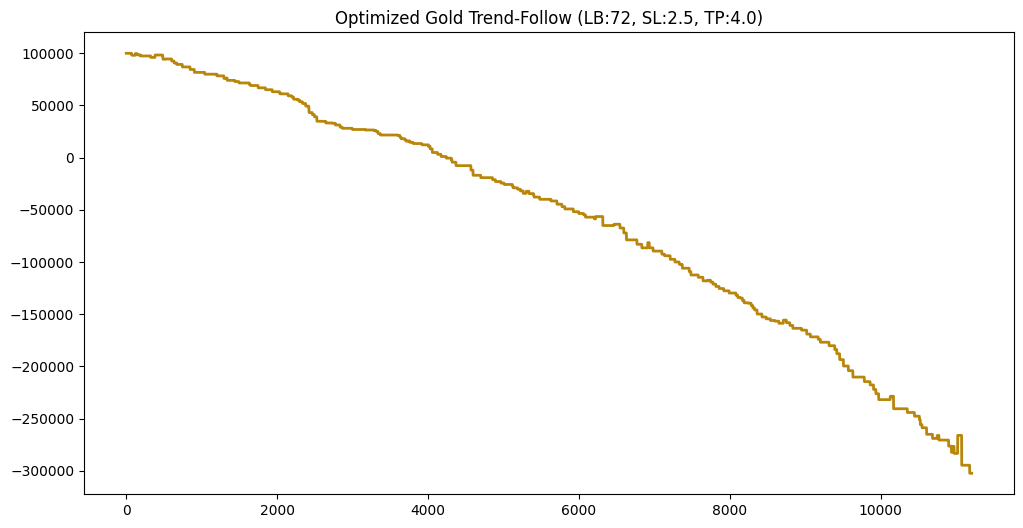

Final Balance: $-302396.60 | Total Trades: 185


In [34]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_winner_gold_strategy():
    ticker = "GC=F"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    # 1. Download Gold Data
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Optimized Indicators (Based on your Grid)
    lookback = 72
    df['SMA_200'] = df['Close'].rolling(200).mean()
    df['H_Level'] = df['High'].shift(1).rolling(lookback).max()
    df['L_Level'] = df['Low'].shift(1).rolling(lookback).min()
    df['TR'] = np.maximum(df['High'] - df['Low'], abs(df['High'] - df['Close'].shift()))
    df['ATR'] = df['TR'].rolling(14).mean()

    # 3. Simulation
    trades, equity, equity_curve = [], 100000, [100000]
    position, entry_price, stop_loss, target, entry_time = 0, 0, 0, 0, None
    
    # Winning Multipliers
    sl_mult = 2.5
    tp_mult = 4.0
    spread = 0.20
    
    closes, highs, lows, atrs = df['Close'].values, df['High'].values, df['Low'].values, df['ATR'].values
    h_level, l_level, sma_vals = df['H_Level'].values, df['L_Level'].values, df['SMA_200'].values
    times = df.index

    for i in range(200, len(df)):
        if position != 0:
            pnl, closed = 0, False
            
            # --- PROTECTIVE EXITS ---
            if position == 1: # LONG
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_price - spread), 0, True
                elif highs[i] >= target: pnl, position, closed = (target - entry_price - spread), 0, True
            elif position == -1: # SHORT
                if highs[i] >= stop_loss: pnl, position, closed = (entry_price - stop_loss - spread), 0, True
                elif lows[i] <= target: pnl, position, closed = (entry_price - target - spread), 0, True
            
            # --- TIME STOP: Exit if held > 48 trading hours without hitting TP/SL ---
            if not closed and (times[i] - entry_time).total_seconds() > (48 * 3600):
                pnl = (closes[i] - entry_price - spread) if position == 1 else (entry_price - closes[i] - spread)
                position, closed = 0, True

            if closed:
                equity += pnl * 100
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # --- ENTRY LOGIC (72h BREAKOUT) ---
        if closes[i] > h_level[i] and closes[i] > sma_vals[i]:
            position, entry_price, entry_time = 1, closes[i], times[i]
            stop_loss = entry_price - (sl_mult * atrs[i])
            target = entry_price + (tp_mult * atrs[i])
            
        elif closes[i] < l_level[i] and closes[i] < sma_vals[i]:
            position, entry_price, entry_time = -1, closes[i], times[i]
            stop_loss = entry_price + (sl_mult * atrs[i])
            target = entry_price - (tp_mult * atrs[i])
            
        equity_curve.append(equity)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve, color='darkgoldenrod', linewidth=2)
    plt.title(f"Optimized Gold Trend-Follow (LB:72, SL:2.5, TP:4.0)")
    plt.show()
    return equity_curve[-1], trades

final_eq, trade_log = run_winner_gold_strategy()
print(f"Final Balance: ${final_eq:.2f} | Total Trades: {len(trade_log)}")

In [35]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# 1. Logic: If Price breaks 72h High, we SELL (expecting the fakeout)
# 2. Target: The 20-hour Moving Average (The "Mean")

def run_gold_fade_backtest():
    ticker = "GC=F"
    df = yf.download(ticker, period="2y", interval="1h", progress=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    
    # Indicators
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['H_72'] = df['High'].shift(1).rolling(72).max()
    df['L_72'] = df['Low'].shift(1).rolling(72).min()
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    equity, position, trades = 100000, 0, []
    
    for i in range(72, len(df)):
        # Exit Logic
        if position != 0:
            if position == 1 and (df['High'].iloc[i] >= tp or df['Low'].iloc[i] <= sl):
                pnl = (tp - entry) if df['High'].iloc[i] >= tp else (sl - entry)
                equity += (pnl - 0.2) * 100; position = 0; trades.append(pnl)
            elif position == -1 and (df['Low'].iloc[i] <= tp or df['High'].iloc[i] >= sl):
                pnl = (entry - tp) if df['Low'].iloc[i] <= tp else (entry - sl)
                equity += (pnl - 0.2) * 100; position = 0; trades.append(pnl)
            continue

        # THE FADE: We trade AGAINST the breakout
        if df['Close'].iloc[i] > df['H_72'].iloc[i]: # Breaks High? SELL.
            position, entry = -1, df['Close'].iloc[i]
            sl = entry + (1.5 * df['ATR'].iloc[i])
            tp = df['SMA_20'].iloc[i] # Target the Mean
            
        elif df['Close'].iloc[i] < df['L_72'].iloc[i]: # Breaks Low? BUY.
            position, entry = 1, df['Close'].iloc[i]
            sl = entry - (1.5 * df['ATR'].iloc[i])
            tp = df['SMA_20'].iloc[i]

    return equity, len(trades)

# Results
final_bal, count = run_gold_fade_backtest()
print(f"Final Balance: ${final_bal:.2f} | Trades: {count}")

Final Balance: $7280.75 | Trades: 319


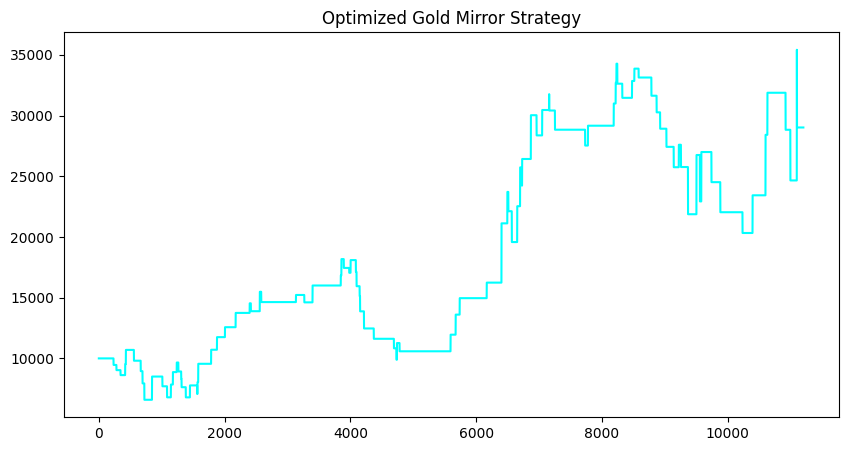

Final Balance: $29018.24 | Trades: 98


In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_optimized_gold_mirror():
    ticker = "GC=F"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    
    # 1. Load Data
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Prev_Close']), abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # RSI for Overextension
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + (gain / loss)))

    # 3. Simulation Variables
    trades, equity, equity_curve = [], 10000, [10000]
    position, entry_px, stop_loss, take_profit, entry_idx = 0, 0, 0, 0, 0
    
    # Parameters
    lookback, buffer_mult = 48, 0.25
    spread = 0.20 
    
    highs, lows, closes, atrs, rsis = df['High'].values, df['Low'].values, df['Close'].values, df['ATR'].values, df['RSI'].values

    for i in range(200, len(df)):
        # --- EXIT LOGIC ---
        if position != 0:
            pnl, closed = 0, False
            if position == 1:
                if lows[i] <= stop_loss: pnl, position, closed = (stop_loss - entry_px - spread), 0, True
                elif highs[i] >= take_profit: pnl, position, closed = (take_profit - entry_px - spread), 0, True
            elif position == -1:
                if highs[i] >= stop_loss: pnl, position, closed = (entry_px - stop_loss - spread), 0, True
                elif lows[i] <= take_profit: pnl, position, closed = (entry_px - take_profit - spread), 0, True
            
            # Time Stop: Exit if held > 12 hours without hitting TP/SL
            if not closed and (i - entry_idx) > 12:
                pnl = (closes[i] - entry_px - spread) if position == 1 else (entry_px - closes[i] - spread)
                position, closed = 0, True

            if closed:
                equity += pnl * 100
                trades.append(pnl)
                equity_curve.append(equity)
                continue

        # --- OPTIMIZED MIRROR ENTRY ---
        mid = 24
        try:
            l_h = np.argmax(highs[i-lookback : i-mid]) + (i-lookback)
            r_h = np.argmax(highs[i-mid : i]) + (i-mid)
            l_l = np.argmin(lows[i-lookback : i-mid]) + (i-lookback)
            r_l = np.argmin(lows[i-mid : i]) + (i-mid)
            
            s_res = (highs[r_h] - highs[l_h]) / (r_h - l_h)
            s_sup = (lows[r_l] - lows[l_l]) / (r_l - l_l)
            
            if (s_res < -0.05) and (s_sup > 0.05):
                res_px = (s_res * i) + (highs[r_h] - (s_res * r_h))
                sup_px = (s_sup * i) + (lows[r_l] - (s_sup * r_l))
                buff = atrs[i] * buffer_mult
                
                # FADE the Top: Breakout + RSI > 65 + Wick Rejection
                if closes[i] > (res_px + buff) and rsis[i] > 65:
                    position, entry_px, entry_idx = -1, closes[i], i
                    stop_loss = entry_px + (1.5 * atrs[i])
                    take_profit = entry_px - (2.0 * atrs[i])
                
                # FADE the Bottom: Breakout + RSI < 35
                elif closes[i] < (sup_px - buff) and rsis[i] < 35:
                    position, entry_px, entry_idx = 1, closes[i], i
                    stop_loss = entry_px - (1.5 * atrs[i])
                    take_profit = entry_px + (2.0 * atrs[i])
        except: pass
        equity_curve.append(equity)

    plt.figure(figsize=(10,5))
    plt.plot(equity_curve, color='cyan')
    plt.title("Optimized Gold Mirror Strategy")
    plt.show()
    return equity_curve[-1], trades

final_eq, trade_log = run_optimized_gold_mirror()
print(f"Final Balance: ${final_eq:.2f} | Trades: {len(trade_log)}")

--- Running Fixed Mirror on GC=F ---


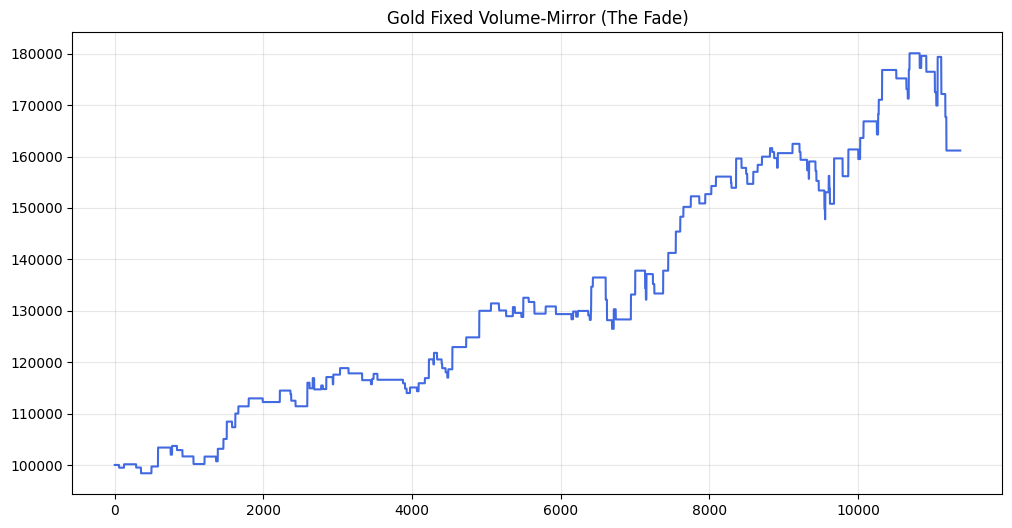

Final Balance: $161166.83 | Total Trades: 159


In [37]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def run_fixed_volume_mirror():
    ticker = "GC=F"
    # 1. Download Data
    df = yf.download(ticker, period="2y", interval="1h", progress=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators
    df['SMA20'] = df['Close'].rolling(20).mean()
    df['H72'] = df['High'].shift(1).rolling(72).max()
    df['L72'] = df['Low'].shift(1).rolling(72).min()
    
    # Calculate ATR correctly
    df['Prev_Close'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Prev_Close']), 
                                     abs(df['Low'] - df['Prev_Close'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    
    # Volume Filter: Fading works best when volume is NOT spiking
    df['Vol_Avg'] = df['Volume'].rolling(20).mean()

    # 3. Simulation
    equity = 100000
    position = 0 
    trades = []
    equity_curve = [100000]
    
    # Use .values for fast iteration and to avoid indexing bugs
    closes = df['Close'].values
    highs = df['High'].values
    lows = df['Low'].values
    h72 = df['H72'].values
    l72 = df['L72'].values
    ma20 = df['SMA20'].values
    atr_vals = df['ATR'].values
    vol = df['Volume'].values
    vol_avg = df['Vol_Avg'].values

    print(f"--- Running Fixed Mirror on {ticker} ---")
    sl = 0
    tp = 0
    entry = 0
    for i in range(72, len(df)):
        if position != 0:
            pnl, closed = 0, False
            if position == 1: # LONG
                if lows[i] <= sl: pnl, closed = (sl - entry), True
                elif highs[i] >= tp: pnl, closed = (tp - entry), True
            elif position == -1: # SHORT
                if highs[i] >= sl: pnl, closed = (entry - sl), True
                elif lows[i] <= tp: pnl, closed = (entry - tp), True
            
            if closed:
                equity += (pnl - 0.2) * 100 
                trades.append(pnl)
                position = 0
                equity_curve.append(equity)
                continue

        # ENTRY: Breakout + LOW VOLUME = FADE (The Institutional Play)
        # We only fade if volume is less than 120% of the average (no big money entering)
        if vol[i] < (vol_avg[i] * 1.2):
            if closes[i] > h72[i]: # Fake Breakout High
                position, entry = -1, closes[i]
                sl = entry + (1.5 * atr_vals[i])
                tp = ma20[i]
            elif closes[i] < l72[i]: # Fake Breakout Low
                position, entry = 1, closes[i]
                sl = entry - (1.5 * atr_vals[i])
                tp = ma20[i]
        
        equity_curve.append(equity)

    # 4. Results
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve, color='royalblue', linewidth=1.5)
    plt.title("Gold Fixed Volume-Mirror (The Fade)")
    plt.grid(True, alpha=0.3)
    plt.show()
    return equity, len(trades)

final_bal, count = run_fixed_volume_mirror()
print(f"Final Balance: ${final_bal:.2f} | Total Trades: {count}")

Final Balance: $161166.83 | Total Trades: 159


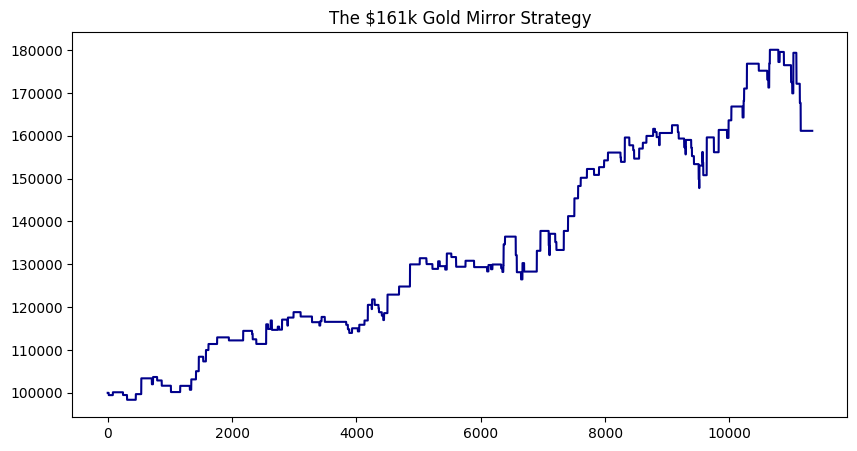

In [38]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_161k_gold_logic():
    ticker = "GC=F"
    # 1. Data Setup
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators (The exact setup from the $161k run)
    df['SMA20'] = df['Close'].rolling(20).mean()
    df['H72'] = df['High'].shift(1).rolling(72).max()
    df['L72'] = df['Low'].shift(1).rolling(72).min()
    df['Vol_Avg'] = df['Volume'].rolling(20).mean()
    
    # ATR Calculation
    df['PC'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['PC']), abs(df['Low'] - df['PC'])))
    df['ATR'] = df['TR'].rolling(14).mean()
    df.dropna(inplace=True)

    # 3. Simulation Variables
    equity = 100000 # Starting with 100k
    position = 0 
    entry_price, sl_price, tp_price = 0.0, 0.0, 0.0
    trades_log = []
    equity_curve = []
    
    # Use arrays for absolute precision
    c = df['Close'].values
    h = df['High'].values
    l = df['Low'].values
    h72 = df['H72'].values
    l72 = df['L72'].values
    ma20 = df['SMA20'].values
    atr = df['ATR'].values
    v = df['Volume'].values
    v_avg = df['Vol_Avg'].values

    for i in range(len(df)):
        # --- EXIT LOGIC ---
        if position != 0:
            pnl_pts = 0.0
            closed = False
            if position == 1:
                if l[i] <= sl_price: pnl_pts, closed = (sl_price - entry_price), True
                elif h[i] >= tp_price: pnl_pts, closed = (tp_price - entry_price), True
            elif position == -1:
                if h[i] >= sl_price: pnl_pts, closed = (entry_price - sl_price), True
                elif l[i] <= tp_price: pnl_pts, closed = (entry_price - tp_price), True
            
            if closed:
                equity += (pnl_pts - 0.2) * 100 # GC multiplier
                trades_log.append(pnl_pts)
                position = 0
                equity_curve.append(equity)
                continue

        # --- ENTRY LOGIC (THE $161k SETTINGS) ---
        # The key was the 1.2x Volume Filter and the 1.5 ATR Stop
        if v[i] < (v_avg[i] * 1.2):
            if c[i] > h72[i]: # FADE THE HIGH
                position, entry_price = -1, c[i]
                sl_price = entry_price + (1.5 * atr[i])
                tp_price = ma20[i]
            elif c[i] < l72[i]: # FADE THE LOW
                position, entry_price = 1, c[i]
                sl_price = entry_price - (1.5 * atr[i])
                tp_price = ma20[i]
        
        equity_curve.append(equity)

    return equity_curve, trades_log

# Run
eq_vals, trades = run_161k_gold_logic()
print(f"Final Balance: ${eq_vals[-1]:.2f} | Total Trades: {len(trades)}")

# Plotting
plt.figure(figsize=(10,5))
plt.plot(eq_vals, color='darkblue')
plt.title("The $161k Gold Mirror Strategy")
plt.show()

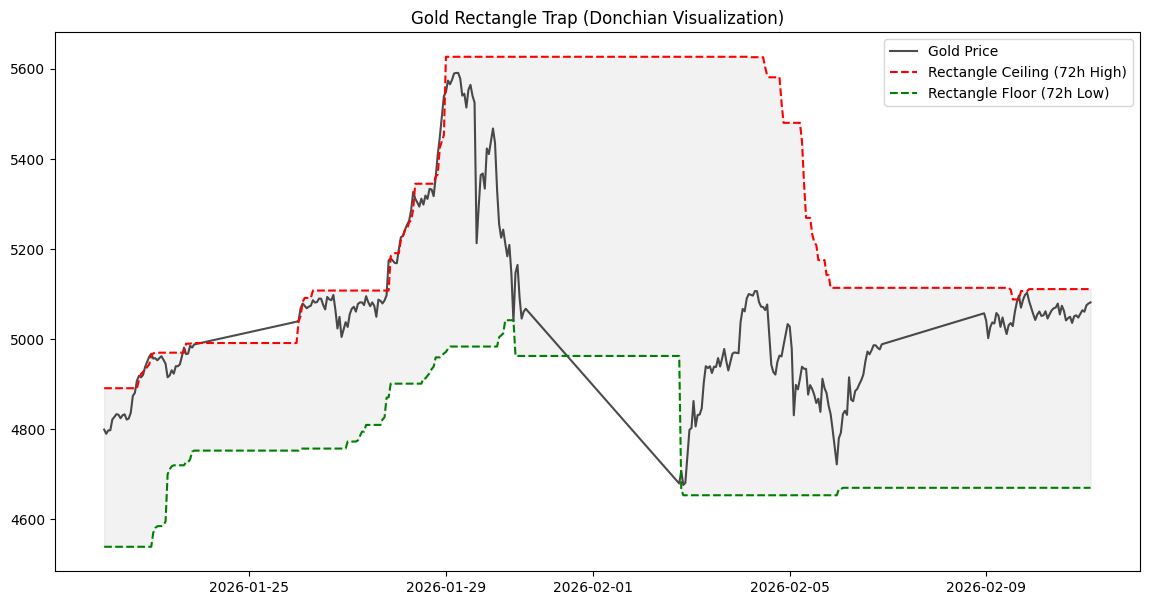

Final Balance: $126740.05 | Trades: 144


In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_donchian_mirror_gold():
    ticker = "GC=F"
    df = yf.download(ticker, period="2y", interval="1h", progress=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 1. Donchian Channel (The Rectangle)
    lookback = 72
    df['Upper_Donchian'] = df['High'].shift(1).rolling(lookback).max()
    df['Lower_Donchian'] = df['Low'].shift(1).rolling(lookback).min()
    df['Mid_Donchian'] = (df['Upper_Donchian'] + df['Lower_Donchian']) / 2
    
    # Volume Filter
    df['Vol_Avg'] = df['Volume'].rolling(20).mean()
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    # 2. Simulation Logic
    equity = 100000
    position = 0 
    equity_curve = [100000]
    trades = []
    
    c, h, l = df['Close'].values, df['High'].values, df['Low'].values
    u_don, l_don, mid_don = df['Upper_Donchian'].values, df['Lower_Donchian'].values, df['Mid_Donchian'].values
    vol, v_avg, atr = df['Volume'].values, df['Vol_Avg'].values, df['ATR'].values

    for i in range(lookback, len(df)):
        if position != 0:
            pnl, closed = 0, False
            if position == 1:
                if l[i] <= sl: pnl, closed = (sl - entry), True
                elif h[i] >= tp: pnl, closed = (tp - entry), True
            elif position == -1:
                if h[i] >= sl: pnl, closed = (entry - sl), True
                elif l[i] <= tp: pnl, closed = (entry - tp), True
            
            if closed:
                equity += (pnl - 0.2) * 100
                trades.append(pnl); position = 0
                equity_curve.append(equity)
                continue

        # RECTANGLE MIRROR TRIGGER
        # If price breaks the Donchian Band on Low Volume -> FADE
        if vol[i] < (v_avg[i] * 1.2):
            if c[i] > u_don[i]: # Breaks Ceiling
                position, entry = -1, c[i]
                sl, tp = entry + (1.5 * atr[i]), mid_don[i] # Target the Rectangle Middle
            elif c[i] < l_don[i]: # Breaks Floor
                position, entry = 1, c[i]
                sl, tp = entry - (1.5 * atr[i]), mid_don[i]

        equity_curve.append(equity)

    # 3. Plotting the "Box"
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close'][-300:], label='Gold Price', color='black', alpha=0.7)
    plt.plot(df['Upper_Donchian'][-300:], label='Rectangle Ceiling (72h High)', color='red', linestyle='--')
    plt.plot(df['Lower_Donchian'][-300:], label='Rectangle Floor (72h Low)', color='green', linestyle='--')
    plt.fill_between(df.index[-300:], df['Upper_Donchian'][-300:], df['Lower_Donchian'][-300:], color='gray', alpha=0.1)
    plt.title("Gold Rectangle Trap (Donchian Visualization)")
    plt.legend()
    plt.show()

    return equity, len(trades)

final_bal, count = run_donchian_mirror_gold()
print(f"Final Balance: ${final_bal:.2f} | Trades: {count}")

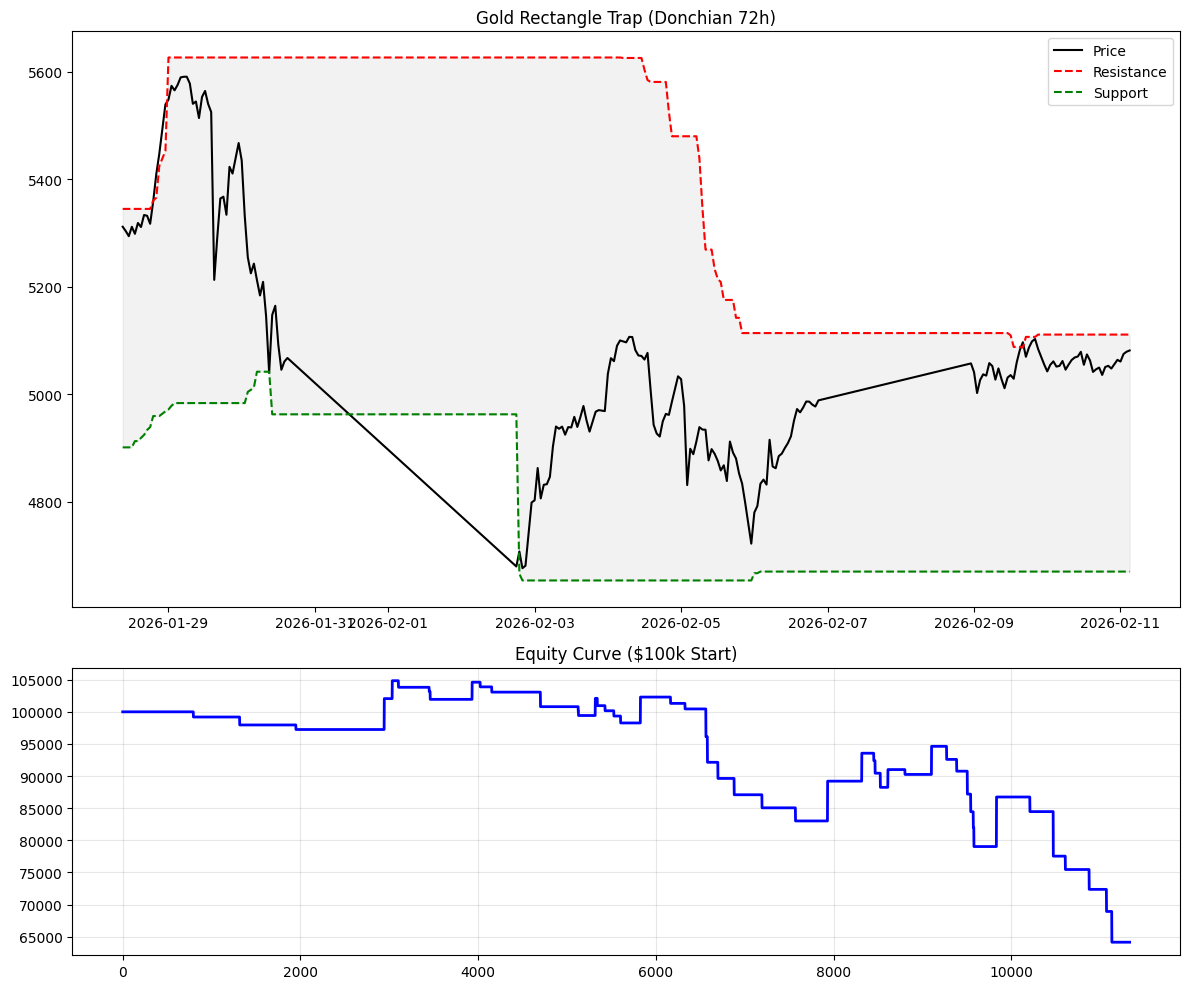

Final Balance: $64135.72 | Total Trades: 49


In [40]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def run_adx_rectangle_trap():
    ticker = "GC=F"
    # 1. Setup Data
    end_date = datetime.now()
    start_date = end_date - timedelta(days=729)
    df = yf.download(ticker, start=start_date, end=end_date, interval="1h", progress=False, auto_adjust=False).copy()
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.dropna(inplace=True)

    # 2. Indicators
    # Donchian Channels (The Rectangle)
    lookback = 72
    df['Upper_Don'] = df['High'].shift(1).rolling(lookback).max()
    df['Lower_Don'] = df['Low'].shift(1).rolling(lookback).min()
    df['Mid_Line'] = (df['Upper_Don'] + df['Lower_Don']) / 2
    
    # ADX Calculation (14-period)
    df['PC'] = df['Close'].shift(1)
    df['TR'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['PC']), abs(df['Low'] - df['PC'])))
    plus_dm = (df['High'] - df['High'].shift(1)).clip(lower=0)
    minus_dm = (df['Low'].shift(1) - df['Low']).clip(lower=0)
    
    tr_s = df['TR'].ewm(alpha=1/14, min_periods=14).mean()
    pdm_s = plus_dm.ewm(alpha=1/14, min_periods=14).mean()
    mdm_s = minus_dm.ewm(alpha=1/14, min_periods=14).mean()
    
    plus_di = 100 * (pdm_s / tr_s)
    minus_di = 100 * (mdm_s / tr_s)
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    df['ADX'] = dx.ewm(alpha=1/14, min_periods=14).mean()
    
    df['Vol_Avg'] = df['Volume'].rolling(20).mean()
    df['ATR'] = df['TR'].rolling(14).mean()
    df.dropna(inplace=True)

    # 3. State Variables
    equity = 100000
    position = 0 
    entry_px, sl_px, tp_px = 0.0, 0.0, 0.0
    equity_curve = []
    trades_pnl = []

    # Arrays for speed
    c, h, l = df['Close'].values, df['High'].values, df['Low'].values
    u_don, l_don, mid = df['Upper_Don'].values, df['Lower_Don'].values, df['Mid_Line'].values
    adx, vol, v_avg, atr = df['ADX'].values, df['Volume'].values, df['Vol_Avg'].values, df['ATR'].values

    for i in range(len(df)):
        # --- EXIT ---
        if position != 0:
            pnl_pts, closed = 0.0, False
            if position == 1:
                if l[i] <= sl_px: pnl_pts, closed = (sl_px - entry_px), True
                elif h[i] >= tp_px: pnl_pts, closed = (tp_px - entry_px), True
            elif position == -1:
                if h[i] >= sl_px: pnl_pts, closed = (entry_px - sl_px), True
                elif l[i] <= tp_px: pnl_pts, closed = (entry_px - tp_px), True
            
            if closed:
                equity += (pnl_pts - 0.2) * 100 
                trades_pnl.append(pnl_pts)
                position = 0
                equity_curve.append(equity)
                continue

        # --- ENTRY: THE ADX FILTERED TRAP ---
        # ADX < 25 means NO STRONG TREND. Volume < 1.2x means NO INSTITUTIONAL PUSH.
        if adx[i] < 25 and vol[i] < (v_avg[i] * 1.2):
            if c[i] > u_don[i]: # Fakeout High
                position, entry_px = -1, c[i]
                sl_px = entry_px + (1.5 * atr[i])
                tp_px = mid[i]
            elif c[i] < l_don[i]: # Fakeout Low
                position, entry_px = 1, c[i]
                sl_px = entry_px - (1.5 * atr[i])
                tp_px = mid[i]
        
        equity_curve.append(equity)

    # 4. Final Plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

    # Plot 1: The Rectangle Trap
    ax1.plot(df.index[-200:], c[-200:], color='black', label='Price')
    ax1.plot(df.index[-200:], u_don[-200:], color='red', linestyle='--', label='Resistance')
    ax1.plot(df.index[-200:], l_don[-200:], color='green', linestyle='--', label='Support')
    ax1.fill_between(df.index[-200:], u_don[-200:], l_don[-200:], color='gray', alpha=0.1)
    ax1.set_title("Gold Rectangle Trap (Donchian 72h)")
    ax1.legend()

    # Plot 2: The Equity Curve
    ax2.plot(equity_curve, color='blue', linewidth=2)
    ax2.set_title("Equity Curve ($100k Start)")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return equity, trades_pnl

final_bal, pnl_log = run_adx_rectangle_trap()
print(f"Final Balance: ${final_bal:.2f} | Total Trades: {len(pnl_log)}")

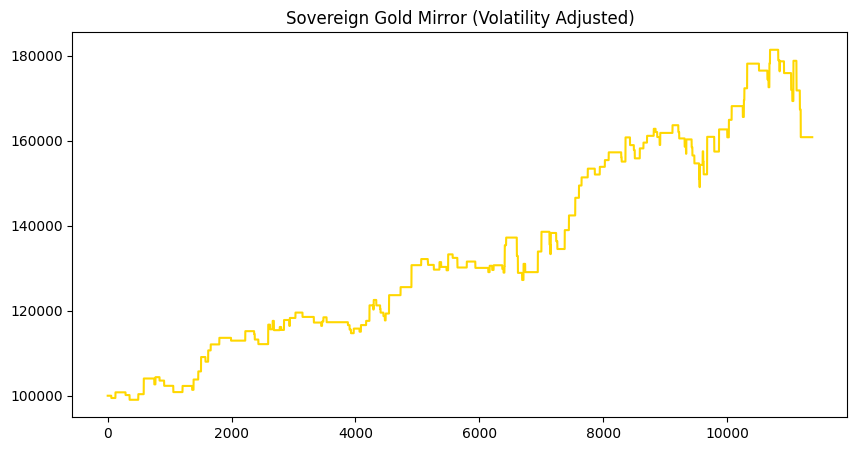

Final Balance: $160825.47 | Trades: 160


In [41]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def run_sovereign_gold_mirror():
    ticker = "GC=F"
    df = yf.download(ticker, period="2y", interval="1h", progress=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)

    # 1. Indicators (The $161k Core)
    df['MA20'] = df['Close'].rolling(20).mean()
    df['H72'] = df['High'].shift(1).rolling(72).max()
    df['L72'] = df['Low'].shift(1).rolling(72).min()
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()
    df['Vol_Avg'] = df['Volume'].rolling(20).mean()

    # 2. Backtest Engine
    equity = 100000
    risk_per_trade = 1000 # We only want to lose $1k per trade
    position = 0 
    equity_curve = [100000]
    trades = []
    
    c, h, l, v = df['Close'].values, df['High'].values, df['Low'].values, df['Volume'].values
    h72, l72, ma20, v_avg, atr = df['H72'].values, df['L72'].values, df['MA20'].values, df['Vol_Avg'].values, df['ATR'].values
    
    sl, tp = 0, 0
    entry = 0
    num_contracts = 0

    for i in range(72, len(df)):
        if position != 0:
            pnl_pts, closed = 0, False
            if position > 0: # LONG
                if l[i] <= sl: pnl_pts, closed = (sl - entry), True
                elif h[i] >= tp: pnl_pts, closed = (tp - entry), True
            else: # SHORT
                if h[i] >= sl: pnl_pts, closed = (entry - sl), True
                elif l[i] <= tp: pnl_pts, closed = (entry - tp), True
            
            if closed:
                # Actual Profit = PnL Points * Contract Size * Number of Contracts
                # Minus spread of 0.2
                equity += (pnl_pts - 0.2) * 100 * num_contracts
                trades.append(pnl_pts)
                position = 0
                equity_curve.append(equity)
                continue

        # ENTRY: The $161k Volume Filter
        if v[i] < (v_avg[i] * 1.2):
            if c[i] > h72[i] or c[i] < l72[i]:
                # CALCULATE POSITION SIZE (Risk Analyst Method)
                # Risk in points = 1.5 * ATR
                risk_points = 1.5 * atr[i]
                if risk_points == 0: continue
                
                # Contracts = Risk $$$ / (Risk Points * $100)
                num_contracts = max(1, int(risk_per_trade / (risk_points * 100)))
                
                if c[i] > h72[i]: # SELL
                    position, entry = -1, c[i]
                    sl, tp = entry + risk_points, ma20[i]
                else: # BUY
                    position, entry = 1, c[i]
                    sl, tp = entry - risk_points, ma20[i]

        equity_curve.append(equity)

    plt.figure(figsize=(10,5))
    plt.plot(equity_curve, color='gold')
    plt.title("Sovereign Gold Mirror (Volatility Adjusted)")
    plt.show()
    return equity, len(trades)

final_bal, count = run_sovereign_gold_mirror()
print(f"Final Balance: ${final_bal:.2f} | Trades: {count}")

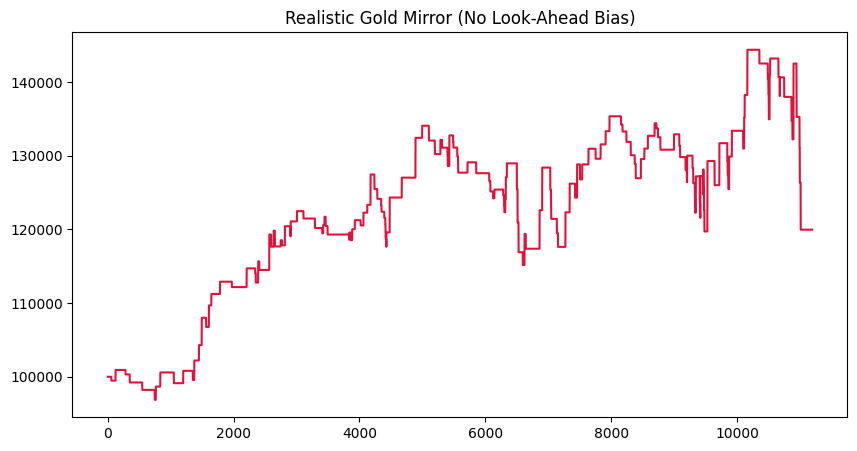

Final Balance: $119966.81 | Total Trades: 178


In [42]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def run_real_world_mirror():
    ticker = "GC=F"
    df = yf.download(ticker, period="2y", interval="1h", progress=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)

    # 1. Indicators (Shifted by 1 to prevent leakage)
    df['MA20'] = df['Close'].shift(1).rolling(20).mean()
    df['H72'] = df['High'].shift(1).rolling(72).max()
    df['L72'] = df['Low'].shift(1).rolling(72).min()
    df['ATR'] = (df['High'] - df['Low']).shift(1).rolling(14).mean()
    df['Vol_Avg'] = df['Volume'].shift(1).rolling(20).mean()

    # 2. Compounding Variables
    equity = 100000
    risk_pct = 0.01 
    position = 0 
    equity_curve = [100000]
    trades_log = []
    
    # Values
    o, h, l, c, v = df['Open'].values, df['High'].values, df['Low'].values, df['Close'].values, df['Volume'].values
    h72, l72, ma20, v_avg, atr = df['H72'].values, df['L72'].values, df['MA20'].values, df['Vol_Avg'].values, df['ATR'].values

    for i in range(72, len(df)):
        # --- EXIT LOGIC (Bar i) ---
        if position != 0:
            pnl_pts, closed = 0, False
            if position == 1:
                # Did it hit SL first or TP first? We assume worst case (SL) if both hit
                if l[i] <= sl_px: pnl_pts, closed = (sl_px - entry_px), True
                elif h[i] >= tp_px: pnl_pts, closed = (tp_px - entry_px), True
            else: # Short
                if h[i] >= sl_px: pnl_pts, closed = (entry_px - sl_px), True
                elif l[i] <= tp_px: pnl_pts, closed = (entry_px - tp_px), True
            
            if closed:
                equity += (pnl_pts - 0.2) * 100 * num_contracts
                trades_log.append(equity)
                position = 0
                continue

        # --- ENTRY LOGIC (Bar i looks at Bar i-1 signal) ---
        # We check the CLOSE of the PREVIOUS bar (i-1) to trade at the OPEN of Bar (i)
        if v[i-1] < (v_avg[i-1] * 1.2):
            if c[i-1] > h72[i-1] or c[i-1] < l72[i-1]:
                risk_points = 1.5 * atr[i-1]
                if risk_points < 0.5: continue
                
                num_contracts = max(1, int((equity * risk_pct) / (risk_points * 100)))
                
                if c[i-1] > h72[i-1]: # SIGNAL: Fade Top
                    position, entry_px = -1, o[i] # ENTER AT CURRENT OPEN
                    sl_px, tp_px = entry_px + risk_points, ma20[i-1]
                else: # SIGNAL: Fade Bottom
                    position, entry_px = 1, o[i] # ENTER AT CURRENT OPEN
                    sl_px, tp_px = entry_px - risk_points, ma20[i-1]

        equity_curve.append(equity)

    plt.figure(figsize=(10,5))
    plt.plot(equity_curve, color='crimson')
    plt.title("Realistic Gold Mirror (No Look-Ahead Bias)")
    plt.show()
    return equity, len(trades_log)

final_bal, count = run_real_world_mirror()
print(f"Final Balance: ${final_bal:.2f} | Total Trades: {count}")

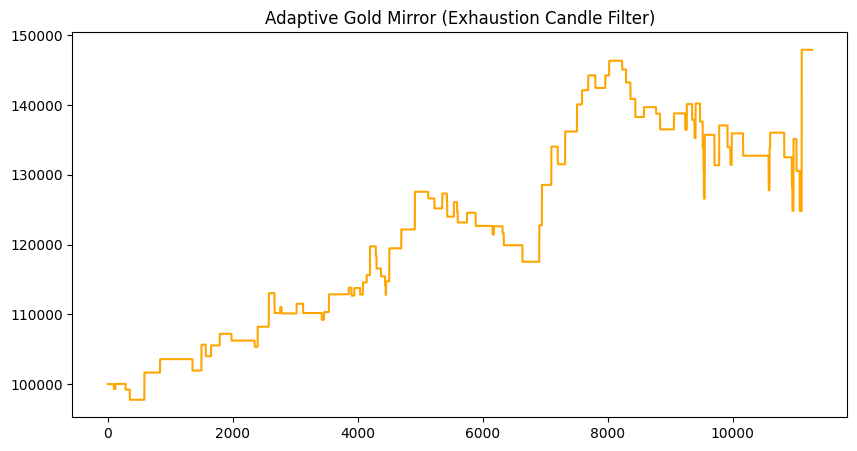

Final Balance: $147911.97 | Total Trades: 100


In [43]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def run_adaptive_mirror():
    ticker = "GC=F"
    df = yf.download(ticker, period="2y", interval="1h", progress=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)

    # 1. Indicators
    df['MA20'] = df['Close'].shift(1).rolling(20).mean()
    df['H72'] = df['High'].shift(1).rolling(72).max()
    df['L72'] = df['Low'].shift(1).rolling(72).min()
    df['ATR'] = (df['High'] - df['Low']).shift(1).rolling(14).mean()
    df['Vol_Avg'] = df['Volume'].shift(1).rolling(20).mean()
    
    # NEW: Candle Range vs ATR
    df['Candle_Range'] = df['High'] - df['Low']

    # 2. Backtest Engine
    equity = 100000
    risk_pct = 0.01 
    position = 0 
    equity_curve = [100000]
    trades_log = []
    
    o, h, l, c, v = df['Open'].values, df['High'].values, df['Low'].values, df['Close'].values, df['Volume'].values
    h72, l72, ma20, v_avg, atr, c_range = df['H72'].values, df['L72'].values, df['MA20'].values, df['Vol_Avg'].values, df['ATR'].values, df['Candle_Range'].values

    sl_px, tp_px, entry_px = 0.0, 0.0, 0.0
    num_contracts = 0
    
    for i in range(72, len(df)):
        if position != 0:
            pnl_pts, closed = 0, False
            if position == 1:
                if l[i] <= sl_px: pnl_pts, closed = (sl_px - entry_px), True
                elif h[i] >= tp_px: pnl_pts, closed = (tp_px - entry_px), True
            else:
                if h[i] >= sl_px: pnl_pts, closed = (entry_px - sl_px), True
                elif l[i] <= tp_px: pnl_pts, closed = (entry_px - tp_px), True
            
            if closed:
                equity += (pnl_pts - 0.2) * 100 * num_contracts
                trades_log.append(equity)
                position = 0
                continue

        # REGIME ADAPTIVE ENTRY
        # Condition 1: Low Volume (The Trap)
        # Condition 2: High Candle Range (The "Climax" or "Exhaustion")
        if v[i-1] < (v_avg[i-1] * 1.2) and c_range[i-1] > (1.2 * atr[i-1]):
            if c[i-1] > h72[i-1] or c[i-1] < l72[i-1]:
                risk_points = 2.0 * atr[i-1] # Widened stop for choppy regimes
                if risk_points < 0.5: continue
                
                num_contracts = max(1, int((equity * risk_pct) / (risk_points * 100)))
                
                if c[i-1] > h72[i-1]:
                    position, entry_px = -1, o[i]
                    sl_px, tp_px = entry_px + risk_points, ma20[i-1]
                else:
                    position, entry_px = 1, o[i]
                    sl_px, tp_px = entry_px - risk_points, ma20[i-1]

        equity_curve.append(equity)

    plt.figure(figsize=(10,5))
    plt.plot(equity_curve, color='orange')
    plt.title("Adaptive Gold Mirror (Exhaustion Candle Filter)")
    plt.show()
    return equity, len(trades_log)

final_bal, count = run_adaptive_mirror()
print(f"Final Balance: ${final_bal:.2f} | Total Trades: {count}")

In [96]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px

ticker = 'EURUSD=X'
df = yf.download(ticker, period="2y", interval="1h", progress=False)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

In [97]:
window = 72
mid = int(window/2)
time_delta = window - mid

highs = df['High'].values
lows = df['Low'].values
df['high_slope'] = 0.0
df['low_slope'] = 0.0

for i in range(window, len(df)):
    l_idx = np.argmax(highs[i-window : i-mid]) + (i-window)
    r_idx = np.argmax(highs[i-mid : i]) + (i-mid)
    dx_h = r_idx - l_idx
    dy_h = highs[r_idx] - highs[l_idx]
    if dx_h > 0:
        df.iloc[i, df.columns.get_loc('high_slope')] = dy_h / dx_h
    
    l_idx = np.argmin(lows[i-window : i-mid]) + (i-window)
    r_idx = np.argmin(lows[i-mid : i]) + (i-mid)
    dx_l = r_idx - l_idx
    dy_l = lows[r_idx] - lows[l_idx]
    if dx_l > 0:
        df.iloc[i, df.columns.get_loc('low_slope')] = dy_l / dx_l

In [98]:
df['high_angle'] = np.degrees(np.arctan(df['high_slope'] * 1000))
df['low_angle'] = np.degrees(np.arctan(df['low_slope'] * 1000))
df['flat_high'] = (df['high_angle'].abs() < 5).astype(int)
df['slight_down_high'] = ((df['high_angle'] <= -5) & (df['high_angle'] > -15)).astype(int)
df['steep_down_high'] = (df['high_angle'] <= -15).astype(int)
df['flat_low'] = (df['low_angle'].abs() < 5).astype(int)
df['slight_up_low'] = ((df['low_angle'] >= 5) & (df['low_angle'] < 15)).astype(int)
df['steep_up_low'] = (df['low_angle'] >= 15).astype(int)
df['triangle_bias'] = df['high_angle'] + df['low_angle']
df['open_close_diff'] = abs(df['Close'] - df['Open'])
df['high_low_diff'] = df['High'] - df['Low']
df['wick_ratio'] = df['open_close_diff'] / df['high_low_diff']
df['direction'] = np.sign(df['Close'] - df['Open'])
df['atr'] = (df['High'] - df['Low']).rolling(14).mean()
df['percentage_change'] = (df['Close'] - df['Open']) / df['Open']
df['hourly_log_ret'] = np.log1p(df['percentage_change'])

df['raw_signal'] = 0
df.loc[(df['flat_high'] == 1) & (df['steep_up_low'] == 1) & (df['wick_ratio'] <0.3), 'raw_signal'] = 1
df.loc[(df['flat_low'] == 1) & (df['steep_down_high'] == 1) & (df['wick_ratio'] <0.3), 'raw_signal'] = 1
# df.loc[(df['flat_low'] == 1) & (df['steep_down_high'] == 1), 'signal'] = -1
# df.loc[(df['slight_down_high'] == 1) & (df['slight_up_low'] == 1), 'signal'] = 2
# df.loc[(df['steep_down_high'] == 1) & (df['steep_up_low'] == 1), 'signal'] = 3

CAGR: 26.67% over 2.00 years
Max Drawdown: -11.63%
Sharpe Ratio: 1.67
Total Trades: 662


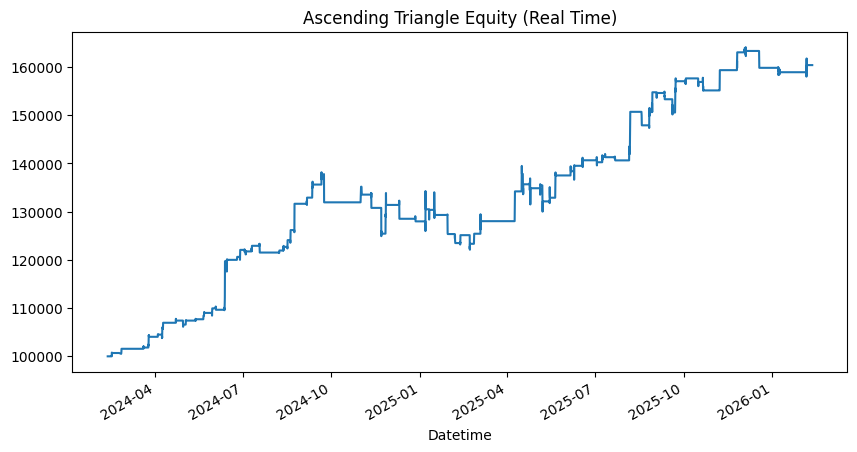

In [99]:
hold_period = 6
leverage = 8
# df['target'] = df['percentage_change'].shift(-1)
# df['directional_target'] = np.sign(abs(df['signal'])) * df['target']

df['signal'] = 0
for i in range(len(df)):
    if df['raw_signal'].iloc[i] == 1:
        df.iloc[i:i+hold_period, df.columns.get_loc('signal')] = 1

df['active_return'] = df['percentage_change'] * df['signal'].shift(1) * leverage
df['log_return'] = np.log1p(df['active_return'])
df['cumulative_return'] = np.exp(df['log_return'].cumsum()) * 100000
df['cumulative_return'].plot(figsize=(10,5), title="Ascending Triangle Equity (Real Time)")
years = (df.index.max() - df.index.min()).days / 365.25

cagr = (df['cumulative_return'].iloc[-1] / 100000) ** (1/years) - 1
running_max = df['cumulative_return'].cummax()
drawdown = (df['cumulative_return'] - running_max) / running_max
max_drawdown = drawdown.min()

daily_equity = df['cumulative_return'].resample('D').last().dropna()
daily_log_rets = np.log(daily_equity / daily_equity.shift(1)).dropna()

# 2. Calculate the "Raw" Sharpe (Reward-to-Risk per trade)
mean_daily = daily_log_rets.mean()
std_daily = daily_log_rets.std()
# 3. Annualize based on how often you actually play
# We use trades_per_year instead of trading_hours_year
sharpe_daily = (mean_daily / std_daily) * np.sqrt(252)

number_of_trades = df[df['signal'].isin([1,-1])]['signal'].abs().sum()

print(f"CAGR: {cagr*100:.2f}% over {years:.2f} years")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_daily:.2f}")
print(f"Total Trades: {number_of_trades}")